In [1]:
import cv2
import mediapipe as mp
import numpy as np
from numpy import asarray
from numpy import save

In [2]:
# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils

# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence = 0.5)

In [3]:
# Getting the input video for pose estimation

#cap = cv2.VideoCapture('1_1-1.mp4')
#cap = cv2.VideoCapture('v1_1-1.mp4')
cap = cv2.VideoCapture('2v_1-1.mp4')
#cap = cv2.VideoCapture('2_1-3.mp4')

# Number to convert the real world coordinate from meters to milimeters
num = 1000

In [4]:
# Landmarks dictionary to define body segments landmarks according to BlazePose Topology

landmarks_coordinates = {}

thigh_segments = {"Left Thigh": [23, 25], "Right Thigh": [24, 26]}

upperarm_segments = {"Left Upper Arm": [11, 13], "Right Upper Arm": [12, 14]}

forearm_segments = {"Left Fore Arm": [13, 15], "Right Fore Arm": [14, 16]}

leg_segments = {"Left Leg": [25, 27], "Right Leg": [26, 28]}

foot_segments = {"Left foot": [27, 31], "Right foot": [28, 32]}

hands_segments = {"Left hand": [15, 19], "Right hand": [16, 20]}

shoulder_segment = {"Shoulder": [12, 11]}

hips_segment = {"Hips": [24, 23]}

trunk_segment = {"trunk": [34, 33]}

In [5]:
# Function to calculate CoM coordinates for segments defined in the dictionary

def calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j):
    x1 = (x_i + x_j) * 0.5
    y1 = (y_i + y_j) * 0.5
    z1 = (z_i + z_j) * 0.5

    return x1, y1, z1

def calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h):
    x2 = x_g + 0.433 * (x_h - x_g)
    y2 = y_g - 0.433 * (y_g - y_h)
    z2 = z_g - 0.433 * (z_g - z_h)

    return x2, y2, z2


def calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b):
    x3 = x_a + 0.433 * (x_b - x_a)
    y3 = y_a - 0.433 * (y_a - y_b)
    z3 = z_a - 0.433 * (z_a - z_b)

    return x3, y3, z3


def calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d):
    x4 = x_c + 0.436 * (x_d - x_c)
    y4 = y_c - 0.436 * (y_c - y_d)
    z4 = z_c - 0.436 * (z_c - z_d)

    return x4, y4, z4


def calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f):
    x5 = x_e + 0.430 * (x_f - x_e)
    y5 = y_e - 0.430 * (y_e - y_f)
    z5 = z_e - 0.430 * (z_e - z_f)

    return x5, y5, z5


def calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p):
    x6 = x_o + 0.506 * (x_p - x_o)
    y6 = y_o - 0.506 * (y_o - y_p)
    z6 = z_o - 0.506 * (z_o - z_p)

    return x6, y6, z6


def calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r):
    x7 = x_q - 0.66 * (x_q - x_r)
    y7 = y_q - 0.66 * (y_q - y_r)
    z7 = z_q - 0.66 * (z_q - z_r)    

    return x7, y7, z7


def calculate_average(x_l, x_r, y_l, y_r, z_l, z_r):
    x = (x_l + x_r) * 0.5
    y = (y_l + y_r) * 0.5
    z = (z_l + z_r) * 0.5
    
    return x, y, z

In [6]:
### Pose estimation for one individual in a video

# While the video is running, perform pose detection 
while True:
    success, image = cap.read()
    results = pose.process(image)
    
    # Defining a variable to calculate the whole body CoM in the end, by getting
    # all the segment´s CoM coordinates values
    com_body = 0
    
    # Check if any landmarks are found.
    if results.pose_world_landmarks:
        # draw the connections between joint landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 ) 
        # Enumerate each landmark according to BlazePose Topology 
        for idx, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = image.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            #cv2.circle(image, (cx, cy), 2, (0, 0, 255), cv2.FILLED)
            #if idx == 32:
                #print(idx, lm.x, lm.y, lm.z)
                #print("[%s, %s, %s],\n" % (str(lm.x), str(lm.y), str(lm.z)))
            landmarks_coordinates[idx] = {"x": lm.x, "y": lm.y, "z": lm.z}

       # Calculating trunk CoM coordinates by defining the average point in the shoulder and
        # hips segment
        x_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["x"]
        y_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["y"]
        z_left_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][1]]["z"]
        x_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["x"]
        y_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["y"]
        z_right_shoulder = landmarks_coordinates[shoulder_segment["Shoulder"][0]]["z"]
        x_average_shoulder, y_average_shoulder, z_average_shoulder = calculate_average(
            x_left_shoulder, x_right_shoulder, y_left_shoulder, y_right_shoulder, z_left_shoulder, z_right_shoulder
        )

        landmarks_coordinates[33] = {"x": x_average_shoulder, "y": y_average_shoulder, "z": z_average_shoulder}

        x_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["x"]
        y_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["y"]
        z_left_hips = landmarks_coordinates[hips_segment["Hips"][1]]["z"]
        x_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["x"]
        y_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        z_right_hips = landmarks_coordinates[hips_segment["Hips"][0]]["y"]
        x_average_hips, y_average_hips, z_average_hips = calculate_average(
            x_left_hips, x_right_hips, y_left_hips, y_right_hips, z_left_hips, z_right_hips
        )

        landmarks_coordinates[34] = {"x": x_average_hips, "y": y_average_hips, "z": z_average_hips}

    # Calculate Body segments CoM

    foot_com_x = 0
    foot_com_y = 0
    foot_com_z = 0
    for segment in foot_segments:
        # print("%s COM:" % segment)
        x_i = landmarks_coordinates[foot_segments[segment][0]]["x"]
        x_j = landmarks_coordinates[foot_segments[segment][1]]["x"]
        y_i = landmarks_coordinates[foot_segments[segment][0]]["y"]
        y_j = landmarks_coordinates[foot_segments[segment][1]]["y"]
        z_i = landmarks_coordinates[foot_segments[segment][0]]["z"]
        z_j = landmarks_coordinates[foot_segments[segment][1]]["z"]
        
        x1, y1, z1 = calculate_foot_CoM(x_i, x_j, y_i, y_j, z_i, z_j)
        #print("x: %s, y: %s\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(x1), str(y1)))
        #print("[%s, %s],\n" % (str(y_i), str(y_j)))

        #h, w, c = image.shape
        cx, cy = int(x1*w), int(y1*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        foot_com_x += x1
        foot_com_y += y1
        foot_com_z += z1

    leg_com_x = 0
    leg_com_y = 0
    leg_com_z = 0
    for segment in leg_segments:
        # print("%s COM:" % segment)
        x_g = landmarks_coordinates[leg_segments[segment][0]]["x"]
        x_h = landmarks_coordinates[leg_segments[segment][1]]["x"]
        y_g = landmarks_coordinates[leg_segments[segment][0]]["y"]
        y_h = landmarks_coordinates[leg_segments[segment][1]]["y"]
        z_g = landmarks_coordinates[leg_segments[segment][0]]["z"]
        z_h = landmarks_coordinates[leg_segments[segment][1]]["z"]
        
        x2, y2, z2 = calculate_Leg_CoM(x_g, x_h, y_g, y_h, z_g, z_h)
        # print("x: %s, y: %s\n" % (str(x2), str(y2)))

        #h, w, c = image.shape
        cx, cy = int(x2*w), int(y2*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        leg_com_x += x2
        leg_com_y += y2
        leg_com_z += z2
        
    thigh_com_x = 0
    thigh_com_y = 0
    thigh_com_z = 0
    for segment in thigh_segments:
        # print("%s COM:" % segment)
        x_a = landmarks_coordinates[thigh_segments[segment][0]]["x"]
        x_b = landmarks_coordinates[thigh_segments[segment][1]]["x"]
        y_a = landmarks_coordinates[thigh_segments[segment][0]]["y"]
        y_b = landmarks_coordinates[thigh_segments[segment][1]]["y"]
        z_a = landmarks_coordinates[thigh_segments[segment][0]]["z"]
        z_b = landmarks_coordinates[thigh_segments[segment][1]]["z"]
        
        x3, y3, z3 = calculate_thigh_CoM(x_a, x_b, y_a, y_b, z_a, z_b)
        #print("x: %s, y: %s\n" % (str(x3), str(y3)))

        #h, w, c = image.shape
        cx, cy = int(x3*w), int(y3*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        thigh_com_x += x3
        thigh_com_y += y3
        thigh_com_z += z3

    upperarm_com_x = 0
    upperarm_com_y = 0
    upperarm_com_z = 0
    for segment in upperarm_segments:
        # print("%s COM:" % segment)
        x_c = landmarks_coordinates[upperarm_segments[segment][0]]["x"]
        x_d = landmarks_coordinates[upperarm_segments[segment][1]]["x"]
        y_c = landmarks_coordinates[upperarm_segments[segment][0]]["y"]
        y_d = landmarks_coordinates[upperarm_segments[segment][1]]["y"]
        z_c = landmarks_coordinates[upperarm_segments[segment][0]]["z"]
        z_d = landmarks_coordinates[upperarm_segments[segment][1]]["z"]
        
        x4, y4, z4 = calculate_UpperArm_CoM(x_c, x_d, y_c, y_d, z_c, z_d)
        # print("x: %s, y: %s\n" % (str(x4), str(y4)))

        #h, w, c = image.shape
        cx, cy = int(x4*w), int(y4*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        upperarm_com_x += x4
        upperarm_com_y += y4
        upperarm_com_z += z4

    forearm_com_x = 0
    forearm_com_y = 0
    forearm_com_z = 0
    for segment in forearm_segments:
        # print("%s COM:" % segment)
        x_e = landmarks_coordinates[forearm_segments[segment][0]]["x"]
        x_f = landmarks_coordinates[forearm_segments[segment][1]]["x"]
        y_e = landmarks_coordinates[forearm_segments[segment][0]]["y"]
        y_f = landmarks_coordinates[forearm_segments[segment][1]]["y"]
        z_e = landmarks_coordinates[forearm_segments[segment][0]]["z"]
        z_f = landmarks_coordinates[forearm_segments[segment][1]]["z"]
        
        x5, y5, z5 = calculate_ForeArm_CoM(x_e, x_f, y_e, y_f, z_e, z_f)
        # print("x: %s, y: %s\n" % (str(x5), str(y5)))

        #h, w, c = image.shape
        cx, cy = int(x5*w), int(y5*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
        forearm_com_x += x5
        forearm_com_y += y5
        forearm_com_z += z5

    hands_com_x = 0
    hands_com_y = 0
    hands_com_z = 0
    for segment in hands_segments:
        # print("%s COM:" % segment)
        x_o = landmarks_coordinates[hands_segments[segment][0]]["x"]
        x_p = landmarks_coordinates[hands_segments[segment][1]]["x"]
        y_o = landmarks_coordinates[hands_segments[segment][0]]["y"]
        y_p = landmarks_coordinates[hands_segments[segment][1]]["y"]
        z_o = landmarks_coordinates[hands_segments[segment][0]]["z"]
        z_p = landmarks_coordinates[hands_segments[segment][1]]["z"]
        
        x6, y6, z6 = calculate_hands_CoM(x_o, x_p, y_o, y_p, z_o, z_p)
        # print("x: %s, y: %s\n" % (str(x6), str(y6)))

        #h, w, c = image.shape
        cx, cy = int(x6*w), int(y6*h)
        # cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        hands_com_x += x6
        hands_com_y += y6

    trunk_com_x = 0
    trunk_com_y = 0
    trunk_com_z = 0
    for segment in trunk_segment:
        # print("%s COM:" % segment)
        x_q = landmarks_coordinates[trunk_segment[segment][0]]["x"]
        x_r = landmarks_coordinates[trunk_segment[segment][1]]["x"]
        y_q = landmarks_coordinates[trunk_segment[segment][0]]["y"]
        y_r = landmarks_coordinates[trunk_segment[segment][1]]["y"]
        z_q = landmarks_coordinates[trunk_segment[segment][0]]["z"]
        z_r = landmarks_coordinates[trunk_segment[segment][1]]["z"]
        
        x7, y7, z7 = calculate_trunk_CoM(x_q, x_r, y_q, y_r, z_q, z_r)
        #print("x: %s, y: %s\n" % (str(x7), str(y7)))

        #h, w, c = image.shape
        cx, cy = int(x7*w), int(y7*h)
        #  cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

        trunk_com_x += x7
        trunk_com_y += y7
        trunk_com_z += z7

    # Calculate the whole body CoM
    body_com_x = (0.0145 * foot_com_x + 0.0465 * leg_com_x + 0.1 * thigh_com_x + 0.578 * trunk_com_x + 0.006 * hands_com_x + 0.028 * upperarm_com_x + 0.016 * forearm_com_x)
    body_com_y = (0.0145 * foot_com_y + 0.0465 * leg_com_y + 0.1 * thigh_com_y + 0.578 * trunk_com_y + 0.006 * hands_com_y + 0.028 * upperarm_com_y + 0.016 * forearm_com_y)
    body_com_z = (0.0145 * foot_com_z + 0.0465 * leg_com_z + 0.1 * thigh_com_z + 0.578 * trunk_com_z + 0.006 * hands_com_z + 0.028 * upperarm_com_z + 0.016 * forearm_com_z)
    
    cx, cy = int(body_com_x * w), int(body_com_y * h)
    cv2.circle(image, (cx, cy), 5, (0, 255, 255), cv2.FILLED)
    print("[ %s,  %s, %s],\n" % (str(body_com_x), str(body_com_y), str(body_com_z)))
    
    # Show the output image with the pose estimation and the CoM plotted
    cv2.imshow("Video", image)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


[ 0.4891312632772028,  0.3387800394134223, -0.025295967548251395],

[ 0.48866088944575187,  0.3386363569694013, -0.024062170879594988],

[ 0.4873912046415359,  0.3385730396011472, -0.02030716999202269],

[ 0.48604054227660604,  0.3385888219777048, -0.01745382761632558],

[ 0.48493040314754843,  0.33855140433959663, -0.015632194219670263],

[ 0.48409790283444526,  0.3385734914202988, -0.014615181191434626],

[ 0.48335576544298237,  0.3384737272975743, -0.01490688224916906],

[ 0.4828107293502986,  0.33833476451848443, -0.015569424698623139],

[ 0.4823548845143616,  0.33825656464777887, -0.015734423981771807],

[ 0.48194840801043803,  0.33823247575753923, -0.016965580984236676],

[ 0.4816242139786928,  0.33831901132094855, -0.019393752726391423],

[ 0.48143157421180605,  0.33851443135043985, -0.019321824558671565],

[ 0.48147060171020034,  0.3387744698843807, -0.01861581195271016],

[ 0.4815115639470518,  0.33946024804273245, -0.020118026328334128],

[ 0.48165253910592193,  0.34031031489

[ 0.49715007032629843,  0.38889473145112397, -0.02274577231934387],

[ 0.4979363612273484,  0.39002318434709315, -0.021832344863299748],

[ 0.49909855188789964,  0.38897099628227944, -0.01915343380598911],

[ 0.5002549663125276,  0.38885684617117044, -0.02223619363459573],

[ 0.5010992318846881,  0.390020960224837, -0.02482053851043061],

[ 0.5016529983441085,  0.39042027687132363, -0.030031657037198546],

[ 0.5019676429052055,  0.38911456368947017, -0.0250097885214761],

[ 0.5024163505273014,  0.3882242630158365, -0.017822375716313718],

[ 0.5026397868853212,  0.3884959366004765, -0.00615140772621707],

[ 0.502623897218138,  0.3886772242014706, -0.0058991638770767105],

[ 0.5024285374711752,  0.3893221206595599, 0.002533549231758331],

[ 0.5022206069130598,  0.3917701569794416, 0.0025274002026794413],

[ 0.5020923529954553,  0.39370306425064805, 0.003660663242302097],

[ 0.5017910215714573,  0.397523361792773, 0.00240019484889344],

[ 0.5013522406157852,  0.40005162841400504, 0.005965

AttributeError: 'NoneType' object has no attribute 'shape'

Teste 1-1

In [110]:
foot29 = np.array([[0.4925535321235657, 0.518046498298645, -0.04072201997041702],

[0.4932728409767151, 0.5182162523269653, 0.07583261281251907],

[0.4937523305416107, 0.5186507105827332, 0.06352606415748596],

[0.4942491948604584, 0.5186144113540649, 0.07526596635580063],

[0.49422377347946167, 0.5189903974533081, 0.07061917334794998],

[0.49419134855270386, 0.5192261338233948, 0.07308568060398102],

[0.4941173195838928, 0.5193631649017334, 0.07880105823278427],

[0.49389734864234924, 0.5202227830886841, 0.08119186758995056],

[0.4937931001186371, 0.5207033157348633, 0.0816013291478157],

[0.4937891364097595, 0.5207629203796387, 0.0895603820681572],

[0.4937891960144043, 0.5206538438796997, 0.08810557425022125],

[0.4937717020511627, 0.5205433368682861, 0.08446700125932693],

[0.49376535415649414, 0.5195909142494202, 0.09889395534992218],

[0.4938935339450836, 0.519791305065155, 0.08639337122440338],

[0.4940928816795349, 0.5171031355857849, 0.09776754677295685],

[0.4944174885749817, 0.5127624273300171, 0.10964653640985489],

[0.4945010542869568, 0.508142352104187, 0.12083784490823746],

[0.4945322871208191, 0.5019679069519043, 0.12554600834846497],

[0.4946442246437073, 0.49886083602905273, 0.13347387313842773],

[0.49471384286880493, 0.4979345202445984, 0.13668200373649597],

[0.49458423256874084, 0.4983575940132141, 0.1441573053598404],

[0.4944285750389099, 0.5002546310424805, 0.14727862179279327],

[0.49440503120422363, 0.502726674079895, 0.14409661293029785],

[0.4943496286869049, 0.5139811038970947, 0.13104596734046936],

[0.4943462908267975, 0.5248092412948608, 0.10755869001150131],

[0.4945109784603119, 0.5327059030532837, 0.09265565872192383],

[0.49472230672836304, 0.5406526923179626, 0.08070333302021027],

[0.49529600143432617, 0.5477123856544495, 0.06733323633670807],

[0.4953758716583252, 0.5465520024299622, 0.06236540526151657],

[0.4953591227531433, 0.5441243052482605, 0.0762532502412796],

[0.4950862526893616, 0.5444201827049255, 0.0797213539481163],

[0.4945369362831116, 0.5493636131286621, 0.07112793624401093],

[0.49392756819725037, 0.5524066686630249, 0.06669922173023224],

[0.49396148324012756, 0.5553228855133057, 0.07170028239488602],

[0.4942999482154846, 0.5562065243721008, 0.06601831316947937],

[0.4951801896095276, 0.5577149987220764, 0.06750599294900894],

[0.49534446001052856, 0.5568600296974182, 0.07841615378856659],

[0.49543923139572144, 0.5561025142669678, 0.08571998029947281],

[0.4955032765865326, 0.5547874569892883, 0.09149400889873505],

[0.495495080947876, 0.5543491244316101, 0.09071482717990875],

[0.49487748742103577, 0.5574195981025696, 0.08982165157794952],

[0.49468129873275757, 0.5595934391021729, 0.09071273356676102],

[0.4945659637451172, 0.5647809505462646, 0.08076655119657516],

[0.4943927824497223, 0.5642870664596558, 0.08415310084819794],

[0.49420443177223206, 0.5633991360664368, 0.08684329688549042],

[0.4936443865299225, 0.5624830722808838, 0.1008078008890152],

[0.49300307035446167, 0.5620267391204834, 0.10700253397226334],

[0.49202466011047363, 0.5616084337234497, 0.10228842496871948],

[0.4921400547027588, 0.5610471963882446, 0.10666117817163467],

[0.49278026819229126, 0.558469295501709, 0.10755815356969833],

[0.49375447630882263, 0.5516300201416016, 0.13572528958320618],

[0.49504780769348145, 0.5452477931976318, 0.15143617987632751],

[0.4964922070503235, 0.5395758748054504, 0.1500530242919922],

[0.4967033267021179, 0.5400140285491943, 0.14645729959011078],

[0.4967634081840515, 0.5421046018600464, 0.15237203240394592],

[0.4969804883003235, 0.5469249486923218, 0.15331698954105377],

[0.49761319160461426, 0.5659654140472412, 0.1364871859550476],

[0.49801144003868103, 0.5814338326454163, 0.10803326219320297],

[0.49901658296585083, 0.594179093837738, 0.09563614428043365],

[0.5001200437545776, 0.6048283576965332, 0.06553346663713455],

[0.5009816288948059, 0.6065549850463867, 0.049611806869506836],

[0.5013290643692017, 0.6071302890777588, 0.06989739090204239],

[0.5010604858398438, 0.607779324054718, 0.07891285419464111],

[0.5009905099868774, 0.6121463179588318, 0.0640147402882576],

[0.5007935762405396, 0.618367075920105, 0.06498773396015167],

[0.5006929636001587, 0.6196666955947876, 0.05313396453857422],

[0.5004785060882568, 0.6190143823623657, 0.055393606424331665],

[0.5007372498512268, 0.6221777200698853, 0.015330794267356396],

[0.5010778307914734, 0.6265414357185364, 0.0013583952095359564],

[0.502174437046051, 0.6281704902648926, 0.015386697836220264],

[0.5020360946655273, 0.6258915662765503, 0.09710373729467392],

[0.5011610984802246, 0.6233601570129395, 0.1055658683180809],

[0.5001245737075806, 0.6231958866119385, 0.1000499501824379],

[0.49862226843833923, 0.6270083785057068, 0.1002451553940773],

[0.4976072311401367, 0.6334803700447083, 0.09738202393054962],

[0.4972677230834961, 0.6331484913825989, 0.10352100431919098],

[0.49687761068344116, 0.6344686150550842, 0.1133609265089035],

[0.49665316939353943, 0.6328980326652527, 0.13936612010002136],

[0.4966799318790436, 0.6321184635162354, 0.15692371129989624],

[0.49641475081443787, 0.6302782893180847, 0.1642855703830719],

[0.4964452385902405, 0.6298699975013733, 0.15770652890205383],

[0.49684152007102966, 0.6295484304428101, 0.1675773561000824],

[0.49797573685646057, 0.6213749647140503, 0.18814972043037415],

[0.49945560097694397, 0.6121898889541626, 0.19514629244804382],

[0.501386821269989, 0.6024587154388428, 0.21433250606060028],

[0.5020015835762024, 0.6037928462028503, 0.21157734096050262],

[0.5019148588180542, 0.6040011644363403, 0.20367427170276642],

[0.5018829703330994, 0.6239184737205505, 0.19688615202903748],

[0.501775324344635, 0.6478478908538818, 0.15574714541435242],

[0.5015925765037537, 0.6665657758712769, 0.13566124439239502],

[0.500948965549469, 0.6855596899986267, 0.09907183051109314],

[0.5008662343025208, 0.6976261734962463, 0.08102156221866608],

[0.5017356276512146, 0.7105644345283508, 0.05625182390213013],

[0.5042160749435425, 0.7177306413650513, 0.042265620082616806],

[0.5040651559829712, 0.7263391017913818, 0.05347129702568054],

[0.5050269961357117, 0.7415713667869568, 0.023136887699365616],

[0.5047566294670105, 0.7415189146995544, 0.05014750361442566],

[0.5045956373214722, 0.7331063747406006, -0.0014650690136477351],

[0.5046351552009583, 0.7388434410095215, -0.06029043719172478],

[0.5049433708190918, 0.7434197068214417, -0.052370816469192505],

[0.5048596262931824, 0.7395123839378357, -0.008738554082810879],

[0.5045667886734009, 0.7402135133743286, 0.006181212142109871],

[0.5039417743682861, 0.7355812191963196, 0.08198265731334686],

[0.5029855966567993, 0.7339029908180237, 0.10941066592931747],

[0.501916229724884, 0.7326486110687256, 0.08992019295692444],

[0.5006241798400879, 0.7354288101196289, 0.08048276603221893],

[0.49964722990989685, 0.7366387248039246, 0.08257539570331573],

[0.49924778938293457, 0.7362176775932312, 0.07728377729654312],

[0.49900418519973755, 0.735468864440918, 0.13407278060913086],

[0.49898800253868103, 0.7334290146827698, 0.15729762613773346],

[0.49900364875793457, 0.7295443415641785, 0.16785810887813568],

[0.4998919367790222, 0.7206035256385803, 0.13259609043598175],

[0.5010548830032349, 0.713034987449646, 0.12488166242837906],

[0.501142144203186, 0.7059628367424011, 0.1802961528301239],

[0.5019010901451111, 0.7067275643348694, 0.1637662947177887],

[0.5021559000015259, 0.7046323418617249, 0.24676337838172913],

[0.502460241317749, 0.705173134803772, 0.23183086514472961],

[0.5022850632667542, 0.7129592895507812, 0.2141888439655304],

[0.5016135573387146, 0.722241222858429, 0.20296087861061096],

[0.4998968541622162, 0.7287390828132629, 0.2242080420255661],

[0.49916166067123413, 0.7485712766647339, 0.2104809731245041],

[0.4982777237892151, 0.7716479897499084, 0.14499306678771973],

[0.49717244505882263, 0.7880005836486816, 0.11307324469089508],

[0.49721255898475647, 0.797166109085083, 0.08344380557537079],

[0.4973057210445404, 0.8102704286575317, 0.059808045625686646],

[0.49738407135009766, 0.8197081089019775, 0.0595056526362896],

[0.4974023401737213, 0.8183819055557251, 0.027953723445534706],

[0.49729999899864197, 0.8251113891601562, 0.030921975150704384],

[0.49681439995765686, 0.833499550819397, 0.03736390545964241],

[0.49606603384017944, 0.8353590965270996, 0.052363913506269455],

[0.49598032236099243, 0.8280969262123108, 0.06231125071644783],

[0.4954451620578766, 0.8232094049453735, 0.08229480683803558],

[0.4957093596458435, 0.8203588724136353, 0.1026449054479599],

[0.49576133489608765, 0.8185727596282959, 0.12640146911144257],

[0.49610790610313416, 0.8133351802825928, 0.12409420311450958],

[0.49613872170448303, 0.797826886177063, 0.13400910794734955],

[0.4959670901298523, 0.7875950336456299, 0.13396570086479187],

[0.495980829000473, 0.7859414219856262, 0.12506712973117828],

[0.4959867596626282, 0.7878285646438599, 0.09804687649011612],

[0.49566879868507385, 0.7845520973205566, 0.1050076112151146],

[0.49454450607299805, 0.7787390947341919, 0.12513457238674164],

[0.49459320306777954, 0.7655031681060791, 0.09025970101356506],

[0.4947531223297119, 0.7524259090423584, -0.005017566494643688],

[0.4951242506504059, 0.7437712550163269, 0.03828420862555504],

[0.49616432189941406, 0.7377945780754089, 0.04986128211021423],

[0.49630171060562134, 0.7261288166046143, 0.04130680114030838],

[0.496612012386322, 0.7258511185646057, 0.09428887069225311],

[0.4962341785430908, 0.7289848923683167, 0.14127522706985474],

[0.4969869554042816, 0.7129765152931213, 0.2061556875705719],

[0.5007081031799316, 0.7222687602043152, 0.24085882306098938],

[0.503217339515686, 0.6980151534080505, 0.2764727473258972],

[0.5048767924308777, 0.6979056596755981, 0.2841297686100006],

[0.507449209690094, 0.707668662071228, 0.25912410020828247],

[0.5074862241744995, 0.7318611741065979, 0.23851804435253143],

[0.5072494149208069, 0.7582244277000427, 0.19915932416915894],

[0.5080157518386841, 0.7751896977424622, 0.191626638174057],

[0.5095269680023193, 0.789829432964325, 0.17388120293617249],

[0.5100528597831726, 0.8032427430152893, 0.1499687135219574],

[0.5104206204414368, 0.8117595911026001, 0.12485788762569427],

[0.5106026530265808, 0.8194717168807983, 0.10938362777233124],

[0.5103599429130554, 0.8206620812416077, 0.10553933680057526],

[0.5103651881217957, 0.8218066692352295, 0.103574737906456],

[0.5105572938919067, 0.8233357071876526, 0.11288411915302277],

[0.5106371641159058, 0.8246188759803772, 0.1113181859254837],

[0.5105937123298645, 0.8243972063064575, 0.1142093762755394]])


foot30 = np.array([[0.4899924397468567, 0.5164337158203125, 0.08462630957365036],

[0.48673954606056213, 0.5158360004425049, 0.1386694759130478],

[0.4857703149318695, 0.5158945918083191, 0.1273215264081955],

[0.48545002937316895, 0.5167267918586731, 0.10439872741699219],

[0.4848741590976715, 0.5197328925132751, 0.08784936368465424],

[0.48485836386680603, 0.5211659669876099, 0.08428201824426651],

[0.4840696454048157, 0.5220822691917419, 0.08257816731929779],

[0.4834093451499939, 0.5244117975234985, 0.08055120706558228],

[0.48325175046920776, 0.5259895920753479, 0.08072619140148163],

[0.4828624129295349, 0.5269078016281128, 0.08276783674955368],

[0.48290959000587463, 0.5280945897102356, 0.08273862302303314],

[0.4830145239830017, 0.5287035703659058, 0.07567180693149567],

[0.48301857709884644, 0.5314251780509949, 0.05730469897389412],

[0.4838183522224426, 0.5339570641517639, 0.05528729408979416],

[0.48413076996803284, 0.5336042046546936, 0.06355232000350952],

[0.48418235778808594, 0.5337326526641846, 0.06583309173583984],

[0.48407086730003357, 0.5336135625839233, 0.06391631066799164],

[0.48403018712997437, 0.5335874557495117, 0.06598905473947525],

[0.48396873474121094, 0.5349949598312378, 0.06453803926706314],

[0.4839693009853363, 0.5347384810447693, 0.07477495074272156],

[0.48376527428627014, 0.5344809293746948, 0.07799617201089859],

[0.4835740029811859, 0.5343950390815735, 0.07906471937894821],

[0.4836813509464264, 0.5343291759490967, 0.08776591718196869],

[0.48414483666419983, 0.5341936349868774, 0.09815390408039093],

[0.4852135181427002, 0.5341724753379822, 0.10914818942546844],

[0.4858534336090088, 0.5350838303565979, 0.10663284361362457],

[0.4864664673805237, 0.537663996219635, 0.10028990358114243],

[0.4868253767490387, 0.5392263531684875, 0.10331568866968155],

[0.4876118302345276, 0.5388724207878113, 0.11747163534164429],

[0.48765459656715393, 0.5371623635292053, 0.1229434385895729],

[0.48770761489868164, 0.5349537134170532, 0.1331762671470642],

[0.48766741156578064, 0.5338432192802429, 0.15343865752220154],

[0.4875311851501465, 0.5312374830245972, 0.17671118676662445],

[0.48751774430274963, 0.5286862254142761, 0.18403905630111694],

[0.48747071623802185, 0.5278797745704651, 0.19081197679042816],

[0.4872770309448242, 0.5242730379104614, 0.20558743178844452],

[0.4870760440826416, 0.5196378231048584, 0.20278890430927277],

[0.48705625534057617, 0.5189836621284485, 0.21086880564689636],

[0.48703432083129883, 0.5206019282341003, 0.20070430636405945],

[0.4870029091835022, 0.5262407660484314, 0.1909637302160263],

[0.48623567819595337, 0.5397787094116211, 0.14385923743247986],

[0.4860895574092865, 0.5510542988777161, 0.12012936919927597],

[0.4858621060848236, 0.5632519721984863, 0.09739727526903152],

[0.4858320653438568, 0.5708078742027283, 0.08744335919618607],

[0.4852752685546875, 0.5745543241500854, 0.0834629088640213],

[0.48373785614967346, 0.5729161500930786, 0.08826939016580582],

[0.4824715256690979, 0.574470579624176, 0.06874947994947433],

[0.4826085567474365, 0.5791324377059937, 0.04025924205780029],

[0.48493465781211853, 0.5844535231590271, 0.03902820497751236],

[0.4871691167354584, 0.5869192481040955, 0.0473780520260334],

[0.4876537322998047, 0.5864101648330688, 0.062421225011348724],

[0.48783427476882935, 0.5870561003684998, 0.06218118220567703],

[0.4877576231956482, 0.5880124568939209, 0.07758946716785431],

[0.48745280504226685, 0.587478756904602, 0.09563656151294708],

[0.48712220788002014, 0.586323618888855, 0.10777582228183746],

[0.48738208413124084, 0.5880944728851318, 0.10334958881139755],

[0.4874810576438904, 0.5891754031181335, 0.11997127532958984],

[0.487943559885025, 0.591195821762085, 0.11914028972387314],

[0.48834332823753357, 0.5933421850204468, 0.11820618808269501],

[0.48864859342575073, 0.596380352973938, 0.12592750787734985],

[0.4893433153629303, 0.5963993072509766, 0.13670624792575836],

[0.49016815423965454, 0.5956996083259583, 0.15251469612121582],

[0.49031177163124084, 0.5953508615493774, 0.1758827418088913],

[0.49057117104530334, 0.5951119065284729, 0.20810799300670624],

[0.4903748035430908, 0.5942520499229431, 0.21016475558280945],

[0.4895575940608978, 0.5889167189598083, 0.22361958026885986],

[0.4885750412940979, 0.5843496322631836, 0.2426917999982834],

[0.48855680227279663, 0.5762379169464111, 0.26209530234336853],

[0.48836955428123474, 0.5726432204246521, 0.29374170303344727],

[0.48832520842552185, 0.5719081163406372, 0.28484946489334106],

[0.48809099197387695, 0.5737139582633972, 0.2576780915260315],

[0.4877680838108063, 0.5836523175239563, 0.2364540994167328],

[0.48712706565856934, 0.6034488677978516, 0.172733873128891],

[0.4866667687892914, 0.6211736798286438, 0.13787125051021576],

[0.4858531355857849, 0.6365941166877747, 0.11636167764663696],

[0.4850936830043793, 0.6457405090332031, 0.10185446590185165],

[0.4834955334663391, 0.6528049111366272, 0.0930984616279602],

[0.4812057912349701, 0.653509259223938, 0.07830923795700073],

[0.4795588552951813, 0.6571621894836426, 0.06884020566940308],

[0.4802919924259186, 0.6630769371986389, 0.031994886696338654],

[0.48239463567733765, 0.6679213047027588, 0.031063124537467957],

[0.4833763539791107, 0.6687983870506287, 0.04440831393003464],

[0.4834052622318268, 0.6730338335037231, 0.06227976083755493],

[0.4840671420097351, 0.6781720519065857, 0.06818105280399323],

[0.4845241606235504, 0.6777926683425903, 0.07179524004459381],

[0.4848324656486511, 0.6758782267570496, 0.0753772035241127],

[0.4848303198814392, 0.6727321743965149, 0.12998923659324646],

[0.4848715364933014, 0.6710302233695984, 0.15907709300518036],

[0.48602551221847534, 0.6755990386009216, 0.15058332681655884],

[0.4865152835845947, 0.67908775806427, 0.15128378570079803],

[0.4865166246891022, 0.6815369725227356, 0.1382627636194229],

[0.48656073212623596, 0.6806909441947937, 0.14549259841442108],

[0.48686647415161133, 0.6792863011360168, 0.18517760932445526],

[0.4876221716403961, 0.6785416603088379, 0.22981464862823486],

[0.48762378096580505, 0.6776377558708191, 0.25887924432754517],

[0.4878367483615875, 0.675031840801239, 0.29762202501296997],

[0.4876890778541565, 0.6720417737960815, 0.29047369956970215],

[0.4876668453216553, 0.6692741513252258, 0.30369558930397034],

[0.4879423975944519, 0.6614923477172852, 0.3463616967201233],

[0.4879247546195984, 0.6563059687614441, 0.3199903070926666],

[0.48795804381370544, 0.6538611054420471, 0.3068550229072571],

[0.4878605902194977, 0.6552848219871521, 0.3189832866191864],

[0.4875568747520447, 0.6636508107185364, 0.2996578812599182],

[0.48714393377304077, 0.6829624176025391, 0.26003509759902954],

[0.4870735704898834, 0.7086877226829529, 0.1714555323123932],

[0.4861716628074646, 0.7292702794075012, 0.11982111632823944],

[0.48479539155960083, 0.745341420173645, 0.10515648126602173],

[0.4826124608516693, 0.7590369582176208, 0.06606145203113556],

[0.4805830419063568, 0.7753538489341736, 0.040575332939624786],

[0.4790319800376892, 0.7844390273094177, 0.026217306032776833],

[0.4780944883823395, 0.796980619430542, -0.020881857722997665],

[0.4786278307437897, 0.8046553730964661, -0.002827802672982216],

[0.4794035851955414, 0.8143796920776367, -0.017626825720071793],

[0.47963085770606995, 0.8140571713447571, -0.011814325116574764],

[0.47975262999534607, 0.8091890811920166, 0.027003228664398193],

[0.4797426760196686, 0.8091179132461548, 0.036094341427087784],

[0.47982269525527954, 0.8044883012771606, 0.0586729422211647],

[0.47853732109069824, 0.8023223280906677, 0.08099688589572906],

[0.47793588042259216, 0.7994595170021057, 0.1293933093547821],

[0.47791582345962524, 0.7896246314048767, 0.16644594073295593],

[0.47814202308654785, 0.7804077863693237, 0.19271449744701385],

[0.47943615913391113, 0.7806729078292847, 0.15637321770191193],

[0.48025941848754883, 0.780798077583313, 0.154950350522995],

[0.48314815759658813, 0.7735234498977661, 0.24746260046958923],

[0.48371919989585876, 0.7716564536094666, 0.27379924058914185],

[0.4835912585258484, 0.763565719127655, 0.3066342771053314],

[0.48424679040908813, 0.7544280886650085, 0.3197684586048126],

[0.48474830389022827, 0.7408865094184875, 0.32694846391677856],

[0.48542603850364685, 0.7382723689079285, 0.31248006224632263],

[0.4854566156864166, 0.7344908714294434, 0.3158397376537323],

[0.4853607714176178, 0.7317838072776794, 0.2880919277667999],

[0.48528653383255005, 0.7219495177268982, 0.2650621831417084],

[0.48523014783859253, 0.7200208306312561, 0.29327625036239624],

[0.485039621591568, 0.7182766199111938, 0.32389920949935913],

[0.48463305830955505, 0.7182217836380005, 0.3328877091407776],

[0.48440223932266235, 0.7210197448730469, 0.3303849995136261],

[0.4838936924934387, 0.7350106835365295, 0.31660956144332886],

[0.48337236046791077, 0.7628368139266968, 0.19908523559570312],

[0.4833177924156189, 0.7854336500167847, 0.13548718392848969],

[0.48217907547950745, 0.798781156539917, 0.13199947774410248],

[0.47775039076805115, 0.809977650642395, 0.1102006807923317],

[0.47474735975265503, 0.8192903995513916, 0.008175229653716087],

[0.47368764877319336, 0.8206987380981445, -0.020984619855880737],

[0.47435230016708374, 0.8198902606964111, -0.026373784989118576],

[0.47482529282569885, 0.8215448260307312, -0.010608079843223095],

[0.4768562316894531, 0.8200538754463196, -0.012352396734058857],

[0.47826844453811646, 0.8231946229934692, -0.020265594124794006],

[0.47911912202835083, 0.8238197565078735, 0.01229600328952074],

[0.47956687211990356, 0.8263097405433655, 0.02521328628063202],

[0.4795595705509186, 0.8240219354629517, 0.03211405873298645],

[0.47976016998291016, 0.8255394697189331, 0.03617142513394356],

[0.47981899976730347, 0.8237158060073853, 0.03048698976635933],

[0.47981253266334534, 0.823029637336731, 0.07099995017051697],

[0.47980934381484985, 0.822295069694519, 0.08279107511043549],

[0.48027271032333374, 0.818918764591217, 0.09367410838603973],

[0.48112478852272034, 0.8188207745552063, 0.1324855238199234],

[0.4828828275203705, 0.8181015849113464, 0.16167882084846497],

[0.4850830137729645, 0.8179929852485657, 0.15756069123744965],

[0.48658719658851624, 0.8176313638687134, 0.15040071308612823],

[0.487535297870636, 0.8178231120109558, 0.143376424908638],

[0.4877469539642334, 0.8181419372558594, 0.13785484433174133],

[0.4879818856716156, 0.8192704916000366, 0.13542643189430237],

[0.4882931113243103, 0.8199244141578674, 0.15628287196159363],

[0.488264799118042, 0.8205752968788147, 0.15331265330314636],

[0.4881184995174408, 0.8205291628837585, 0.16001686453819275]])


foot31 = np.array([[0.48806875944137573, 0.539946436882019, -0.07577380537986755],

[0.4918297231197357, 0.5403804183006287, -0.0027410429902374744],

[0.4932118356227875, 0.5404237508773804, -0.006932399235665798],

[0.493741899728775, 0.539412796497345, 0.004965202417224646],

[0.4940798282623291, 0.5391576886177063, -0.0003061057941522449],

[0.4941745698451996, 0.5388225317001343, 0.001589721068739891],

[0.4942062497138977, 0.5394532680511475, 0.007296746131032705],

[0.4941326081752777, 0.5402385592460632, 0.011180280707776546],

[0.49397778511047363, 0.5404278039932251, 0.01140153780579567],

[0.4938746988773346, 0.5409221053123474, 0.019615842029452324],

[0.49381762742996216, 0.5405416488647461, 0.019733663648366928],

[0.4937761723995209, 0.5390812158584595, 0.017286699265241623],

[0.4938581883907318, 0.5384050607681274, 0.0350167416036129],

[0.4938182830810547, 0.5378329157829285, 0.02111322432756424],

[0.49383634328842163, 0.5378822088241577, 0.03734149411320686],

[0.4938276708126068, 0.5376651883125305, 0.04756961390376091],

[0.4938228130340576, 0.5371524691581726, 0.06146804615855217],

[0.49406734108924866, 0.5345075130462646, 0.07102764397859573],

[0.49420228600502014, 0.533103346824646, 0.07801488041877747],

[0.49447211623191833, 0.5325510501861572, 0.08464252948760986],

[0.4948824346065521, 0.5327048301696777, 0.09369269013404846],

[0.4957863390445709, 0.5335339903831482, 0.0957748219370842],

[0.49622130393981934, 0.536902129650116, 0.09023188054561615],

[0.49675098061561584, 0.5431740283966064, 0.06512434035539627],

[0.4967012405395508, 0.55055171251297, 0.040658578276634216],

[0.4968263506889343, 0.5574713945388794, 0.02301916852593422],

[0.4968661665916443, 0.5618653893470764, 0.012259038165211678],

[0.49682608246803284, 0.5656337141990662, -0.003722356166690588],

[0.495933473110199, 0.5644477009773254, -0.007881518453359604],

[0.49525555968284607, 0.5664061903953552, 0.006995183415710926],

[0.4947339594364166, 0.5685099363327026, 0.013204896822571754],

[0.49452871084213257, 0.570539116859436, 0.0052744182758033276],

[0.49424028396606445, 0.5739462375640869, -0.0009317786316387355],

[0.49426692724227905, 0.5768720507621765, 0.003654141677543521],

[0.4942588210105896, 0.5776304602622986, -0.006974899675697088],

[0.49425849318504333, 0.5787326097488403, 0.0009635817259550095],

[0.494171142578125, 0.5789259672164917, 0.004741462878882885],

[0.4941767156124115, 0.5799744725227356, 0.013627071864902973],

[0.49416589736938477, 0.5805586576461792, 0.02105487696826458],

[0.4941692352294922, 0.5818352103233337, 0.01914723590016365],

[0.49418672919273376, 0.5833909511566162, 0.018226131796836853],

[0.4942414164543152, 0.5851702690124512, 0.017536096274852753],

[0.49424657225608826, 0.5861983299255371, 0.00426110252737999],

[0.4941820204257965, 0.5859755277633667, 0.005064698867499828],

[0.4938889443874359, 0.5868566036224365, 0.007175403647124767],

[0.49374645948410034, 0.5873278975486755, 0.02324546128511429],

[0.4945499002933502, 0.586990237236023, 0.030999084934592247],

[0.4945438504219055, 0.5859111547470093, 0.029330700635910034],

[0.4943420886993408, 0.5857824683189392, 0.03896182030439377],

[0.4943709969520569, 0.5856282711029053, 0.04208309203386307],

[0.4949382245540619, 0.5855873823165894, 0.0706314668059349],

[0.4965144693851471, 0.5818490982055664, 0.09360162168741226],

[0.49728649854660034, 0.5810593366622925, 0.0919915959239006],

[0.49721914529800415, 0.5824918150901794, 0.08763466030359268],

[0.4981856346130371, 0.5864611864089966, 0.08993382751941681],

[0.49970072507858276, 0.5909618139266968, 0.09266607463359833],

[0.5003076791763306, 0.6030860543251038, 0.05742251127958298],

[0.5004815459251404, 0.6147028803825378, 0.02747957780957222],

[0.500935435295105, 0.6237666010856628, 0.012329182587563992],

[0.5011562705039978, 0.6305117607116699, -0.019269125536084175],

[0.5010479688644409, 0.6344702839851379, -0.03489349037408829],

[0.5009452104568481, 0.6369420289993286, -0.015110982581973076],

[0.5002277493476868, 0.6375626921653748, -0.007441182620823383],

[0.4997340142726898, 0.6409054398536682, -0.026316573843359947],

[0.4992644786834717, 0.6467888951301575, -0.024090522900223732],

[0.49874377250671387, 0.650740921497345, -0.03796049952507019],

[0.4979115128517151, 0.6508651375770569, -0.034711819142103195],

[0.4973660409450531, 0.6525533199310303, -0.07900724560022354],

[0.49735531210899353, 0.6545524597167969, -0.09828554838895798],

[0.49713945388793945, 0.6545150876045227, -0.07979133725166321],

[0.4966462552547455, 0.6545213460922241, 0.00902577955275774],

[0.4958401620388031, 0.6553686261177063, 0.018545717000961304],

[0.4957447052001953, 0.6584720015525818, 0.007129734847694635],

[0.4950794279575348, 0.6603753566741943, 0.0064337244257330894],

[0.4951658248901367, 0.6630923748016357, 0.0013945794198662043],

[0.49518799781799316, 0.6626884341239929, 0.008615510538220406],

[0.49556994438171387, 0.6638222336769104, 0.017343584448099136],

[0.49531203508377075, 0.6649158000946045, 0.04513285309076309],

[0.4953491687774658, 0.6661165356636047, 0.06440898030996323],

[0.4953845143318176, 0.6658445000648499, 0.07679133862257004],

[0.4953267574310303, 0.667527437210083, 0.07520600408315659],

[0.4960671067237854, 0.669111430644989, 0.08616156131029129],

[0.4962472915649414, 0.6687386631965637, 0.10847274214029312],

[0.49763646721839905, 0.6682561039924622, 0.1225273609161377],

[0.4992263913154602, 0.6605139374732971, 0.14546774327754974],

[0.5006179213523865, 0.6606560349464417, 0.14099638164043427],

[0.5006478428840637, 0.666145384311676, 0.12871290743350983],

[0.5021827816963196, 0.6800999641418457, 0.11368447542190552],

[0.5022509098052979, 0.6928583979606628, 0.0576818585395813],

[0.5029870271682739, 0.7079513669013977, 0.03226053714752197],

[0.5027850866317749, 0.722653865814209, 0.0012175360461696982],

[0.5024985671043396, 0.7347006797790527, -0.01634657010436058],

[0.5024011135101318, 0.7421166300773621, -0.0440526120364666],

[0.5016472339630127, 0.7476493716239929, -0.05709913372993469],

[0.5015889406204224, 0.7541825175285339, -0.052425503730773926],

[0.5004692673683167, 0.7643819451332092, -0.08804488927125931],

[0.5003558397293091, 0.7723010778427124, -0.05681098252534866],

[0.500289261341095, 0.774819016456604, -0.11355304718017578],

[0.5002181529998779, 0.7791427373886108, -0.1846081167459488],

[0.5002157092094421, 0.7821266055107117, -0.17118537425994873],

[0.4993754029273987, 0.7817878127098083, -0.12346295267343521],

[0.49868354201316833, 0.7810282111167908, -0.1206701397895813],

[0.49862614274024963, 0.7801805138587952, -0.026005517691373825],

[0.49757489562034607, 0.7792659997940063, 0.0031473063863813877],

[0.4974821209907532, 0.7822093367576599, -0.01973407156765461],

[0.4971464276313782, 0.7857030034065247, -0.03137420862913132],

[0.49826401472091675, 0.7857382297515869, -0.026641791686415672],

[0.500110924243927, 0.7838701009750366, -0.030431484803557396],

[0.5008845925331116, 0.78352952003479, 0.04034876823425293],

[0.500867486000061, 0.7828818559646606, 0.06003107875585556],

[0.5017383098602295, 0.777215838432312, 0.07746977359056473],

[0.5017017722129822, 0.7729659080505371, 0.04887453839182854],

[0.5016396045684814, 0.7643892765045166, 0.05827122926712036],

[0.500881552696228, 0.7649974226951599, 0.11353443562984467],

[0.5008371472358704, 0.7740895748138428, 0.08449138700962067],

[0.5016123652458191, 0.7740103006362915, 0.17860928177833557],

[0.5026745796203613, 0.7742449641227722, 0.1599844992160797],

[0.5042732954025269, 0.7798467874526978, 0.13814929127693176],

[0.5042392611503601, 0.787121057510376, 0.11589322239160538],

[0.5043073296546936, 0.7912583947181702, 0.12857839465141296],

[0.50396329164505, 0.8049021363258362, 0.12385018914937973],

[0.5037330389022827, 0.8223898410797119, 0.029973095282912254],

[0.5032811164855957, 0.8381442427635193, 0.0018291210290044546],

[0.49956804513931274, 0.8447481989860535, -0.02793596126139164],

[0.4972718358039856, 0.8519949316978455, -0.05563531443476677],

[0.4954441487789154, 0.8628273606300354, -0.05736321210861206],

[0.4942440092563629, 0.8559356927871704, -0.0842309221625328],

[0.4936743378639221, 0.8656591773033142, -0.0778898298740387],

[0.4929804801940918, 0.8757797479629517, -0.07133336365222931],

[0.4925762116909027, 0.8780672550201416, -0.05481470376253128],

[0.4924275875091553, 0.8751161098480225, -0.04310775548219681],

[0.49205392599105835, 0.8713497519493103, -0.017148921266198158],

[0.4922841191291809, 0.8679822087287903, 0.0009996602311730385],

[0.4920777678489685, 0.8671652674674988, 0.026650521904230118],

[0.49220332503318787, 0.8623618483543396, 0.024824127554893494],

[0.49225854873657227, 0.8509013056755066, 0.03204530477523804],

[0.49231046438217163, 0.8421048521995544, 0.02867606282234192],

[0.49236416816711426, 0.8370533585548401, 0.026076963171362877],

[0.49239397048950195, 0.831710159778595, -0.018681462854146957],

[0.4936726987361908, 0.8237678408622742, -0.010113116353750229],

[0.49461206793785095, 0.8181586265563965, 0.022737588733434677],

[0.4957438111305237, 0.8068185448646545, 0.017652183771133423],

[0.49614566564559937, 0.7985997796058655, -0.07251711189746857],

[0.497500479221344, 0.7901239395141602, -0.03502851724624634],

[0.4985447824001312, 0.784861147403717, 0.008353183045983315],

[0.49952811002731323, 0.7744468450546265, -0.01621752604842186],

[0.5009740591049194, 0.7721418738365173, 0.03637104481458664],

[0.5006381273269653, 0.7787670493125916, 0.07281091809272766],

[0.5006019473075867, 0.7710829973220825, 0.14775890111923218],

[0.5014451146125793, 0.776231050491333, 0.18133018910884857],

[0.5039626955986023, 0.7721564173698425, 0.2273213118314743],

[0.5073782205581665, 0.7690117955207825, 0.2377699613571167],

[0.5100241899490356, 0.7759493589401245, 0.20322203636169434],

[0.5112110376358032, 0.7944005131721497, 0.17381355166435242],

[0.5102578401565552, 0.8202713131904602, 0.11544613540172577],

[0.510248064994812, 0.8368401527404785, 0.0985865443944931],

[0.510515034198761, 0.8493682742118835, 0.06525886058807373],

[0.510309636592865, 0.8596822023391724, 0.03430155664682388],

[0.5101022124290466, 0.8689300417900085, 0.009824799373745918],

[0.509428858757019, 0.8753202557563782, -0.0007676762761548162],

[0.509325385093689, 0.8769077062606812, -0.0005980448331683874],

[0.5086866617202759, 0.8771916627883911, -0.0029720538295805454],

[0.5085045695304871, 0.8767822980880737, -0.000922907143831253],

[0.5083307027816772, 0.8775137066841125, 0.0007952995365485549],

[0.5082079172134399, 0.877461850643158, 0.00785828661173582]])


foot32 = np.array([[0.48312434554100037, 0.5377974510192871, 0.05964363366365433],

[0.48166412115097046, 0.5372865200042725, 0.06857605278491974],

[0.48066192865371704, 0.5373008847236633, 0.03545914590358734],

[0.480139821767807, 0.5382122993469238, 0.024824490770697594],

[0.48010173439979553, 0.5394765734672546, 0.015954386442899704],

[0.4801694452762604, 0.5396745800971985, 0.013905270025134087],

[0.48032426834106445, 0.5409064888954163, 0.01094869151711464],

[0.48070645332336426, 0.5425061583518982, 0.008759889751672745],

[0.48087137937545776, 0.5430670976638794, 0.00931166484951973],

[0.4811233580112457, 0.5437337756156921, 0.0127571327611804],

[0.4811975359916687, 0.5435410141944885, 0.012167511507868767],

[0.48136529326438904, 0.5428956151008606, 0.0046729715541005135],

[0.48199063539505005, 0.5428200364112854, -0.015320362523198128],

[0.4820307195186615, 0.5431745052337646, -0.013436350040137768],

[0.48202380537986755, 0.546423077583313, -0.005069327540695667],

[0.48211532831192017, 0.5486316680908203, -0.005694112274795771],

[0.4821210503578186, 0.549513041973114, -0.008835047483444214],

[0.48215293884277344, 0.5498835444450378, -0.004623140208423138],

[0.4821585714817047, 0.5505723357200623, -0.006275142543017864],

[0.4821600317955017, 0.5508466362953186, 0.006440116558223963],

[0.48215803503990173, 0.5516582727432251, 0.010212281718850136],

[0.48218244314193726, 0.5519465208053589, 0.011492320336401463],

[0.48220816254615784, 0.5522801876068115, 0.020840933546423912],

[0.48206156492233276, 0.554048478603363, 0.02873915433883667],

[0.4812968671321869, 0.5551099181175232, 0.04222331568598747],

[0.4811543822288513, 0.5566406846046448, 0.0385957695543766],

[0.4811530113220215, 0.5583659410476685, 0.03355158120393753],

[0.48108595609664917, 0.5581689476966858, 0.03697879984974861],

[0.48087868094444275, 0.557694137096405, 0.0544130876660347],

[0.48089075088500977, 0.5574132204055786, 0.06090577691793442],

[0.48082607984542847, 0.5572323203086853, 0.07731135934591293],

[0.4808022379875183, 0.5567417144775391, 0.1019173115491867],

[0.4808063507080078, 0.5552850961685181, 0.12616336345672607],

[0.48081016540527344, 0.5547113418579102, 0.1336441934108734],

[0.480843722820282, 0.5545322895050049, 0.1362697035074234],

[0.4809994101524353, 0.5545288920402527, 0.15123815834522247],

[0.4809916019439697, 0.5529661774635315, 0.15052726864814758],

[0.480506956577301, 0.5525811314582825, 0.16159440577030182],

[0.4803413450717926, 0.5543738007545471, 0.15022149682044983],

[0.4798961281776428, 0.5614075660705566, 0.14375920593738556],

[0.4787154793739319, 0.5706026554107666, 0.07852788269519806],

[0.47774410247802734, 0.5791563391685486, 0.04809528589248657],

[0.47720709443092346, 0.5879827737808228, 0.023470479995012283],

[0.4772299826145172, 0.5954909324645996, 0.009248399175703526],

[0.47726067900657654, 0.5972812175750732, 0.00034446900826878846],

[0.4793947637081146, 0.5950145125389099, 0.006238159723579884],

[0.48390817642211914, 0.5936942100524902, -0.016451271250844002],

[0.48555755615234375, 0.5941178798675537, -0.044919174164533615],

[0.4851852059364319, 0.6018033027648926, -0.04455151408910751],

[0.48473650217056274, 0.6072605848312378, -0.03338012844324112],

[0.4845724105834961, 0.60837322473526, -0.01854874938726425],

[0.48482879996299744, 0.608989417552948, -0.016849588602781296],

[0.4846211075782776, 0.6100872159004211, -0.001745670335367322],

[0.4844828248023987, 0.6098992228507996, 0.01671198569238186],

[0.4843941628932953, 0.6122269630432129, 0.02708214521408081],

[0.4844580590724945, 0.615138053894043, 0.02292316034436226],

[0.48361268639564514, 0.6173712015151978, 0.037411175668239594],

[0.4824485182762146, 0.6182724237442017, 0.03942142054438591],

[0.48235782980918884, 0.6195946335792542, 0.038587991148233414],

[0.4823419451713562, 0.6206045746803284, 0.048874400556087494],

[0.4822525382041931, 0.6206940412521362, 0.06256645172834396],

[0.4819655418395996, 0.620559573173523, 0.07877463102340698],

[0.4816823899745941, 0.6197989583015442, 0.10549014806747437],

[0.4807698726654053, 0.6193509101867676, 0.1407836675643921],

[0.4808271825313568, 0.6191971898078918, 0.1449570208787918],

[0.480841726064682, 0.6191376447677612, 0.16076841950416565],

[0.48093074560165405, 0.6189174056053162, 0.18194684386253357],

[0.4809359014034271, 0.6161829829216003, 0.20397038757801056],

[0.48090553283691406, 0.6141246557235718, 0.23399367928504944],

[0.480567067861557, 0.6141336560249329, 0.2278105914592743],

[0.47921228408813477, 0.6196331977844238, 0.19912180304527283],

[0.47814053297042847, 0.6297807693481445, 0.18456289172172546],

[0.47656121850013733, 0.6442699432373047, 0.09449474513530731],

[0.47545021772384644, 0.6564374566078186, 0.05096917599439621],

[0.4749402105808258, 0.6672911643981934, 0.022183652967214584],

[0.4753183424472809, 0.6736252903938293, 0.004613895434886217],

[0.4754829406738281, 0.6775153875350952, -0.009137989953160286],

[0.47632279992103577, 0.6792687177658081, -0.026371514424681664],

[0.4784427583217621, 0.681105375289917, -0.03739409148693085],

[0.4787976145744324, 0.6869539022445679, -0.07674480229616165],

[0.479085773229599, 0.6952004432678223, -0.07256335765123367],

[0.47967514395713806, 0.6981983184814453, -0.05756126716732979],

[0.47989416122436523, 0.7006046772003174, -0.0390843041241169],

[0.47987279295921326, 0.7042040228843689, -0.030675804242491722],

[0.4799990653991699, 0.7043483257293701, -0.026774827390909195],

[0.47998490929603577, 0.7049781084060669, -0.022191740572452545],

[0.479961097240448, 0.7061495780944824, 0.03228650614619255],

[0.47997769713401794, 0.7084797620773315, 0.05720021203160286],

[0.479330450296402, 0.710105836391449, 0.04827860742807388],

[0.47863253951072693, 0.7129806280136108, 0.050321053713560104],

[0.477874755859375, 0.7140364646911621, 0.04417360574007034],

[0.47746410965919495, 0.7144601345062256, 0.061216216534376144],

[0.47660213708877563, 0.7133084535598755, 0.11097105592489243],

[0.4755326807498932, 0.714170515537262, 0.16583600640296936],

[0.47531381249427795, 0.7146148681640625, 0.1888953000307083],

[0.47462791204452515, 0.7139549255371094, 0.23619583249092102],

[0.4746931493282318, 0.7136121988296509, 0.22935648262500763],

[0.47560644149780273, 0.7132715582847595, 0.23934784531593323],

[0.4767529368400574, 0.7128270268440247, 0.27929168939590454],

[0.4768955707550049, 0.7127464413642883, 0.25637149810791016],

[0.4763832092285156, 0.7125808000564575, 0.25024694204330444],

[0.47535428404808044, 0.7151548862457275, 0.25896531343460083],

[0.4744936525821686, 0.7268970012664795, 0.23334014415740967],

[0.4741404056549072, 0.743212878704071, 0.18852509558200836],

[0.4729592800140381, 0.7610340714454651, 0.08543805778026581],

[0.47149261832237244, 0.7782355546951294, 0.018668025732040405],

[0.4704135060310364, 0.7968350648880005, 0.0009401802089996636],

[0.4701680541038513, 0.8109387159347534, -0.03586425632238388],

[0.4702438414096832, 0.8173685073852539, -0.07154969871044159],

[0.47031983733177185, 0.8178858160972595, -0.09379275143146515],

[0.4721526503562927, 0.8220935463905334, -0.13997073471546173],

[0.4721705913543701, 0.8328168392181396, -0.10739447921514511],

[0.47225722670555115, 0.8437309861183167, -0.11408082395792007],

[0.4733002781867981, 0.8461251854896545, -0.11250778287649155],

[0.47362765669822693, 0.8460183143615723, -0.07946158945560455],

[0.47398653626441956, 0.8431466221809387, -0.06391707807779312],

[0.4746786952018738, 0.8399204611778259, -0.055546630173921585],

[0.47544488310813904, 0.8404025435447693, -0.0314754918217659],

[0.47565627098083496, 0.8373224139213562, 0.011611780151724815],

[0.475634902715683, 0.8362460732460022, 0.04847367852926254],

[0.4752577245235443, 0.8310151100158691, 0.07934680581092834],

[0.47519272565841675, 0.828458845615387, 0.04394116252660751],

[0.4749378263950348, 0.8249019384384155, 0.05193948745727539],

[0.4748935103416443, 0.8152567744255066, 0.16477422416210175],

[0.4742305278778076, 0.8077572584152222, 0.19087056815624237],

[0.47361207008361816, 0.8015425205230713, 0.22992131114006042],

[0.4733343720436096, 0.7959141135215759, 0.25542521476745605],

[0.47297993302345276, 0.7877029180526733, 0.2697965204715729],

[0.47256022691726685, 0.7863675355911255, 0.2525556981563568],

[0.47235140204429626, 0.786207914352417, 0.2604319453239441],

[0.4738917350769043, 0.7842170596122742, 0.2205537110567093],

[0.4745999276638031, 0.7826541662216187, 0.20580407977104187],

[0.47601208090782166, 0.7806980609893799, 0.2377677708864212],

[0.4759044647216797, 0.7782152891159058, 0.2718358635902405],

[0.4758756756782532, 0.7799622416496277, 0.27754417061805725],

[0.4757445752620697, 0.784937858581543, 0.2667146325111389],

[0.47403717041015625, 0.7909620404243469, 0.24442236125469208],

[0.47166308760643005, 0.8102888464927673, 0.10249082744121552],

[0.4688660502433777, 0.8285825848579407, 0.0264203492552042],

[0.4672008156776428, 0.8428306579589844, 0.023136362433433533],

[0.46647053956985474, 0.8514799475669861, -0.0026461733505129814],

[0.46674293279647827, 0.8508304953575134, -0.08687043935060501],

[0.46684783697128296, 0.8478058576583862, -0.10756222158670425],

[0.47005778551101685, 0.8466764688491821, -0.11953240633010864],

[0.47358399629592896, 0.8504469990730286, -0.09941534698009491],

[0.47494736313819885, 0.8542246222496033, -0.10157507658004761],

[0.47663944959640503, 0.8600599765777588, -0.11150933802127838],

[0.4772237241268158, 0.864274263381958, -0.0864533931016922],

[0.4771425724029541, 0.8680638670921326, -0.07149136066436768],

[0.47706109285354614, 0.8694419860839844, -0.06114812567830086],

[0.47687238454818726, 0.8709329962730408, -0.05707569047808647],

[0.47676271200180054, 0.8686468601226807, -0.060521770268678665],

[0.4766665995121002, 0.8694576025009155, -0.023418743163347244],

[0.47664299607276917, 0.8694177269935608, -0.016453783959150314],

[0.47671204805374146, 0.8687024712562561, -0.00999752338975668],

[0.4777304530143738, 0.869372546672821, 0.02183057740330696],

[0.47826918959617615, 0.869898796081543, 0.049075134098529816],

[0.47833943367004395, 0.8705222010612488, 0.04589718580245972],

[0.47845348715782166, 0.8712800741195679, 0.043017297983169556],

[0.478555828332901, 0.8717964887619019, 0.04160509258508682],

[0.47852516174316406, 0.8719750046730042, 0.03905626758933067],

[0.47852596640586853, 0.8719675540924072, 0.0375286228954792],

[0.47855696082115173, 0.8719217777252197, 0.051797010004520416],

[0.4785460829734802, 0.8719092607498169, 0.05240354686975479],

[0.4782904088497162, 0.8718259930610657, 0.06407829374074936]])


body_com = np.array([[ 0.4925561278451681,  0.3404303410284072, 0.01379212534464896],

[ 0.49200424251396957,  0.3251346342503131, -0.026486747558872224],

[ 0.4921496949891299,  0.3221160289542824, -0.017650041233861595],

[ 0.4917989061276168,  0.32267830684104565, -0.015102100370390118],

[ 0.49194083854801945,  0.32380545468400423, -0.020518559125793704],

[ 0.4920378788469136,  0.3245977799844593, -0.01761543381124179],

[ 0.49188588790391385,  0.3250913580240756, -0.015472275960806813],

[ 0.4918020555399656,  0.325944957794398, -0.011144449356111665],

[ 0.4916967369041443,  0.32663412053281066, -0.008779940118736998],

[ 0.49153536139558257,  0.32743356875810026, -0.007680719931580835],

[ 0.49139083435808123,  0.3280174791932106, -0.0072370362511566],

[ 0.49130590510925654,  0.3281797007015496, -0.006704756204109173],

[ 0.4910672874937654,  0.32884715485151117, -0.011131537506041116],

[ 0.49078334262306983,  0.3290653798512369, -0.009292033968726755],

[ 0.4903798398658633,  0.3289307944653183, -0.008820233493652425],

[ 0.4899941786058843,  0.3285974163834005, -0.011243646026422615],

[ 0.4896873974263519,  0.3273707198745609, -0.011992451546285659],

[ 0.4892408818271607,  0.3260336999225021, -0.002804948981650185],

[ 0.48886567418177423,  0.3251448814402371, -0.0005771160368223194],

[ 0.48862517495121055,  0.3247387547497302, -0.0005131014313069266],

[ 0.48836463454659285,  0.3246487332850248, 0.002274731144988897],

[ 0.4881300826350003,  0.32444860089769956, 0.004484910215221341],

[ 0.4879005273050368,  0.32445637393809856, 0.0035169091117433263],

[ 0.4876373838028461,  0.32466206429211797, 0.00011997795926359679],

[ 0.4874432639029175,  0.32505595249594743, -0.00817566278333659],

[ 0.48731035316903887,  0.3254920789012611, -0.009205526610080157],

[ 0.48715212234793603,  0.32610826354967054, -0.0073834278498052155],

[ 0.4870620040039122,  0.327263878766343, -0.010735409898337218],

[ 0.48701830766098203,  0.32797360881729426, -0.002220108771107171],

[ 0.4870794936055989,  0.3289380301100612, -0.0050428616878627815],

[ 0.48724521130630377,  0.32998029283452035, -0.0025484317199713554],

[ 0.48754210350708665,  0.331108307773903, -0.0016740728879114644],

[ 0.48791702630956474,  0.3318918218051642, -0.001651064859997376],

[ 0.4885085330550373,  0.33214830425348874, -0.0011914421051777927],

[ 0.4892186864772141,  0.3319241314976066, -0.012480945323200906],

[ 0.48978298620185245,  0.33181953683811427, -0.016776576643758458],

[ 0.4901640225803703,  0.3308018967858702, -0.015561568342656828],

[ 0.4905334512265324,  0.3300749036462158, -0.011717536359307827],

[ 0.49077647690522663,  0.32951566654428843, -0.010973721495786687],

[ 0.4910198920794725,  0.3291254988178908, -0.013315309608632236],

[ 0.49122424504062534,  0.3291656169756799, -0.014942669312722522],

[ 0.4914153163955509,  0.32922912782581143, -0.01531552523827531],

[ 0.4916173477559686,  0.329337455879569, -0.014753012977739798],

[ 0.49182918401728576,  0.33014474995678667, -0.015376571008182603],

[ 0.4919202734972984,  0.3313075662292391, -0.018766170073174823],

[ 0.4920024596306979,  0.3323207499774545, -0.016438333783571377],

[ 0.4920440300590545,  0.3335679056956768, -0.01618932431453932],

[ 0.49201086049820486,  0.33521889880855377, -0.013323841115731292],

[ 0.49197991685204207,  0.3370824601805061, -0.010056386762131015],

[ 0.4917903730864972,  0.3377150213056654, -0.007974815051669257],

[ 0.49165557122650744,  0.3374109198596179, -0.008056416443571227],

[ 0.49155610051910575,  0.3372846544175446, -0.005875503578299659],

[ 0.49127506461293996,  0.3364565712757259, -0.008180437230058955],

[ 0.4908377204236537,  0.3357388107342869, -0.010109426972933112],

[ 0.4905937902947963,  0.3355034072374254, -0.009322932723553626],

[ 0.4903284304835796,  0.33578347736285624, -0.009998862692285802],

[ 0.49003436063976585,  0.33580866861693554, -0.013645257045761219],

[ 0.4898411254770309,  0.3360549513482898, -0.013109900891578066],

[ 0.4898664782349766,  0.336170355028674, -0.018800534317664336],

[ 0.4898942765879333,  0.3366548619700521, -0.01780378756302409],

[ 0.4897744168654084,  0.33729867222712945, -0.012480972358697098],

[ 0.4897779205225855,  0.33837052782598137, -0.008981293282467873],

[ 0.48979432280564306,  0.339868248807624, -0.007094521566983314],

[ 0.49005547119911014,  0.34092379081167284, -0.0073051045073550275],

[ 0.49030442696680127,  0.3425357484643459, -0.007447191713664682],

[ 0.49066030845715103,  0.3425386963346452, -0.009480846242584285],

[ 0.49129847826220097,  0.3421839645117074, -0.009672528301662767],

[ 0.49198373290064923,  0.341492399180755, -0.016769136890331295],

[ 0.49258922708402564,  0.3410764306447655, -0.02316146462131187],

[ 0.4929204324330091,  0.3405671532445848, -0.0205577101026373],

[ 0.49322251905941966,  0.34029320763082793, -0.021210687423375438],

[ 0.493550066022262,  0.3400255143940598, -0.019389740129952787],

[ 0.4937599971712381,  0.3400644453235865, -0.022078676072693433],

[ 0.49387451560388507,  0.3404453911576122, -0.020873039231832837],

[ 0.49394465039664504,  0.34125285431134705, -0.02417453751691105],

[ 0.4941300356517285,  0.34242067514714597, -0.025935210324796967],

[ 0.49423934001530706,  0.3435825891899765, -0.02858547209307599],

[ 0.49431763200032713,  0.3452417421206831, -0.028216088179458844],

[ 0.49419423109735555,  0.34734848959374426, -0.02548124025946391],

[ 0.4938710962794125,  0.348699916908443, -0.02757779608718655],

[ 0.49352014053487775,  0.35153086346942186, -0.016728427749165345],

[ 0.4928349188993722,  0.35250515800023074, -0.017727212557456584],

[ 0.49217739605467015,  0.35345822297531365, -0.013638882684248036],

[ 0.4917085687713175,  0.3536458959631622, -0.013706694916426202],

[ 0.49121346601124105,  0.3521586120064258, -0.012968932480820924],

[ 0.4907368862040341,  0.3509433193150759, -0.014685530934746376],

[ 0.4903163625485748,  0.3509519546720088, -0.018289591507042534],

[ 0.48982084363615513,  0.3505642722965181, -0.016263501553181212],

[ 0.48951202563259005,  0.350299909333527, -0.01778676409771381],

[ 0.48934114782443644,  0.3509747199249566, -0.01883610394111136],

[ 0.489249370472774,  0.3519779550730884, -0.018189174063399902],

[ 0.4892727462506444,  0.3528887535435855, -0.015341919758363163],

[ 0.48914451619687677,  0.3544301970073283, -0.007056874648605473],

[ 0.48913024331249294,  0.3569757716055512, -0.003218404838876801],

[ 0.48918700030456486,  0.35932722599473593, -0.008764721163455407],

[ 0.48944028814427554,  0.3619274768987, -0.007337588840830149],

[ 0.48998364554709195,  0.36342483208149673, -0.006937929053733133],

[ 0.4908543807648271,  0.36330902691283823, -0.01701388419932942],

[ 0.49236574178650977,  0.36300788713204857, -0.023574647320000464],

[ 0.4931831613568068,  0.36208518465358014, -0.030821941169530166],

[ 0.493635035577789,  0.360279767946422, -0.028098413778012615],

[ 0.4939205662403703,  0.36008668341389305, -0.03309057114507632],

[ 0.49414711388796567,  0.3585458121398687, -0.03594462725488004],

[ 0.49428300296869865,  0.3585200437647105, -0.03363655305033294],

[ 0.4947337174980193,  0.35882330395784967, -0.03846171569664032],

[ 0.4949109943569452,  0.3598648709278405, -0.0371125484466334],

[ 0.49493807648704946,  0.3629035401759744, -0.03318411866703804],

[ 0.4948700618086308,  0.365620319012016, -0.0235946934328992],

[ 0.49452332067021726,  0.37233515382513405, -0.02235709073386156],

[ 0.4942053655601739,  0.3776127944813967, -0.030248722314514448],

[ 0.4934787408801467,  0.3829734167557954, -0.02961836797661882],

[ 0.49266932937128843,  0.38592471781128646, -0.005774117818645681],

[ 0.49182593167565763,  0.3889636467579007, -0.0019706681413007945],

[ 0.49043486658814556,  0.3896663051410318, -0.00698088182152028],

[ 0.48934153905472166,  0.39114565609899166, -0.011560668612149548],

[ 0.4882073453349471,  0.39288594997531173, -0.008749029120635713],

[ 0.48728296037243296,  0.39268796074000006, -0.017394528326240367],

[ 0.4870502103345245,  0.3935308022849262, -0.02461422955937265],

[ 0.4867137135105431,  0.39336946963688735, -0.024351138272880112],

[ 0.4862520388070047,  0.39506207413682337, -0.02271628923790787],

[ 0.4859669407751262,  0.3967263497932553, -0.027030006779378994],

[ 0.486066578676939,  0.39818934124407174, -0.030567349909010565],

[ 0.4862424218278825,  0.40092679016837485, -0.030860690181636972],

[ 0.48637003110074994,  0.40521842869555946, -0.02368450482206793],

[ 0.48636569129152596,  0.4104846044670343, -0.02221507744163835],

[ 0.48641551274184874,  0.4154597841736078, -0.014443836287209775],

[ 0.48660449251551924,  0.41905838149291275, -0.010083350275827583],

[ 0.4868874265432358,  0.422409294195354, -0.005324284259337939],

[ 0.48724623309653997,  0.4254635458423495, 0.0017721922770608197],

[ 0.4880163847353309,  0.4289945625214278, 0.0016779007487930223],

[ 0.48848165225969253,  0.42993202333194014, -0.0008664807322893773],

[ 0.48910659698338804,  0.42938688428962224, -0.00377170190570039],

[ 0.48976554624173047,  0.4315629670339226, -0.004057078649780722],

[ 0.49015389079807703,  0.43440979859742523, -0.0014876454697588964],

[ 0.49069087873281536,  0.43523972836726904, -0.0027737983347104252],

[ 0.49101191681185363,  0.43533601275783773, -0.004860246129067614],

[ 0.4913564622542858,  0.43613597138711807, -0.020375800395776453],

[ 0.4915633810460716,  0.4369476926375329, -0.02887790789818393],

[ 0.4915242390098422,  0.43836656798011064, -0.0330052113394905],

[ 0.4914633795404732,  0.44222769588997957, -0.028117376064983678],

[ 0.4912072953826785,  0.4454700190120339, -0.026523647920910394],

[ 0.4909285416554511,  0.44859578208196166, -0.015640015291742058],

[ 0.49063346620482207,  0.45169663420534134, 0.0012479072708417643],

[ 0.4905297391308694,  0.4539540910918415, 0.0018228602836052859],

[ 0.4904748746776729,  0.45763340656989815, 0.0035101289750994083],

[ 0.4904537551106066,  0.4612483499462306, 0.0006099558544882967],

[ 0.4902851482450813,  0.46564531505498286, 0.0025920083292555077],

[ 0.4899006460455208,  0.4685892071204484, 0.0034792873394124554],

[ 0.4893164125983118,  0.4699382716329992, 0.010633332595275711],

[ 0.48873030105286835,  0.4709951268972456, 0.005763469267902419],

[ 0.48815376091076423,  0.47012378492334483, 0.00650020063332375],

[ 0.48752430878466363,  0.4687703849248588, 0.0073527194366138325],

[ 0.48672366584414245,  0.4667678608399629, 0.008079274630126072],

[ 0.4860560031287223,  0.4649629767340719, 0.004296115318477263],

[ 0.4859305340463519,  0.4632190371909142, -0.008670435295151328],

[ 0.48568170156520607,  0.4630456287747025, -0.014910688024150218],

[ 0.4856397225331962,  0.4622156303324997, -0.017967204066626247],

[ 0.4855242478167712,  0.4612418250177205, -0.008873184181082898],

[ 0.4856455391862392,  0.4605952872987986, 0.005126278644370026],

[ 0.4860393431995064,  0.46076387622427945, 0.012633796623804606],

[ 0.48642778558483724,  0.4611288776376844, 0.013105513703834957],

[ 0.48679166675572094,  0.46121546805018193, 0.015602809386883623],

[ 0.4872424909412414,  0.46145011941692227, 0.012688128915928758],

[ 0.487753316254571,  0.46237178611841795, 0.011256533925693243],

[ 0.4883218323035538,  0.4627950440752804, 0.011404419290222217]])



Teste 1v-1

In [119]:
foot29 = np.array([[0.5422174334526062, 0.4879801571369171, 0.21918489038944244],

[0.5417153835296631, 0.4881756007671356, 0.22763890027999878],

[0.5413380265235901, 0.4883325397968292, 0.22562184929847717],

[0.5408897399902344, 0.488465815782547, 0.22512219846248627],

[0.5406290888786316, 0.4887230694293976, 0.22940455377101898],

[0.5403261184692383, 0.4889650344848633, 0.23627765476703644],

[0.5398212671279907, 0.4892390966415405, 0.2346048206090927],

[0.5396330952644348, 0.48948097229003906, 0.23344577848911285],

[0.5394974946975708, 0.48975056409835815, 0.236903116106987],

[0.5394495129585266, 0.48988255858421326, 0.2365594059228897],

[0.5394471287727356, 0.4901105463504791, 0.23644447326660156],

[0.539415180683136, 0.4902183711528778, 0.23637177050113678],

[0.5394169688224792, 0.4902494251728058, 0.23601600527763367],

[0.5393982529640198, 0.49022653698921204, 0.23555609583854675],

[0.5394012331962585, 0.4900628626346588, 0.23010650277137756],

[0.5395070910453796, 0.49002084136009216, 0.2250630259513855],

[0.5396085381507874, 0.48993822932243347, 0.22406277060508728],

[0.5397831201553345, 0.4899226725101471, 0.2311042845249176],

[0.5398698449134827, 0.48997172713279724, 0.2414284348487854],

[0.539946973323822, 0.4900359809398651, 0.23988130688667297],

[0.5399153828620911, 0.49003565311431885, 0.25114113092422485],

[0.5398731231689453, 0.4899894595146179, 0.24868938326835632],

[0.5398341417312622, 0.49008551239967346, 0.25755441188812256],

[0.5396376848220825, 0.4899868369102478, 0.23212605714797974],

[0.5394311547279358, 0.4897959530353546, 0.21842607855796814],

[0.5391640663146973, 0.4897387623786926, 0.21430441737174988],

[0.5390849709510803, 0.4893344044685364, 0.20903229713439941],

[0.5390343070030212, 0.4886259436607361, 0.21390622854232788],

[0.5384026169776917, 0.48831793665885925, 0.2285591959953308],

[0.5379175543785095, 0.48809561133384705, 0.2291354537010193],

[0.5379447340965271, 0.488079696893692, 0.22532540559768677],

[0.5387963056564331, 0.4880697429180145, 0.22577093541622162],

[0.539370596408844, 0.488076776266098, 0.2357666790485382],

[0.5399365425109863, 0.48878443241119385, 0.29445701837539673],

[0.5401632785797119, 0.4891447424888611, 0.30389538407325745],

[0.5402503609657288, 0.48944851756095886, 0.2926383316516876],

[0.5402469635009766, 0.4897957742214203, 0.3063589930534363],

[0.5402008891105652, 0.49151867628097534, 0.32154732942581177],

[0.5401990413665771, 0.4916350543498993, 0.32249829173088074],

[0.5400395393371582, 0.4921836853027344, 0.3098047375679016],

[0.5400363802909851, 0.49297794699668884, 0.30706942081451416],

[0.5401158332824707, 0.4939808249473572, 0.323447585105896],

[0.5402244329452515, 0.4947400391101837, 0.3432728052139282],

[0.5402306914329529, 0.49460604786872864, 0.34461522102355957],

[0.5402100682258606, 0.4960537552833557, 0.33765774965286255],

[0.5399532318115234, 0.50107342004776, 0.3685167729854584],

[0.5393030047416687, 0.5042582750320435, 0.393008828163147],

[0.5394187569618225, 0.5037940740585327, 0.4095282256603241],

[0.5404648780822754, 0.5027593970298767, 0.39789608120918274],

[0.541813313961029, 0.499321311712265, 0.3883107602596283],

[0.5435730218887329, 0.4906746447086334, 0.37764060497283936],

[0.5441182851791382, 0.481221467256546, 0.31380322575569153],

[0.5441337823867798, 0.4746450185775757, 0.28232908248901367],

[0.5440948009490967, 0.46904227137565613, 0.25254759192466736],

[0.542846143245697, 0.4626467525959015, 0.1782306581735611],

[0.539943516254425, 0.46268022060394287, 0.18433380126953125],

[0.5366390347480774, 0.46087881922721863, 0.15736761689186096],

[0.5340293049812317, 0.4619359076023102, 0.1800711452960968],

[0.532106339931488, 0.4561897814273834, 0.15673917531967163],

[0.5310680270195007, 0.4543309807777405, 0.16522154211997986],

[0.5285604596138, 0.4538097083568573, 0.12195399403572083],

[0.526779294013977, 0.4550764858722687, 0.04805979132652283],

[0.5243874788284302, 0.45478156208992004, 0.104337178170681],

[0.5199751257896423, 0.4552670121192932, 0.08123528957366943],

[0.5212393999099731, 0.4561973214149475, 0.14153596758842468],

[0.5223785638809204, 0.4576924741268158, 0.20861776173114777],

[0.5255332589149475, 0.4579562842845917, 0.23256154358386993],

[0.5304796695709229, 0.4579545259475708, 0.257887065410614],

[0.5331792831420898, 0.45633360743522644, 0.2748745083808899],

[0.5343846678733826, 0.4498661458492279, 0.2630130648612976],

[0.5349410176277161, 0.447776198387146, 0.26835769414901733],

[0.5368872880935669, 0.44896310567855835, 0.28491324186325073],

[0.5399786233901978, 0.44960805773735046, 0.28412652015686035],

[0.542441189289093, 0.4501000642776489, 0.32061341404914856],

[0.5425363779067993, 0.45060476660728455, 0.38507020473480225],

[0.5421463847160339, 0.45703351497650146, 0.421623170375824],

[0.5419638156890869, 0.4603801369667053, 0.4140786826610565],

[0.5418444871902466, 0.4621673822402954, 0.4355004131793976],

[0.5428178906440735, 0.46927741169929504, 0.5211154818534851],

[0.5440771579742432, 0.47472769021987915, 0.5890538096427917],

[0.548873782157898, 0.4740833044052124, 0.5207483172416687],

[0.553863525390625, 0.47343507409095764, 0.5110390782356262],

[0.5561023950576782, 0.4579415023326874, 0.4782712459564209],

[0.5580633878707886, 0.4445473551750183, 0.43455883860588074],

[0.562669038772583, 0.4321192502975464, 0.3448339104652405],

[0.5620430707931519, 0.4198421239852905, 0.2474757730960846],

[0.5608612298965454, 0.412404865026474, 0.222220316529274],

[0.5603519082069397, 0.4090898931026459, 0.2209274172782898],

[0.5597563982009888, 0.40743449330329895, 0.24362069368362427],

[0.5590733289718628, 0.41060754656791687, 0.2668672502040863],

[0.5585430860519409, 0.4072496294975281, 0.22879651188850403],

[0.5585022568702698, 0.4053782522678375, 0.18892084062099457],

[0.5586153268814087, 0.4064783751964569, 0.15915611386299133],

[0.558455228805542, 0.4048178791999817, 0.05002688243985176],

[0.5576422214508057, 0.4069820046424866, 0.12885580956935883],

[0.5566000938415527, 0.4080709218978882, 0.22326849400997162],

[0.5562030673027039, 0.40898263454437256, 0.27952584624290466],

[0.5560683012008667, 0.40912872552871704, 0.2921384572982788],

[0.5556700229644775, 0.40919625759124756, 0.3359760642051697],

[0.5556280016899109, 0.4075517952442169, 0.303944855928421],

[0.5550743341445923, 0.4045991003513336, 0.30453407764434814],

[0.5544130206108093, 0.40087565779685974, 0.27067074179649353],

[0.5537283420562744, 0.4008401930332184, 0.2613309919834137],

[0.5535507798194885, 0.40134817361831665, 0.25929421186447144],

[0.553774893283844, 0.40197816491127014, 0.2631148397922516],

[0.556320309638977, 0.4020995497703552, 0.29405343532562256],

[0.556280791759491, 0.4028673470020294, 0.2975766062736511],

[0.5544935464859009, 0.4105888903141022, 0.34553050994873047],

[0.5502799153327942, 0.4211229979991913, 0.4916614592075348],

[0.5454232692718506, 0.4203573167324066, 0.3935110569000244],

[0.5427281856536865, 0.4197328984737396, 0.3733547031879425],

[0.5367273688316345, 0.4196070730686188, 0.2801251709461212],

[0.5325720310211182, 0.42782989144325256, 0.20693057775497437],

[0.5286229848861694, 0.42780590057373047, 0.48777419328689575],

[0.5221026539802551, 0.42615947127342224, 0.4165731966495514],

[0.5162277817726135, 0.4046257734298706, 0.3899794816970825],

[0.5125001668930054, 0.3916968107223511, 0.2941141724586487],

[0.5091474652290344, 0.38211122155189514, 0.23162348568439484],

[0.4986817538738251, 0.3778783679008484, 0.21128477156162262],

[0.4912596642971039, 0.37592002749443054, 0.18790322542190552],

[0.48962482810020447, 0.3792961537837982, 0.20086711645126343],

[0.4917367398738861, 0.3787151277065277, 0.1604069322347641],

[0.49431514739990234, 0.37785574793815613, 0.12330381572246552],

[0.49454718828201294, 0.37448564171791077, 0.13022379577159882],

[0.4949166178703308, 0.3714557886123657, 0.13341501355171204],

[0.49633172154426575, 0.36926010251045227, 0.12713392078876495],

[0.4975651502609253, 0.3698073923587799, 0.13511015474796295],

[0.49836719036102295, 0.37152376770973206, 0.11094128340482712],

[0.4984845817089081, 0.3718438446521759, 0.1295195370912552],

[0.49876120686531067, 0.373707115650177, 0.1373089998960495],

[0.5003370046615601, 0.3778267800807953, 0.18494829535484314],

[0.5012348890304565, 0.3779194951057434, 0.17828960716724396],

[0.50287926197052, 0.3783588707447052, 0.18478256464004517],

[0.5065532326698303, 0.37965938448905945, 0.19796070456504822],

[0.5086283087730408, 0.37994301319122314, 0.14110973477363586],

[0.5093294382095337, 0.38168683648109436, 0.14822904765605927],

[0.5093339085578918, 0.3829600214958191, 0.25275301933288574],

[0.5105554461479187, 0.38311511278152466, 0.28202131390571594],

[0.5114322900772095, 0.3857867121696472, 0.36926767230033875],

[0.5122067332267761, 0.3877195417881012, 0.42493465542793274],

[0.5153653621673584, 0.3893861770629883, 0.4019942879676819],

[0.5171887874603271, 0.3946155905723572, 0.5528327822685242],

[0.5191404819488525, 0.396429181098938, 0.409623384475708],

[0.522290050983429, 0.3993784487247467, 0.5292232632637024],

[0.5250892639160156, 0.40073809027671814, 0.4348338842391968],

[0.5268481373786926, 0.4011230766773224, 0.5040189027786255],

[0.5309333801269531, 0.3999095857143402, 0.45506617426872253],

[0.5326646566390991, 0.3992801010608673, 0.34589239954948425],

[0.5330227613449097, 0.3886122703552246, 0.3956127166748047],

[0.5324441194534302, 0.37844976782798767, 0.3262898325920105],

[0.5321543216705322, 0.36726126074790955, 0.33720043301582336],

[0.5267105102539062, 0.35605162382125854, 0.24013106524944305],

[0.5163863897323608, 0.3435072600841522, 0.2041856199502945],

[0.5024663805961609, 0.33564111590385437, 0.1476985067129135],

[0.4917738735675812, 0.3302571177482605, 0.0484103225171566],

[0.48236191272735596, 0.3233179450035095, -0.17653658986091614],

[0.47642195224761963, 0.3211404085159302, -0.12592138350009918],

[0.47578808665275574, 0.3212222754955292, 0.014881979674100876],

[0.47477585077285767, 0.3216835558414459, 0.059227701276540756],

[0.4737706184387207, 0.3246283531188965, 0.0036998798605054617],

[0.4731229841709137, 0.32367274165153503, 0.008997594006359577],

[0.4692637622356415, 0.3206096887588501, -0.10696350783109665],

[0.4678458571434021, 0.3211824297904968, 0.01318754069507122],

[0.4682205617427826, 0.3232942819595337, 0.1235387846827507],

[0.46665602922439575, 0.32280921936035156, 0.190646231174469],

[0.46562981605529785, 0.3232218623161316, 0.26896974444389343],

[0.4644227921962738, 0.32251670956611633, 0.2239171266555786],

[0.46504196524620056, 0.3223418891429901, 0.24836154282093048],

[0.46555501222610474, 0.31913086771965027, 0.27711111307144165],

[0.46631819009780884, 0.3191817104816437, 0.2529306709766388],

[0.46639809012413025, 0.3194357752799988, 0.23150789737701416],

[0.46893954277038574, 0.31921008229255676, 0.09653440117835999],

[0.4690837860107422, 0.3204365372657776, 0.3067866265773773],

[0.4691351652145386, 0.32053613662719727, 0.05972488597035408],

[0.46908771991729736, 0.32308724522590637, 0.05806918814778328],

[0.4686164855957031, 0.33516746759414673, 0.34884175658226013],

[0.4686747193336487, 0.3346247673034668, 0.6028611660003662],

[0.469264417886734, 0.33620691299438477, 0.3638221323490143],

[0.46691417694091797, 0.33644169569015503, 0.27162742614746094],

[0.46670734882354736, 0.3369850814342499, 0.2309642732143402],

[0.4652983248233795, 0.34139931201934814, 0.44984424114227295],

[0.46188315749168396, 0.3405827283859253, 0.38303640484809875],

[0.4580109715461731, 0.3341315686702728, 0.3856247663497925],

[0.45579493045806885, 0.3203423321247101, 0.5108070969581604],

[0.447491317987442, 0.2940630614757538, 0.5592786073684692],

[0.4368106722831726, 0.27213987708091736, 0.4747757017612457],

[0.4290120303630829, 0.2557695209980011, 0.35980162024497986],

[0.4199185371398926, 0.24330824613571167, 0.21411165595054626],

[0.4103187322616577, 0.22868023812770844, 0.1692890077829361],

[0.3931606113910675, 0.21505802869796753, 0.01703524962067604],

[0.38202083110809326, 0.1900874227285385, -0.1605922132730484],

[0.37314870953559875, 0.17257031798362732, -0.09188255667686462],

[0.36803457140922546, 0.15855012834072113, -0.17990577220916748],

[0.3735062777996063, 0.15470083057880402, -0.14795425534248352],

[0.37332990765571594, 0.15820655226707458, -0.082235187292099],

[0.37434130907058716, 0.16639135777950287, -0.03846840187907219],

[0.3718773126602173, 0.16338612139225006, -0.07363362610340118],

[0.3707597851753235, 0.16240037977695465, -0.04103238880634308],

[0.3700440227985382, 0.16768981516361237, 0.13057474792003632],

[0.3697108328342438, 0.1654990017414093, 0.09729943424463272],

[0.36858487129211426, 0.16399040818214417, 0.03144591674208641],

[0.3663133382797241, 0.1638084053993225, 0.03225737810134888],

[0.36626946926116943, 0.16534186899662018, -0.04108450561761856],

[0.36713099479675293, 0.16674205660820007, 0.18395067751407623],

[0.3688082695007324, 0.16588562726974487, 0.11424727737903595],

[0.37285318970680237, 0.16214202344417572, 0.13573645055294037],

[0.3771491050720215, 0.1634170413017273, 0.2891365587711334],

[0.3815883696079254, 0.15808053314685822, 0.35131582617759705],

[0.3816272020339966, 0.15971484780311584, 0.42188146710395813],

[0.38142290711402893, 0.16086030006408691, 0.3057606518268585],

[0.38060086965560913, 0.16222715377807617, 0.2570805251598358],

[0.37737521529197693, 0.1613195389509201, 0.2534983456134796],

[0.3708376884460449, 0.1601659208536148, 0.4096551537513733],

[0.3612539768218994, 0.15689578652381897, 0.36616039276123047],

[0.35607028007507324, 0.1527462750673294, 0.3517330288887024],

[0.35029634833335876, 0.14834561944007874, 0.3414691686630249]])


foot30 = np.array([[0.5715013146400452, 0.4888749420642853, 0.264902800321579],

[0.571452260017395, 0.48884087800979614, 0.24044093489646912],

[0.5714242458343506, 0.4888025224208832, 0.23229572176933289],

[0.5714213252067566, 0.48878633975982666, 0.2368752509355545],

[0.5714926719665527, 0.48873022198677063, 0.23725995421409607],

[0.5715122222900391, 0.4885980188846588, 0.2390975058078766],

[0.5714803338050842, 0.4885783791542053, 0.2400888204574585],

[0.5714768171310425, 0.4885402023792267, 0.23955711722373962],

[0.5714783072471619, 0.48851478099823, 0.23995095491409302],

[0.5715073943138123, 0.4884020686149597, 0.23880615830421448],

[0.5715956687927246, 0.4883909225463867, 0.23882946372032166],

[0.5716004371643066, 0.48837560415267944, 0.2386813461780548],

[0.57159823179245, 0.4883745312690735, 0.24173609912395477],

[0.5715969800949097, 0.48835209012031555, 0.24266286194324493],

[0.5716133117675781, 0.4883505702018738, 0.24294693768024445],

[0.5718761682510376, 0.48844388127326965, 0.23699037730693817],

[0.5719290375709534, 0.488460898399353, 0.23917049169540405],

[0.5719535946846008, 0.48847731947898865, 0.24218569695949554],

[0.5719446539878845, 0.4885031282901764, 0.24354705214500427],

[0.571948230266571, 0.48862093687057495, 0.24358683824539185],

[0.571330189704895, 0.48869407176971436, 0.26748669147491455],

[0.5707283616065979, 0.48869800567626953, 0.268507182598114],

[0.5702105760574341, 0.4887247383594513, 0.27270370721817017],

[0.5698330998420715, 0.48866263031959534, 0.2631300687789917],

[0.5691158175468445, 0.4886055588722229, 0.24570833146572113],

[0.5674731135368347, 0.48860687017440796, 0.24583062529563904],

[0.5660403370857239, 0.48860934376716614, 0.2463614046573639],

[0.5652141571044922, 0.4884573221206665, 0.25887638330459595],

[0.5639804601669312, 0.4880952835083008, 0.2755022943019867],

[0.5634456872940063, 0.4880145490169525, 0.2790295481681824],

[0.5635858178138733, 0.48802846670150757, 0.27901729941368103],

[0.5653873682022095, 0.48760026693344116, 0.26250648498535156],

[0.5667840242385864, 0.4864463210105896, 0.2624773383140564],

[0.5682486891746521, 0.48534080386161804, 0.28409242630004883],

[0.5692951083183289, 0.4833560287952423, 0.28530147671699524],

[0.5700803399085999, 0.4818848967552185, 0.28303226828575134],

[0.5703919529914856, 0.48146772384643555, 0.29575541615486145],

[0.5703503489494324, 0.480389267206192, 0.3153999149799347],

[0.5706905126571655, 0.4789712131023407, 0.31018051505088806],

[0.5707468390464783, 0.4781593084335327, 0.3064298629760742],

[0.5710678696632385, 0.4762568473815918, 0.2928781807422638],

[0.5726808905601501, 0.47546330094337463, 0.2812633514404297],

[0.5738364458084106, 0.47464635968208313, 0.2779494822025299],

[0.5752707123756409, 0.4742029309272766, 0.2717178165912628],

[0.576000452041626, 0.4726589322090149, 0.25682106614112854],

[0.5760512351989746, 0.47259604930877686, 0.2627991735935211],

[0.5761072635650635, 0.47273004055023193, 0.26920199394226074],

[0.5768793225288391, 0.4727790951728821, 0.29607465863227844],

[0.5769044756889343, 0.4734722971916199, 0.30059894919395447],

[0.57685786485672, 0.47417593002319336, 0.32776468992233276],

[0.5767294764518738, 0.47425004839897156, 0.33154138922691345],

[0.5748714804649353, 0.474295437335968, 0.32602715492248535],

[0.5728029012680054, 0.474029541015625, 0.32284775376319885],

[0.5717546343803406, 0.4729633033275604, 0.3210914731025696],

[0.5699751973152161, 0.4730693995952606, 0.38779857754707336],

[0.5683767199516296, 0.473135381937027, 0.3915847837924957],

[0.5675926208496094, 0.4732554852962494, 0.42238885164260864],

[0.5658003687858582, 0.47462350130081177, 0.42395228147506714],

[0.5652632713317871, 0.47481071949005127, 0.48342257738113403],

[0.5649031400680542, 0.47525912523269653, 0.5197436213493347],

[0.5637859106063843, 0.4762951731681824, 0.5473667979240417],

[0.5630605220794678, 0.4805576205253601, 0.6788715124130249],

[0.5617585182189941, 0.4846472144126892, 0.7198235392570496],

[0.5605721473693848, 0.4881896376609802, 0.689942479133606],

[0.5604855418205261, 0.4885465204715729, 0.6878398656845093],

[0.5602936148643494, 0.4872600734233856, 0.6398946046829224],

[0.5603871941566467, 0.48091843724250793, 0.5205522179603577],

[0.5621069073677063, 0.4700087308883667, 0.39584919810295105],

[0.5629961490631104, 0.460900217294693, 0.344969779253006],

[0.5647300481796265, 0.4501010477542877, 0.30280569195747375],

[0.5671942830085754, 0.44213587045669556, 0.27083542943000793],

[0.5745831727981567, 0.4386153817176819, 0.26944783329963684],

[0.5836296081542969, 0.43545547127723694, 0.22945992648601532],

[0.5963493585586548, 0.4339546263217926, 0.17474490404129028],

[0.6031469106674194, 0.42869070172309875, 0.17803679406642914],

[0.6022865772247314, 0.42373743653297424, 0.1780271679162979],

[0.5994264483451843, 0.4250412881374359, 0.2201644331216812],

[0.5976502299308777, 0.42409878969192505, 0.22278794646263123],

[0.600248396396637, 0.4233318269252777, 0.20380401611328125],

[0.6040878891944885, 0.42402827739715576, 0.18979263305664062],

[0.6048116683959961, 0.4237625300884247, 0.2393944412469864],

[0.6043468117713928, 0.42551326751708984, 0.3875655233860016],

[0.6032867431640625, 0.42623230814933777, 0.4201487600803375],

[0.6026473641395569, 0.42629364132881165, 0.43450772762298584],

[0.601820170879364, 0.4250970482826233, 0.39687812328338623],

[0.599327564239502, 0.4226612150669098, 0.369244247674942],

[0.5976223945617676, 0.42262783646583557, 0.36260318756103516],

[0.5962030291557312, 0.423168808221817, 0.404704749584198],

[0.5940726399421692, 0.4234006702899933, 0.4339510202407837],

[0.5901924967765808, 0.4235372543334961, 0.46939322352409363],

[0.5895928144454956, 0.4242978096008301, 0.5067094564437866],

[0.5890771746635437, 0.42521989345550537, 0.5950369834899902],

[0.5904578566551208, 0.4267340302467346, 0.5613425970077515],

[0.5908399820327759, 0.43597477674484253, 0.7404179573059082],

[0.5926343202590942, 0.4440809190273285, 0.7677093148231506],

[0.5928580164909363, 0.44365015625953674, 0.7438031435012817],

[0.5933470129966736, 0.44263461232185364, 0.6994529366493225],

[0.5924316644668579, 0.44051119685173035, 0.6521502733230591],

[0.5915976762771606, 0.4299781620502472, 0.46560898423194885],

[0.5901556611061096, 0.41754719614982605, 0.3578716516494751],

[0.5876693725585938, 0.4053479731082916, 0.33945560455322266],

[0.5850180387496948, 0.3945312798023224, 0.2847021520137787],

[0.5813271403312683, 0.38812142610549927, 0.2662351131439209],

[0.5800572037696838, 0.3875562846660614, 0.2392444759607315],

[0.5789212584495544, 0.387161523103714, 0.24751858413219452],

[0.5792383551597595, 0.3869127035140991, 0.21006177365779877],

[0.5750821232795715, 0.3846282660961151, 0.23167945444583893],

[0.5684255361557007, 0.38416150212287903, 0.19741351902484894],

[0.5599305033683777, 0.38536062836647034, 0.14808619022369385],

[0.5582979917526245, 0.3843265771865845, 0.19546647369861603],

[0.5537653565406799, 0.38511383533477783, 0.16161850094795227],

[0.5541760325431824, 0.3827613592147827, 0.17776861786842346],

[0.5513444542884827, 0.38312605023384094, 0.1847270429134369],

[0.5507358312606812, 0.38351115584373474, 0.18705850839614868],

[0.5503140687942505, 0.3836797773838043, 0.19613207876682281],

[0.5511497259140015, 0.3841930329799652, 0.30919110774993896],

[0.5486876368522644, 0.3844433128833771, 0.3053015172481537],

[0.5467027425765991, 0.3837206959724426, 0.29420340061187744],

[0.5450916886329651, 0.3839505612850189, 0.31785690784454346],

[0.542702317237854, 0.38406121730804443, 0.3255874514579773],

[0.5401099920272827, 0.3850265443325043, 0.3429928719997406],

[0.5411723852157593, 0.3900979459285736, 0.35055291652679443],

[0.5407840609550476, 0.3916775584220886, 0.43054965138435364],

[0.5413148403167725, 0.3925429582595825, 0.5112928152084351],

[0.5419821739196777, 0.39454999566078186, 0.5799296498298645],

[0.5420240163803101, 0.39535632729530334, 0.6283813118934631],

[0.5422772169113159, 0.3990311622619629, 0.6024343371391296],

[0.5443134307861328, 0.4070277810096741, 0.6234207153320312],

[0.5455064177513123, 0.41326576471328735, 0.6434785723686218],

[0.5454645752906799, 0.4115144908428192, 0.6553226113319397],

[0.5446120500564575, 0.40921249985694885, 0.5941128730773926],

[0.5433538556098938, 0.40305349230766296, 0.4790400266647339],

[0.5424112677574158, 0.3918764889240265, 0.3128163516521454],

[0.542304515838623, 0.38256537914276123, 0.2500728368759155],

[0.5423674583435059, 0.3746579885482788, 0.16626200079917908],

[0.545473039150238, 0.37106186151504517, 0.16851334273815155],

[0.550355851650238, 0.3660167157649994, 0.17887327075004578],

[0.559644877910614, 0.3640483021736145, 0.09337642043828964],

[0.566324770450592, 0.36089351773262024, -0.016174938529729843],

[0.5675207376480103, 0.3599586486816406, -0.043142326176166534],

[0.5685248970985413, 0.3588719666004181, -0.025189802050590515],

[0.568352460861206, 0.35811737179756165, -0.047641824930906296],

[0.5679399371147156, 0.3586844801902771, 0.026748867705464363],

[0.5722594261169434, 0.3575040400028229, 0.004963531158864498],

[0.5730577707290649, 0.3584434390068054, 0.03120298683643341],

[0.5737672448158264, 0.359414666891098, 0.09725705534219742],

[0.5738974213600159, 0.3608142137527466, 0.16201114654541016],

[0.5735372304916382, 0.36388543248176575, 0.21140921115875244],

[0.5733782649040222, 0.3642696142196655, 0.3228458762168884],

[0.5704571008682251, 0.36415138840675354, 0.2987653315067291],

[0.5655552744865417, 0.36222270131111145, 0.3203904628753662],

[0.5629245042800903, 0.3611520528793335, 0.30426281690597534],

[0.5619717836380005, 0.3562812805175781, 0.3052656948566437],

[0.558350145816803, 0.3567550480365753, 0.3789313733577728],

[0.5561457872390747, 0.3572540879249573, 0.4379974603652954],

[0.5541070699691772, 0.35766690969467163, 0.5185990333557129],

[0.5503795146942139, 0.3587423861026764, 0.6583428382873535],

[0.5469213128089905, 0.35987231135368347, 0.6951026320457458],

[0.5462331771850586, 0.36084648966789246, 0.6895549297332764],

[0.5469496250152588, 0.3628527522087097, 0.7519615292549133],

[0.5464083552360535, 0.36313512921333313, 0.7848619222640991],

[0.5447138547897339, 0.3709675669670105, 0.8632075786590576],

[0.5394047498703003, 0.37124398350715637, 0.8002817630767822],

[0.5315371751785278, 0.3707117438316345, 0.75614994764328],

[0.5269124507904053, 0.3695027530193329, 0.7583658695220947],

[0.5162490606307983, 0.3559783399105072, 0.704764723777771],

[0.5058915019035339, 0.3401169180870056, 0.5167914628982544],

[0.5014058351516724, 0.32866352796554565, 0.38769084215164185],

[0.4972962439060211, 0.31372496485710144, 0.32864293456077576],

[0.4876529276371002, 0.3035449683666229, 0.27906325459480286],

[0.48065322637557983, 0.29151737689971924, 0.13456569612026215],

[0.47741687297821045, 0.2883588671684265, 0.06472081691026688],

[0.47334718704223633, 0.2767077386379242, -0.05945475399494171],

[0.4712720215320587, 0.26995065808296204, -0.07077542692422867],

[0.4687318503856659, 0.2673735022544861, -0.07906558364629745],

[0.4659130871295929, 0.26290687918663025, -0.08043105155229568],

[0.465608686208725, 0.2622310519218445, -0.10995088517665863],

[0.4647912383079529, 0.2593305706977844, 0.008789526298642159],

[0.46608778834342957, 0.2545798122882843, 0.03021952696144581],

[0.4638344347476959, 0.25783172249794006, 0.05764399468898773],

[0.4649308919906616, 0.2564522922039032, 0.08749459683895111],

[0.4660502076148987, 0.25478219985961914, 0.19908954203128815],

[0.4667840600013733, 0.2563849687576294, 0.2580706477165222],

[0.46745890378952026, 0.258889377117157, 0.3040454685688019],

[0.4678424894809723, 0.25954127311706543, 0.4208202362060547],

[0.4672272801399231, 0.2577337622642517, 0.39260634779930115],

[0.46590378880500793, 0.25441721081733704, 0.45078903436660767],

[0.4644731879234314, 0.2550794184207916, 0.45783793926239014],

[0.463858038187027, 0.25597622990608215, 0.6959691643714905],

[0.46027183532714844, 0.256477415561676, 0.8015186786651611],

[0.4600556790828705, 0.2601338326931, 0.7014551162719727],

[0.4563193917274475, 0.2601698935031891, 0.8049126267433167],

[0.4539795517921448, 0.2599540948867798, 0.7612617015838623],

[0.45381030440330505, 0.25916287302970886, 0.6882067322731018],

[0.4542784094810486, 0.25972503423690796, 0.6886307597160339],

[0.45442283153533936, 0.26025286316871643, 0.8059455752372742],

[0.4531959295272827, 0.26118162274360657, 0.7706187963485718],

[0.4533312916755676, 0.26137110590934753, 0.781055212020874],

[0.44835200905799866, 0.26236575841903687, 0.9258232116699219],

[0.44556623697280884, 0.2631368339061737, 0.8464674949645996],

[0.4403022229671478, 0.26265084743499756, 0.7855893969535828],

[0.4387228190898895, 0.25549396872520447, 0.7189648151397705],

[0.4393680691719055, 0.23646783828735352, 0.6554633975028992],

[0.43497976660728455, 0.202693372964859, 0.5298720598220825],

[0.4322192072868347, 0.18394020199775696, 0.2969837784767151],

[0.4332839846611023, 0.16468267142772675, 0.11764130741357803],

[0.43379396200180054, 0.1505272090435028, 0.20975279808044434],

[0.4349870979785919, 0.14834877848625183, 0.23845666646957397],

[0.43516990542411804, 0.14938153326511383, 0.2978120446205139],

[0.43536844849586487, 0.14742381870746613, 0.16797678172588348],

[0.4336387515068054, 0.14658908545970917, 0.09183356910943985],

[0.434025377035141, 0.14462748169898987, 0.14633986353874207],

[0.43427547812461853, 0.14615847170352936, 0.24776498973369598],

[0.4333629906177521, 0.14264366030693054, 0.26027101278305054],

[0.43327850103378296, 0.1428888440132141, 0.2658786475658417],

[0.4330129623413086, 0.14048223197460175, 0.27268537878990173]])


foot31 = np.array([[0.543035089969635, 0.46695995330810547, -0.006905180402100086],

[0.5412562489509583, 0.4675634205341339, 0.006905487272888422],

[0.5405460596084595, 0.4681567847728729, 0.00478102033957839],

[0.5402041077613831, 0.46858081221580505, 0.005620663054287434],

[0.53956538438797, 0.46869608759880066, 0.01408446952700615],

[0.5392114520072937, 0.46900060772895813, 0.016782278195023537],

[0.53885418176651, 0.46918046474456787, 0.014360267668962479],

[0.5387442111968994, 0.46935316920280457, 0.013647087849676609],

[0.5385040044784546, 0.46934112906455994, 0.018597494810819626],

[0.5384402871131897, 0.4693308472633362, 0.016936013475060463],

[0.5383948087692261, 0.46932345628738403, 0.01606748253107071],

[0.5382263660430908, 0.46925899386405945, 0.015522387810051441],

[0.5382372140884399, 0.4692252576351166, 0.01656065508723259],

[0.5383338928222656, 0.46906664967536926, 0.013661796227097511],

[0.5384810566902161, 0.46899497509002686, 0.006898560561239719],

[0.5385496020317078, 0.46898791193962097, 0.005708667915314436],

[0.5386565327644348, 0.4690128564834595, 0.005383234936743975],

[0.5387175679206848, 0.46907201409339905, 0.015509177930653095],

[0.5387640595436096, 0.46909961104393005, 0.02431383542716503],

[0.538771390914917, 0.4694335162639618, 0.022523198276758194],

[0.5388827323913574, 0.46944886445999146, 0.033479250967502594],

[0.538891077041626, 0.46947526931762695, 0.030764887109398842],

[0.5389434695243835, 0.469544917345047, 0.039913687855005264],

[0.5390271544456482, 0.46957385540008545, 0.009469589218497276],

[0.5390369296073914, 0.46973952651023865, -0.0030376375652849674],

[0.5391631126403809, 0.4696930944919586, -0.0057864622212946415],

[0.5393043756484985, 0.469373494386673, -0.014114522375166416],

[0.5394394397735596, 0.4690004289150238, -0.007839185185730457],

[0.5394245982170105, 0.4686985909938812, 0.006914994679391384],

[0.5394105911254883, 0.4682081341743469, 0.006832128390669823],

[0.5397599935531616, 0.4677785336971283, 0.002409930108115077],

[0.5403326153755188, 0.4665969908237457, 0.0028348946943879128],

[0.5407887101173401, 0.46548983454704285, 0.013589379377663136],

[0.5409865975379944, 0.4656071662902832, 0.07830890268087387],

[0.5407028794288635, 0.4664684236049652, 0.08610592782497406],

[0.5406497120857239, 0.46735092997550964, 0.07253488898277283],

[0.5406573414802551, 0.46763935685157776, 0.08825749158859253],

[0.5407262444496155, 0.46849387884140015, 0.10889367014169693],

[0.5406912565231323, 0.4686223268508911, 0.10979171842336655],

[0.5406695008277893, 0.468881219625473, 0.10206352174282074],

[0.5407032370567322, 0.4696362614631653, 0.10862705856561661],

[0.5408890247344971, 0.46962806582450867, 0.12535360455513],

[0.5410315990447998, 0.4699048697948456, 0.16073240339756012],

[0.5412258505821228, 0.4698598086833954, 0.15066997706890106],

[0.5416466593742371, 0.46984732151031494, 0.1587083637714386],

[0.5416854023933411, 0.470000296831131, 0.20464245975017548],

[0.5405731201171875, 0.4712578356266022, 0.2366778552532196],

[0.538652241230011, 0.4713866412639618, 0.2488221973180771],

[0.5376744270324707, 0.4709358215332031, 0.23087210953235626],

[0.5370205044746399, 0.46696579456329346, 0.2086241990327835],

[0.5369278788566589, 0.4623264968395233, 0.16379676759243011],

[0.5371602177619934, 0.45732060074806213, 0.09627888351678848],

[0.5373632311820984, 0.4510912597179413, 0.06363652646541595],

[0.5373690724372864, 0.4472872316837311, 0.03148835897445679],

[0.5373733043670654, 0.4441477954387665, -0.046098243445158005],

[0.5380420684814453, 0.44209516048431396, -0.0437120646238327],

[0.5380465388298035, 0.44175106287002563, -0.07158242911100388],

[0.5380348563194275, 0.4406507909297943, -0.04417788237333298],

[0.5366290807723999, 0.43761494755744934, -0.07092128694057465],

[0.5363377928733826, 0.4341512620449066, -0.0729251280426979],

[0.5363590717315674, 0.4309789836406708, -0.11966340988874435],

[0.5376546382904053, 0.4322133958339691, -0.20763100683689117],

[0.5382422208786011, 0.43219292163848877, -0.14510396122932434],

[0.5370869636535645, 0.4316830635070801, -0.16725696623325348],

[0.5371733903884888, 0.43070441484451294, -0.09661485999822617],

[0.5377387404441833, 0.4313479959964752, -0.020405689254403114],

[0.5377464294433594, 0.4293099641799927, 0.0012760587269440293],

[0.5376135110855103, 0.42930713295936584, 0.029831070452928543],

[0.5385288000106812, 0.4284990727901459, 0.04446720704436302],

[0.5384875535964966, 0.42651602625846863, 0.028589589521288872],

[0.538282036781311, 0.42443329095840454, 0.03221139684319496],

[0.5370628237724304, 0.42369452118873596, 0.048969097435474396],

[0.5363697409629822, 0.42427799105644226, 0.055214669555425644],

[0.5360973477363586, 0.4247649908065796, 0.09983711689710617],

[0.5355525612831116, 0.42509394884109497, 0.16606909036636353],

[0.535629391670227, 0.42512473464012146, 0.21784041821956635],

[0.5355697274208069, 0.4255196154117584, 0.214192196726799],

[0.5347928404808044, 0.4258330762386322, 0.24938857555389404],

[0.5341665744781494, 0.4286419749259949, 0.36620423197746277],

[0.5351353883743286, 0.4322245717048645, 0.4352577328681946],

[0.5383511781692505, 0.43229690194129944, 0.353609174489975],

[0.5428702235221863, 0.42905521392822266, 0.33093294501304626],

[0.549385666847229, 0.4202691614627838, 0.27754536271095276],

[0.5537871718406677, 0.4107336699962616, 0.18064820766448975],

[0.557026207447052, 0.40216541290283203, 0.08446937054395676],

[0.5556039810180664, 0.3940947651863098, -0.006230727769434452],

[0.5546881556510925, 0.38687658309936523, -0.038646675646305084],

[0.5565595626831055, 0.3852517902851105, -0.041734982281923294],

[0.5566053986549377, 0.3802487552165985, -0.03008793666958809],

[0.5571812391281128, 0.37923046946525574, 0.0036455790977925062],

[0.5586430430412292, 0.3787851631641388, -0.03648551180958748],

[0.5611439347267151, 0.3780142664909363, -0.08333331346511841],

[0.5625333786010742, 0.3751808702945709, -0.1047654077410698],

[0.5639663338661194, 0.37469592690467834, -0.22025254368782043],

[0.5636638402938843, 0.3737012445926666, -0.1357547640800476],

[0.5632796883583069, 0.3739570677280426, -0.03363402187824249],

[0.5625252723693848, 0.37432900071144104, 0.0288478322327137],

[0.5624210238456726, 0.3747948110103607, 0.04042687639594078],

[0.5623108744621277, 0.3755459189414978, 0.09401468187570572],

[0.5622001886367798, 0.3753024637699127, 0.056143853813409805],

[0.5614948272705078, 0.3735097348690033, 0.04537537693977356],

[0.5613976120948792, 0.37336018681526184, -0.009651723317801952],

[0.5577669143676758, 0.3737087547779083, -0.016650192439556122],

[0.5569780468940735, 0.3739132285118103, -0.011749186553061008],

[0.555902898311615, 0.374562531709671, 0.004545820876955986],

[0.5524505376815796, 0.37698036432266235, 0.06464869529008865],

[0.5526254773139954, 0.3767686188220978, 0.0626818835735321],

[0.5498768091201782, 0.3811682462692261, 0.12319864332675934],

[0.5452262163162231, 0.39334022998809814, 0.2923990488052368],

[0.5449146032333374, 0.3929842710494995, 0.16611428558826447],

[0.5419079661369324, 0.39031702280044556, 0.13885709643363953],

[0.5410813689231873, 0.38906538486480713, 0.06751810014247894],

[0.5330456495285034, 0.3933607339859009, 0.018626665696501732],

[0.5179474353790283, 0.39212676882743835, 0.2991226017475128],

[0.5073537230491638, 0.3862738013267517, 0.21569542586803436],

[0.5013658404350281, 0.37112563848495483, 0.14050249755382538],

[0.49884411692619324, 0.36245688796043396, 0.030772089958190918],

[0.49398842453956604, 0.3569839298725128, -0.02570502460002899],

[0.4927993714809418, 0.3507945239543915, -0.04864295944571495],

[0.4906242787837982, 0.34839725494384766, -0.07718498259782791],

[0.4919250011444092, 0.35086119174957275, -0.04843779653310776],

[0.4940814971923828, 0.3526187539100647, -0.07976330071687698],

[0.4962496757507324, 0.3510762155056, -0.10953201353549957],

[0.49692174792289734, 0.34705740213394165, -0.10399822145700455],

[0.4976569712162018, 0.34401676058769226, -0.10527922958135605],

[0.4982582926750183, 0.3427850902080536, -0.11745835095643997],

[0.498886376619339, 0.3434162139892578, -0.10652557015419006],

[0.4992580711841583, 0.34431156516075134, -0.11657349020242691],

[0.49960795044898987, 0.3452775180339813, -0.10474766045808792],

[0.49985378980636597, 0.345476359128952, -0.09563371539115906],

[0.5004881620407104, 0.3492327630519867, -0.03846128284931183],

[0.5016347169876099, 0.3509615957736969, -0.04817313700914383],

[0.5026440620422363, 0.35118111968040466, -0.045439377427101135],

[0.5029355883598328, 0.3523355722427368, -0.025461791083216667],

[0.5032474994659424, 0.3536720871925354, -0.07169696688652039],

[0.5029582381248474, 0.3565417230129242, -0.04995584115386009],

[0.4995920956134796, 0.3588118553161621, 0.04564141482114792],

[0.4992365539073944, 0.36037886142730713, 0.0879165306687355],

[0.49930539727211, 0.36391597986221313, 0.1950034499168396],

[0.49897727370262146, 0.3669029176235199, 0.25860655307769775],

[0.4988214671611786, 0.3691582977771759, 0.23539115488529205],

[0.4983137249946594, 0.3725433349609375, 0.39610520005226135],

[0.4983524978160858, 0.3724568486213684, 0.24589216709136963],

[0.4988280236721039, 0.37231066823005676, 0.3891349136829376],

[0.5008668303489685, 0.37290051579475403, 0.27884969115257263],

[0.505292534828186, 0.3720581829547882, 0.3545234501361847],

[0.5121279954910278, 0.37164217233657837, 0.2909206449985504],

[0.5201072692871094, 0.36611855030059814, 0.1686205118894577],

[0.5210214853286743, 0.3560905158519745, 0.18595343828201294],

[0.524136483669281, 0.34690338373184204, 0.1183314323425293],

[0.5220808386802673, 0.3369483947753906, 0.1276690512895584],

[0.5193837881088257, 0.3285832405090332, 0.023588402196764946],

[0.5093937516212463, 0.3215082585811615, -0.020025670528411865],

[0.4949391186237335, 0.3130308985710144, -0.08408363908529282],

[0.4852662682533264, 0.3067760467529297, -0.1918966919183731],

[0.48083269596099854, 0.3044653534889221, -0.4382234215736389],

[0.4749453365802765, 0.3023177981376648, -0.3943706154823303],

[0.4661629796028137, 0.29661306738853455, -0.24089445173740387],

[0.4660705327987671, 0.29511263966560364, -0.17105847597122192],

[0.4677606225013733, 0.29357635974884033, -0.2586968243122101],

[0.4665639400482178, 0.29180580377578735, -0.2572774887084961],

[0.4656999409198761, 0.2888031303882599, -0.39210066199302673],

[0.4654950499534607, 0.29014045000076294, -0.2785565257072449],

[0.4661983847618103, 0.29060059785842896, -0.1333274245262146],

[0.46651172637939453, 0.2895769476890564, -0.04706616699695587],

[0.4658169746398926, 0.2914634943008423, 0.020817000418901443],

[0.4654485583305359, 0.28538745641708374, -0.025951305404305458],

[0.4630567729473114, 0.28683847188949585, -0.0036427031736820936],

[0.4636397063732147, 0.2862541973590851, 0.019347485154867172],

[0.4640153646469116, 0.2873155176639557, 0.003273195354267955],

[0.4610840678215027, 0.2885269522666931, -0.009778630919754505],

[0.4594700336456299, 0.2888621389865875, -0.13781282305717468],

[0.45811381936073303, 0.2934097945690155, 0.13596555590629578],

[0.45798009634017944, 0.2935396432876587, -0.1180432140827179],

[0.4536195397377014, 0.2938750684261322, -0.10725600272417068],

[0.452300101518631, 0.29712122678756714, 0.2069677710533142],

[0.4525488018989563, 0.29711097478866577, 0.4488828778266907],

[0.4530043601989746, 0.2960972487926483, 0.19204850494861603],

[0.45335811376571655, 0.2954731583595276, 0.15265849232673645],

[0.45435693860054016, 0.2916091978549957, 0.08543847501277924],

[0.4542393982410431, 0.2922494113445282, 0.31596219539642334],

[0.44819051027297974, 0.2898199260234833, 0.2009141445159912],

[0.4361577332019806, 0.28164491057395935, 0.23138999938964844],

[0.43139877915382385, 0.26878613233566284, 0.3387390971183777],

[0.4222732484340668, 0.24967141449451447, 0.3507104814052582],

[0.41980504989624023, 0.22943569719791412, 0.14741884171962738],

[0.4062958061695099, 0.21128851175308228, 0.06240464001893997],

[0.40436187386512756, 0.20043356716632843, -0.039537958800792694],

[0.401624858379364, 0.1829320639371872, -0.1158609464764595],

[0.3916904926300049, 0.1719881147146225, -0.27159497141838074],

[0.3637789189815521, 0.16247855126857758, -0.42327624559402466],

[0.3482736349105835, 0.1553480178117752, -0.36637547612190247],

[0.3298324942588806, 0.14449599385261536, -0.431223601102829],

[0.3343949019908905, 0.1429908573627472, -0.37711119651794434],

[0.3408646583557129, 0.13958923518657684, -0.3161226809024811],

[0.3477284908294678, 0.13194958865642548, -0.28433409333229065],

[0.3465297520160675, 0.12712827324867249, -0.309491902589798],

[0.3483124375343323, 0.12481899559497833, -0.28695598244667053],

[0.3486921489238739, 0.1285441368818283, -0.13487665355205536],

[0.3455106019973755, 0.12913352251052856, -0.14363448321819305],

[0.34558454155921936, 0.1244020015001297, -0.1680363267660141],

[0.33965030312538147, 0.12511758506298065, -0.1710359901189804],

[0.3405434787273407, 0.12488560378551483, -0.24014723300933838],

[0.3415898382663727, 0.1260773241519928, -0.09432540833950043],

[0.344059556722641, 0.1261633336544037, -0.13489621877670288],

[0.3419243395328522, 0.1261207014322281, -0.11080305278301239],

[0.3424605429172516, 0.11681723594665527, 0.006934803444892168],

[0.34171703457832336, 0.11421123147010803, 0.06528662890195847],

[0.32672303915023804, 0.116872638463974, 0.13239344954490662],

[0.32503849267959595, 0.11844220757484436, 0.05177184194326401],

[0.31926727294921875, 0.11909399181604385, 0.008786370977759361],

[0.31706440448760986, 0.11906853318214417, 0.010659520514309406],

[0.31851398944854736, 0.11419201642274857, 0.12661674618721008],

[0.3191440999507904, 0.10538864880800247, 0.09589798748493195],

[0.3241890072822571, 0.09013733267784119, 0.07344275712966919],

[0.32107192277908325, 0.09084946662187576, 0.0632534772157669]])


foot32 = np.array([[0.5805487632751465, 0.4703180193901062, 0.04650526121258736],

[0.5780912637710571, 0.4704316258430481, 0.022705040872097015],

[0.577459454536438, 0.47066646814346313, 0.0168208759278059],

[0.5773783922195435, 0.47086718678474426, 0.022196218371391296],

[0.5773317217826843, 0.4708676338195801, 0.022996969521045685],

[0.577349841594696, 0.47086936235427856, 0.021408362314105034],

[0.5773658752441406, 0.4708670377731323, 0.022016890347003937],

[0.5774239897727966, 0.4708671271800995, 0.022898629307746887],

[0.5774353742599487, 0.4707260727882385, 0.023015744984149933],

[0.5774616599082947, 0.47056254744529724, 0.022421838715672493],

[0.5774713754653931, 0.4704603850841522, 0.023011740297079086],

[0.5774627923965454, 0.4702303111553192, 0.023323990404605865],

[0.5774965882301331, 0.47003164887428284, 0.027513988316059113],

[0.5776646137237549, 0.46980515122413635, 0.02749684639275074],

[0.5777444839477539, 0.4697095453739166, 0.027616025879979134],

[0.5777599811553955, 0.46967023611068726, 0.02340562827885151],

[0.577818751335144, 0.4696688950061798, 0.026581479236483574],

[0.5778309106826782, 0.4696735143661499, 0.029769018292427063],

[0.5778417587280273, 0.46959981322288513, 0.029700331389904022],

[0.5778322219848633, 0.4698200225830078, 0.02965869940817356],

[0.5777463316917419, 0.4698859453201294, 0.05515287071466446],

[0.5776815414428711, 0.4699965715408325, 0.0558939129114151],

[0.5776559114456177, 0.4700563848018646, 0.05964328721165657],

[0.5777074694633484, 0.47005796432495117, 0.04784722998738289],

[0.5777108073234558, 0.47008001804351807, 0.030339615419507027],

[0.5778926610946655, 0.4700445234775543, 0.031446076929569244],

[0.5778985023498535, 0.47003284096717834, 0.03196972981095314],

[0.5779803991317749, 0.4699401259422302, 0.04748832434415817],

[0.5786007046699524, 0.46952885389328003, 0.06429053843021393],

[0.5794999003410339, 0.46905162930488586, 0.06753646582365036],

[0.5817839503288269, 0.46860170364379883, 0.06736548990011215],

[0.5821501016616821, 0.4675465226173401, 0.04621131718158722],

[0.5822728276252747, 0.46607670187950134, 0.045721568167209625],

[0.5822306871414185, 0.4648972153663635, 0.06239329278469086],

[0.5823277831077576, 0.463835746049881, 0.06096029654145241],

[0.5825592279434204, 0.46309417486190796, 0.06003427132964134],

[0.5826292037963867, 0.4621623754501343, 0.07176445424556732],

[0.582627534866333, 0.4612078070640564, 0.08996688574552536],

[0.582801342010498, 0.4611133933067322, 0.08513113111257553],

[0.5829830169677734, 0.46102842688560486, 0.08508171141147614],

[0.5834158658981323, 0.4611605405807495, 0.07190752774477005],

[0.5834715366363525, 0.4596651494503021, 0.05516289919614792],

[0.5840229392051697, 0.45845794677734375, 0.056225694715976715],

[0.5840453505516052, 0.457582950592041, 0.04843611270189285],

[0.5851590037345886, 0.4564141631126404, 0.04109463095664978],

[0.5854584574699402, 0.4560402035713196, 0.0437798909842968],

[0.5855410099029541, 0.4559042751789093, 0.06445826590061188],

[0.5843639969825745, 0.4559731185436249, 0.09107773005962372],

[0.5839123129844666, 0.45615094900131226, 0.09361862391233444],

[0.5837910175323486, 0.45618531107902527, 0.1166834831237793],

[0.5839099287986755, 0.45614495873451233, 0.1135355681180954],

[0.5843135118484497, 0.455963134765625, 0.11015098541975021],

[0.5844796895980835, 0.4550377130508423, 0.10875790566205978],

[0.584997832775116, 0.453764408826828, 0.10835108906030655],

[0.5853193998336792, 0.4528360366821289, 0.1903720647096634],

[0.5854837894439697, 0.4522761106491089, 0.19433441758155823],

[0.5865569114685059, 0.4524606168270111, 0.23363563418388367],

[0.5869134068489075, 0.4525357782840729, 0.23948395252227783],

[0.586185097694397, 0.45263203978538513, 0.3066103756427765],

[0.5861825346946716, 0.45230966806411743, 0.33500349521636963],

[0.586176335811615, 0.45219239592552185, 0.36965110898017883],

[0.5861678123474121, 0.45347434282302856, 0.5112745761871338],

[0.5854848027229309, 0.45368021726608276, 0.5617939829826355],

[0.585067093372345, 0.45542076230049133, 0.5306212902069092],

[0.5849646329879761, 0.4554516077041626, 0.537422239780426],

[0.5828048586845398, 0.45350292325019836, 0.4835600256919861],

[0.5827234387397766, 0.4460994005203247, 0.34060201048851013],

[0.5835661292076111, 0.44035494327545166, 0.19153983891010284],

[0.5861759185791016, 0.43344444036483765, 0.12576600909233093],

[0.5883228182792664, 0.42431342601776123, 0.0711011067032814],

[0.5890588760375977, 0.4184929132461548, 0.03035772778093815],

[0.5900114178657532, 0.4151528775691986, 0.025527147576212883],

[0.5919400453567505, 0.41470178961753845, -0.016065120697021484],

[0.597791850566864, 0.4140514135360718, -0.07634539902210236],

[0.605485737323761, 0.4112626314163208, -0.08163384348154068],

[0.6079182624816895, 0.4072844386100769, -0.07750178128480911],

[0.6093579530715942, 0.40389928221702576, -0.027340678498148918],

[0.6102151274681091, 0.401741087436676, -0.01759979873895645],

[0.6109713315963745, 0.4017941355705261, -0.02962566539645195],

[0.6098411679267883, 0.4037005305290222, -0.04879605025053024],

[0.6109746694564819, 0.4036117494106293, 0.0002112078364007175],

[0.612349271774292, 0.40298905968666077, 0.14949534833431244],

[0.6120588779449463, 0.40234944224357605, 0.164150208234787],

[0.613585352897644, 0.40191328525543213, 0.1735469549894333],

[0.6135544180870056, 0.4007497727870941, 0.14082688093185425],

[0.616438627243042, 0.4004353880882263, 0.12196359783411026],

[0.6177951097488403, 0.39948222041130066, 0.11926450580358505],

[0.619350016117096, 0.39918753504753113, 0.17185238003730774],

[0.6191776990890503, 0.398825466632843, 0.18906550109386444],

[0.6188148856163025, 0.3986881673336029, 0.24336794018745422],

[0.6185539364814758, 0.39870497584342957, 0.2924708425998688],

[0.617538332939148, 0.39913204312324524, 0.3873026371002197],

[0.617404580116272, 0.3991880416870117, 0.3578486144542694],

[0.6165305972099304, 0.40055933594703674, 0.5645698308944702],

[0.6164852380752563, 0.4020777940750122, 0.5974992513656616],

[0.6163955330848694, 0.40355411171913147, 0.5721166729927063],

[0.6164839863777161, 0.40323951840400696, 0.5207376480102539],

[0.6162802577018738, 0.40042272210121155, 0.4626412093639374],

[0.6149044632911682, 0.3919013738632202, 0.2511397898197174],

[0.6143691539764404, 0.3838348686695099, 0.12562036514282227],

[0.6132789254188538, 0.3747548460960388, 0.08212239295244217],

[0.6123493313789368, 0.367634117603302, 0.012333337217569351],

[0.6048266291618347, 0.3646489381790161, -0.012175328098237514],

[0.5972781777381897, 0.3651787340641022, -0.034738313406705856],

[0.5853163599967957, 0.36714982986450195, -0.023412665352225304],

[0.5722527503967285, 0.3683267831802368, -0.053580328822135925],

[0.5697567462921143, 0.36484986543655396, -0.030911894515156746],

[0.5682852864265442, 0.3606719970703125, -0.06931161880493164],

[0.5653496980667114, 0.3555837869644165, -0.11646437644958496],

[0.5656439065933228, 0.35475078225135803, -0.07103462517261505],

[0.563680112361908, 0.3563917279243469, -0.09123007208108902],

[0.5622794032096863, 0.35710182785987854, -0.06793691962957382],

[0.5569260716438293, 0.3566933274269104, -0.05318138003349304],

[0.5524734258651733, 0.3575563430786133, -0.06432518362998962],

[0.5519088506698608, 0.35776185989379883, -0.060990285128355026],

[0.553207278251648, 0.35813120007514954, 0.04828020557761192],

[0.5547128915786743, 0.3582473695278168, 0.051362037658691406],

[0.5555891394615173, 0.3587688207626343, 0.048152416944503784],

[0.5561140775680542, 0.3588947355747223, 0.07889207452535629],

[0.5556337833404541, 0.35941049456596375, 0.08902038633823395],

[0.5543373823165894, 0.3599933683872223, 0.1217675507068634],

[0.5547125935554504, 0.36429569125175476, 0.1452302783727646],

[0.5547746419906616, 0.3660294711589813, 0.25118666887283325],

[0.5560101866722107, 0.3682876527309418, 0.33509859442710876],

[0.5563833713531494, 0.37073662877082825, 0.40773969888687134],

[0.5563725829124451, 0.371462345123291, 0.45642009377479553],

[0.5549384951591492, 0.37316736578941345, 0.4304141700267792],

[0.5543709397315979, 0.3762696385383606, 0.4720120429992676],

[0.554398775100708, 0.38008415699005127, 0.5062759518623352],

[0.5561842322349548, 0.37931039929389954, 0.5032159686088562],

[0.5583512783050537, 0.3785211741924286, 0.4460352957248688],

[0.5622050166130066, 0.37410596013069153, 0.31207048892974854],

[0.5632967948913574, 0.36426034569740295, 0.10357721149921417],

[0.5635111331939697, 0.3561684191226959, 0.03725271299481392],

[0.5633344650268555, 0.34958186745643616, -0.04557051509618759],

[0.5632023215293884, 0.3465930223464966, -0.046301718801259995],

[0.5631042718887329, 0.3439827859401703, -0.052693892270326614],

[0.5675939917564392, 0.34437933564186096, -0.13386781513690948],

[0.5710533857345581, 0.3439622223377228, -0.24215969443321228],

[0.5725770592689514, 0.3434816598892212, -0.2688296437263489],

[0.5732119679450989, 0.34158211946487427, -0.2501075863838196],

[0.5723995566368103, 0.34233325719833374, -0.28300777077674866],

[0.5712277889251709, 0.34222549200057983, -0.19269944727420807],

[0.5708845257759094, 0.34106144309043884, -0.21537987887859344],

[0.5707639455795288, 0.3401772379875183, -0.20599760115146637],

[0.5713884234428406, 0.3398304283618927, -0.12452530860900879],

[0.5715462565422058, 0.3401361107826233, -0.06254328042268753],

[0.5719151496887207, 0.34057533740997314, -0.006024565547704697],

[0.571846067905426, 0.3408721685409546, 0.10331404954195023],

[0.5717965364456177, 0.3402557671070099, 0.0801362618803978],

[0.5719876289367676, 0.3384473919868469, 0.09932538121938705],

[0.5727735161781311, 0.33678925037384033, 0.09415874630212784],

[0.574941873550415, 0.3358847498893738, 0.09239808470010757],

[0.5751016139984131, 0.33466461300849915, 0.17967118322849274],

[0.5757436156272888, 0.33504536747932434, 0.24677200615406036],

[0.5757059454917908, 0.33462539315223694, 0.33728668093681335],

[0.574282169342041, 0.33475348353385925, 0.4782678782939911],

[0.5738499164581299, 0.3349287807941437, 0.52387535572052],

[0.5720868110656738, 0.33468884229660034, 0.5164112448692322],

[0.5711650252342224, 0.3348083794116974, 0.5843130946159363],

[0.5708258748054504, 0.3348873555660248, 0.6137101054191589],

[0.5679561495780945, 0.3349703550338745, 0.6957116723060608],

[0.5647220015525818, 0.33585140109062195, 0.6357536315917969],

[0.5583115816116333, 0.3358626663684845, 0.5915367007255554],

[0.5490128397941589, 0.33023694157600403, 0.6073976159095764],

[0.5355871319770813, 0.3207286596298218, 0.5124468803405762],

[0.5302264094352722, 0.30647581815719604, 0.31215012073516846],

[0.5256022214889526, 0.29597872495651245, 0.1548130214214325],

[0.517678439617157, 0.2821166217327118, 0.07080267369747162],

[0.5063563585281372, 0.27344810962677, 0.020241091027855873],

[0.4971185624599457, 0.2641642093658447, -0.13934819400310516],

[0.48806825280189514, 0.26500725746154785, -0.20109190046787262],

[0.4807894229888916, 0.25317737460136414, -0.3092402219772339],

[0.4800366461277008, 0.2470950484275818, -0.31095531582832336],

[0.4810328185558319, 0.2437189668416977, -0.30247530341148376],

[0.4840446710586548, 0.23457296192646027, -0.31017205119132996],

[0.4845089316368103, 0.23060445487499237, -0.36431267857551575],

[0.48627200722694397, 0.22742624580860138, -0.22765955328941345],

[0.48763400316238403, 0.22561827301979065, -0.22199365496635437],

[0.4881231188774109, 0.22562383115291595, -0.18177030980587006],

[0.48830753564834595, 0.22525648772716522, -0.1594601422548294],

[0.487318754196167, 0.22360444068908691, -0.055906057357788086],

[0.48668980598449707, 0.22412671148777008, 0.009124071337282658],

[0.4858122169971466, 0.22595949470996857, 0.0487605556845665],

[0.4859188497066498, 0.2240942418575287, 0.15628841519355774],

[0.48614615201950073, 0.22102314233779907, 0.14177444577217102],

[0.4897681772708893, 0.21979394555091858, 0.19874386489391327],

[0.49049073457717896, 0.2197401076555252, 0.25551268458366394],

[0.49296367168426514, 0.2193131297826767, 0.5018969774246216],

[0.49247679114341736, 0.21940523386001587, 0.6399492621421814],

[0.49185293912887573, 0.21961340308189392, 0.566231906414032],

[0.489360511302948, 0.21958313882350922, 0.6619604825973511],

[0.48430153727531433, 0.2178729921579361, 0.6488597393035889],

[0.4818425476551056, 0.21695548295974731, 0.5936894416809082],

[0.4804924726486206, 0.21596360206604004, 0.5839992761611938],

[0.48060691356658936, 0.21632474660873413, 0.6965979337692261],

[0.48093003034591675, 0.21649064123630524, 0.6718701720237732],

[0.48116981983184814, 0.21654459834098816, 0.6663274765014648],

[0.47933927178382874, 0.2144494354724884, 0.796890914440155],

[0.4793633222579956, 0.21341276168823242, 0.7388449907302856],

[0.47926709055900574, 0.2074556201696396, 0.6793466806411743],

[0.47732606530189514, 0.19767242670059204, 0.6432695388793945],

[0.47707512974739075, 0.18097367882728577, 0.5651170611381531],

[0.4743296802043915, 0.1539425253868103, 0.2988550364971161],

[0.47177624702453613, 0.1339995265007019, 0.06410910934209824],

[0.4656062126159668, 0.10906649380922318, -0.14370886981487274],

[0.44396457076072693, 0.08912169188261032, -0.09944766759872437],

[0.4431149661540985, 0.08882289379835129, -0.0852741152048111],

[0.44010964035987854, 0.08674153685569763, -0.03700745850801468],

[0.4372531473636627, 0.08255355060100555, -0.12473058700561523],

[0.4371199607849121, 0.08123395591974258, -0.15927526354789734],

[0.4361272156238556, 0.08052452653646469, -0.12707598507404327],

[0.43541911244392395, 0.08262451738119125, -0.031010398641228676],

[0.43573111295700073, 0.07785172015428543, -0.03276019170880318],

[0.4330058991909027, 0.0740770474076271, -0.011237901635468006],

[0.4309122860431671, 0.07250523567199707, -0.012296692468225956]])


body_com = np.array([[ 0.5525903466136456,  0.6871745000743718, -0.07044042210431911],

[ 0.5524184487018586,  0.6872195997356474, -0.05174194034885989],

[ 0.5523744661228358,  0.6873173222787082, -0.05435415753341559],

[ 0.5523981620756089,  0.6872165259145797, -0.05674689618172882],

[ 0.552408451721996,  0.6872207824844867, -0.05427465357970948],

[ 0.5525204837049544,  0.6871994012895972, -0.05854171948961984],

[ 0.5525429990589024,  0.6872439000885338, -0.06358937344270083],

[ 0.5525861065685151,  0.6872860665076375, -0.07454046807806566],

[ 0.5525610341080129,  0.6872935061983467, -0.07388259436190338],

[ 0.5526024418593348,  0.6873488220037967, -0.08211347377718589],

[ 0.5525356894507111,  0.6874261778686941, -0.09057108733342684],

[ 0.5525107203273774,  0.6874566396491676, -0.08585430199388788],

[ 0.5524779000283777,  0.6874508599574716, -0.08571541217009945],

[ 0.5523923843348324,  0.6873809306049345, -0.08764083033488435],

[ 0.5521974978793562,  0.6873593678986876, -0.09063978535393942],

[ 0.5520449841198325,  0.6874754277899859, -0.08401544871777902],

[ 0.5517242648995518,  0.6874410680969356, -0.08512092080908921],

[ 0.5513620621912478,  0.687293274357438, -0.08022232625938346],

[ 0.550999827014178,  0.6872243653617948, -0.079936845172571],

[ 0.5503966945542097,  0.6872246496328265, -0.08603932929904712],

[ 0.5495910309577285,  0.6872266320658473, -0.09753073615205429],

[ 0.5488702604930997,  0.6871915449374915, -0.09239355274657891],

[ 0.5481651779592633,  0.6870027823920996, -0.08868829805274495],

[ 0.5474785601334868,  0.6870387875299305, -0.0937803070312636],

[ 0.5468379221923947,  0.6870846129934937, -0.09289830647346939],

[ 0.5461414189887941,  0.687147178492993, -0.08629503849247563],

[ 0.5454986644627451,  0.6873930019530057, -0.0912560206220043],

[ 0.5451287959998548,  0.6873572326389701, -0.09817283742043144],

[ 0.5449272844219804,  0.6870919453300387, -0.09681606419905883],

[ 0.5446740190216601,  0.6868954784692376, -0.09820336692011311],

[ 0.5445205133385063,  0.6868687682992666, -0.10345746413426148],

[ 0.5444335436550974,  0.6868303416049034, -0.10344266825138336],

[ 0.544444339368254,  0.6866786633220763, -0.10337029182094361],

[ 0.5444012913922965,  0.6857570204166025, -0.09675279412169757],

[ 0.5444891343961655,  0.6847079118735193, -0.0948186541267205],

[ 0.5444756554417312,  0.6841962330353112, -0.10136341479294304],

[ 0.5447860649741292,  0.683892501561135, -0.09766111481845675],

[ 0.5453520479871332,  0.6835168145401477, -0.09925684651841636],

[ 0.546226341732204,  0.6833362938942611, -0.09755150930280834],

[ 0.5473744177278279,  0.6832923292213082, -0.0999346768985363],

[ 0.5486833282335997,  0.6831562430039495, -0.09933238641468513],

[ 0.5502582764358819,  0.6830329808056652, -0.09879207852607036],

[ 0.5520623763842284,  0.6827948985784351, -0.08624568001633419],

[ 0.5537908808552026,  0.682662658508718, -0.07982651795630807],

[ 0.5556271939017774,  0.6828592001718432, -0.07405518654300365],

[ 0.5567730589734315,  0.6833772223929613, -0.07524730299401003],

[ 0.5579280466427802,  0.683997125809297, -0.06007539556607022],

[ 0.5590780500323177,  0.6844400647072791, -0.052329773021163185],

[ 0.5598592346956134,  0.6844531370885819, -0.05096803818608823],

[ 0.5602631205658615,  0.6843136696152389, -0.05666426374989086],

[ 0.5606323641598523,  0.6840751392053216, -0.061431639527079446],

[ 0.5609275159390569,  0.6837953599809408, -0.0724892845196855],

[ 0.5610765011837481,  0.6833902452896089, -0.07816856724349555],

[ 0.5610924724044799,  0.6826247637617139, -0.08459747472414564],

[ 0.5610900960797368,  0.6816333872361628, -0.08055210711673647],

[ 0.5610388559886516,  0.6811282640132755, -0.07973117207692935],

[ 0.5609371324258745,  0.6807988881587087, -0.07517302897391843],

[ 0.5606004772702157,  0.6803795854528994, -0.055039937852185215],

[ 0.5596910970152317,  0.6796534848493636, -0.057990925819784406],

[ 0.5585785060916543,  0.679129213002354, -0.08658531710959971],

[ 0.5566027290311156,  0.6790090208052993, -0.09462112886951121],

[ 0.5550696716871261,  0.6796925397035033, -0.11186132060572879],

[ 0.5531290741917194,  0.6805676969048678, -0.11177296679612621],

[ 0.5517757127338647,  0.681987317213118, -0.10657650393874944],

[ 0.5510569619926811,  0.6823683806137145, -0.09927839197864011],

[ 0.5505307021853328,  0.6826274085581451, -0.09643375287551992],

[ 0.550045524492979,  0.6829784702312052, -0.09587318140316546],

[ 0.5500003676522672,  0.6830286057086438, -0.09932537153495012],

[ 0.5501257597883343,  0.6826824947118909, -0.09972706539412649],

[ 0.5507221807235777,  0.6818220704448967, -0.0957640029603156],

[ 0.5513091832124889,  0.6807869492947757, -0.08548544330876133],

[ 0.5521476991782189,  0.6797832013681679, -0.08681192374530902],

[ 0.5540912757046222,  0.6789523049469144, -0.08296243439995532],

[ 0.5569556108034551,  0.6780441870605499, -0.08636992232348864],

[ 0.5598371704162359,  0.677041707886532, -0.08828017696257588],

[ 0.5625822954940796,  0.676091600857243, -0.0912418192426786],

[ 0.5661786919414401,  0.6754513096530735, -0.08572091031291337],

[ 0.5694385165575446,  0.6752799812900573, -0.08006450928274356],

[ 0.572497827982515,  0.6757586745008527, -0.07561245002662763],

[ 0.5748192931410372,  0.6764889783720672, -0.08147831887063295],

[ 0.5776543481707275,  0.6770517141563148, -0.08570109344699015],

[ 0.5790326275856793,  0.6772531873421817, -0.09442964902440577],

[ 0.5801897967229485,  0.6772499467535467, -0.127460461453625],

[ 0.5811513523560762,  0.6767057341153323, -0.13541800636437212],

[ 0.5817936608166695,  0.6763726981328576, -0.13781997250518668],

[ 0.5821021377973259,  0.6761225553122312, -0.14074519703201016],

[ 0.5828517416659891,  0.6751082593931853, -0.13314080414759555],

[ 0.5828165761577486,  0.6741848481319398, -0.12083287274791302],

[ 0.582706616968274,  0.672042805185765, -0.13268877759378403],

[ 0.5822705997212231,  0.6696747643732874, -0.12844082628195408],

[ 0.5815716690328121,  0.666008736273989, -0.127222092217952],

[ 0.5806401879060269,  0.6644395024018735, -0.14636191127340684],

[ 0.578363353507936,  0.6637896453291624, -0.1338379930794258],

[ 0.5760249182750881,  0.6627539661249517, -0.11562911764465274],

[ 0.5737133854424061,  0.6627275684258045, -0.10762145586352422],

[ 0.571388891701132,  0.6629467468970268, -0.10410757748623567],

[ 0.5689295471399127,  0.6629469857664853, -0.09248761842745078],

[ 0.5669332447291315,  0.6626458262090533, -0.07888844650735766],

[ 0.5646162648843825,  0.6621752030053436, -0.04963868485829189],

[ 0.5617731673508585,  0.6616558072389364, -0.06943620025402868],

[ 0.559718424515158,  0.6593897540332078, -0.09826353606351232],

[ 0.5583895072110295,  0.6570989035994411, -0.13545929564641812],

[ 0.557105070612967,  0.6537230570423752, -0.15204419991160742],

[ 0.5550275465450882,  0.6508564823007285, -0.14060938986957536],

[ 0.5536819938448071,  0.6482650352404863, -0.1341852269558981],

[ 0.551212793403536,  0.6451550684077144, -0.11237279855432177],

[ 0.5507663598742782,  0.6409342037157865, -0.09455844237652049],

[ 0.5504397827000915,  0.6388221370642037, -0.10003108539087231],

[ 0.549532514815837,  0.6357489713850766, -0.09710541863752717],

[ 0.5486397251515388,  0.6341170664011836, -0.10149884223191422],

[ 0.5479458845725655,  0.6328889078565388, -0.10582402524910778],

[ 0.5476245949727893,  0.6309782121616602, -0.10935336476418377],

[ 0.546657997677356,  0.6292015346575976, -0.10440765141151846],

[ 0.546027322585106,  0.6279937778986245, -0.0878326631645607],

[ 0.5450705295956134,  0.6280066917704045, -0.09226643519272842],

[ 0.5438695879465342,  0.6265499791929872, -0.09922972970603555],

[ 0.54267023632887,  0.6247850845616162, -0.11732749823327829],

[ 0.541301527772069,  0.6220144380721897, -0.11709441706093401],

[ 0.5398580817119181,  0.6190040939664245, -0.11017220006113501],

[ 0.5384005077350587,  0.6167022465699165, -0.1114980896528801],

[ 0.5368914808529615,  0.6141009111143947, -0.0813543266197648],

[ 0.5356294766897559,  0.6132139724854379, -0.0828147478325004],

[ 0.5343665343543887,  0.6095376850965172, -0.08657098131303022],

[ 0.5321144369886368,  0.6061073693045825, -0.11464015589377842],

[ 0.5289380912049264,  0.6037802402637451, -0.10844889819549954],

[ 0.5266354610880911,  0.6013923547494262, -0.11150372078898924],

[ 0.5243314071950167,  0.6003787474246919, -0.11843517224032618],

[ 0.5232791443912387,  0.5986508825948684, -0.10400647435584665],

[ 0.5224496081088484,  0.5974799622197746, -0.08310210837232507],

[ 0.5214263130237757,  0.5969227787387967, -0.0882162984894691],

[ 0.5210459709698557,  0.5963482170580924, -0.08816747795377766],

[ 0.5207134982875138,  0.5958118892716765, -0.0905453122142856],

[ 0.519956634166643,  0.5940460772686302, -0.10209677357177344],

[ 0.5198996455973983,  0.5925630442533494, -0.0926840717054084],

[ 0.5195782755190284,  0.5899872958585323, -0.09769474052278233],

[ 0.5194427729887514,  0.5885492424098103, -0.09553732111855598],

[ 0.5188885081317277,  0.5856261362177877, -0.11069600930010622],

[ 0.5189426267829835,  0.582294108812347, -0.11186777848434427],

[ 0.5194563454106897,  0.5782405456519721, -0.1051867163131498],

[ 0.5203155302859842,  0.5756839976161122, -0.10073298991320281],

[ 0.5213682212809473,  0.5737495301861166, -0.1007631434864886],

[ 0.5220552240780889,  0.5714095477663577, -0.09777904429147766],

[ 0.5241528932291566,  0.5714829835916906, -0.09261432737362851],

[ 0.5259443715257942,  0.5709147512920051, -0.07230300599049767],

[ 0.5283108621520399,  0.5717010622499883, -0.07525225941540299],

[ 0.5297707427557111,  0.571683736189872, -0.04813521961593628],

[ 0.5311217573715449,  0.5721138578664362, -0.05976479764827436],

[ 0.5318143511030377,  0.5724405792389512, -0.0626239356940873],

[ 0.532144885832697,  0.5709351377798468, -0.044148306754587224],

[ 0.5322927923452556,  0.5706586348897665, -0.05466237277027173],

[ 0.5321753773955405,  0.570126844744727, -0.055933306244581364],

[ 0.5319386361379922,  0.569974700309202, -0.05146755197199061],

[ 0.5311425754804313,  0.5698175034875274, -0.0648289384807395],

[ 0.529651809186384,  0.5681481653158962, -0.0673158049028702],

[ 0.5283147901472598,  0.5674863667159378, -0.08356959339737335],

[ 0.526231976301223,  0.5660770017000138, -0.09016597679260374],

[ 0.5232859231093376,  0.565559415416345, -0.0843250606228933],

[ 0.5193764681450725,  0.5652938959514647, -0.06909916921533829],

[ 0.5142866045262217,  0.5643579145887047, -0.0681982573188748],

[ 0.5097402730459869,  0.5640780326529592, -0.06425422811860707],

[ 0.5042604359071553,  0.564757521988973, -0.06260454106462561],

[ 0.49862601130598777,  0.5637745557937026, -0.07052265896680208],

[ 0.4946862211524546,  0.5638383344989568, -0.07528847606231204],

[ 0.4916205891793221,  0.5644589096750765, -0.078845060427472],

[ 0.48876516743971404,  0.5650812660010607, -0.07622166610821711],

[ 0.48506005932031576,  0.5664512653507888, -0.08670756031366253],

[ 0.4816622547328472,  0.5673900277356804, -0.09992851722857263],

[ 0.47946425810609755,  0.568157745325461, -0.10518365964732522],

[ 0.47739892629955705,  0.5673436435837745, -0.12132068866297323],

[ 0.47461107235111294,  0.5670083961548359, -0.13140597348974073],

[ 0.47239895223759115,  0.5651584214413314, -0.1325683941880744],

[ 0.4715920826286971,  0.5643343887207956, -0.13135001485410522],

[ 0.4698838678379953,  0.5610339476613702, -0.0832490696085235],

[ 0.46884150133915237,  0.5593923140812218, -0.06334272687860766],

[ 0.46778828640207654,  0.5575306397734731, -0.0718074742541276],

[ 0.4665148039707989,  0.5560473315552175, -0.0605941144933924],

[ 0.4656216848490089,  0.5549101411042213, -0.06818591602480785],

[ 0.4651426420143992,  0.5556674958378075, -0.05984610435368237],

[ 0.46437280637709794,  0.5565623504837452, -0.08018036131545156],

[ 0.4634302206800133,  0.5574279562840462, -0.08678403335067258],

[ 0.46280215084797144,  0.5557270709109008, -0.06477084510348552],

[ 0.4623482375686467,  0.556166896087393, -0.07496115949546546],

[ 0.46185482415246965,  0.5563370597732961, -0.07810584480038846],

[ 0.4615640303140878,  0.5565376034124195, -0.06429504455266521],

[ 0.4610484914496391,  0.5552056504272224, -0.047931607581229885],

[ 0.460155478748098,  0.5543067359629572, -0.07146556747243228],

[ 0.45894427842457597,  0.5528990535471588, -0.10877876017026107],

[ 0.4567845348725469,  0.5521509439987391, -0.10586436107601925],

[ 0.454948049451217,  0.549718662845999, -0.09919032045438884],

[ 0.4520741268705129,  0.5485868772599621, -0.1277661420817366],

[ 0.4491802408351153,  0.5469103714790419, -0.0735186776827127],

[ 0.4457942074080854,  0.5437375812369734, -0.0887099687141627],

[ 0.442071455104053,  0.5421551573531328, -0.08182404869036003],

[ 0.4380885664821267,  0.5406522585493997, -0.07816864379874618],

[ 0.43357435834208125,  0.5406102414835766, -0.0746623078501858],

[ 0.4276653184653819,  0.5409079301409423, -0.07328655601472221],

[ 0.4218704831161797,  0.540851451074682, -0.0740083932082504],

[ 0.41731187195059655,  0.5416594767921046, -0.08372278076171316],

[ 0.41357088303628564,  0.5429154292227626, -0.0904654272933677],

[ 0.4096901740368306,  0.5437057567917333, -0.0914834527014792],

[ 0.40644193205311896,  0.5436763165076897, -0.07034644780581911],

[ 0.4046712450227737,  0.5429650797005294, -0.0768748369128863],

[ 0.403340274457559,  0.5430372795200199, -0.07633554691036955],

[ 0.40117195441412934,  0.5433550976635814, -0.1276388185736202],

[ 0.3991353572200388,  0.544602141377151, -0.12221254196232373],

[ 0.3978644575418978,  0.5447620099925696, -0.05709280867172498],

[ 0.39675770803843435,  0.5447073123751878, -0.08931432156143898],

[ 0.3970075654756725,  0.5434981379970685, -0.09257254687601707],

[ 0.3974818848787695,  0.5431377451346814, -0.12200620778686648],

[ 0.3973106407866031,  0.5419111987861246, -0.051553023931102844],

[ 0.39718136782068014,  0.5421267402326689, -0.02248831857051376],

[ 0.3973693106767386,  0.5424094908901453, -0.04014951844649567],

[ 0.397040595777601,  0.5414450169252678, -0.03650548784720386],

[ 0.3974745385443568,  0.5413223028515727, -0.07953711267793084],

[ 0.3976545793959647,  0.541278427695699, -0.08242810202400387],

[ 0.39803692814862734,  0.5411831710834428, -0.0754090328055136]])

Teste 2-1

In [137]:
foot29 = np.array([[0.5026993751525879, 0.5407025218009949, 0.07894125580787659],

[0.5040701627731323, 0.5372354984283447, 0.03829367831349373],

[0.5043308138847351, 0.5366010665893555, 0.03457280248403549],

[0.5042764544487, 0.5348405838012695, 0.03758113831281662],

[0.5040284395217896, 0.535149097442627, 0.03135358542203903],

[0.503722608089447, 0.5348055362701416, 0.03350558504462242],

[0.5035502314567566, 0.5357711911201477, 0.03342137858271599],

[0.5030421018600464, 0.5358664393424988, 0.03805072605609894],

[0.5027155876159668, 0.5363098382949829, 0.04628034308552742],

[0.5010861158370972, 0.536244809627533, 0.05659135431051254],

[0.49896734952926636, 0.5354174971580505, 0.060927487909793854],

[0.49699491262435913, 0.5342888832092285, 0.06321276724338531],

[0.4952932298183441, 0.5349698662757874, 0.05783940106630325],

[0.4942224621772766, 0.5372639298439026, 0.044694412499666214],

[0.493570476770401, 0.5391732454299927, 0.035954009741544724],

[0.4937312602996826, 0.5397101640701294, 0.03817042335867882],

[0.49373874068260193, 0.5421960353851318, 0.01747456192970276],

[0.49399861693382263, 0.5475040674209595, -0.04563648998737335],

[0.4943367838859558, 0.5502223372459412, -0.08221493661403656],

[0.4952951967716217, 0.551754891872406, -0.09203484654426575],

[0.49689531326293945, 0.5538052320480347, -0.10742472112178802],

[0.4989759922027588, 0.5537341237068176, -0.10494223982095718],

[0.4993177056312561, 0.553618848323822, -0.0749858170747757],

[0.49965062737464905, 0.5526930093765259, -0.05902273207902908],

[0.4999486804008484, 0.5533521175384521, -0.06273448467254639],

[0.4998745918273926, 0.5530292391777039, 0.011812183074653149],

[0.500194251537323, 0.5528011918067932, -0.05767669156193733],

[0.5003677606582642, 0.5531465411186218, -0.05144394561648369],

[0.5007150173187256, 0.553000271320343, -0.04915954917669296],

[0.5016124248504639, 0.5528252720832825, -0.04905417934060097],

[0.5016589760780334, 0.5527431964874268, -0.04744136333465576],

[0.5015689134597778, 0.5581784844398499, 0.006576565094292164],

[0.5012654662132263, 0.5579768419265747, 0.0467914417386055],

[0.5001752972602844, 0.5571781396865845, 0.03266694396734238],

[0.4996376931667328, 0.5573608875274658, 0.005108532030135393],

[0.49963831901550293, 0.5588655471801758, 0.02316008321940899],

[0.4992893636226654, 0.562758207321167, 0.017868787050247192],

[0.49827584624290466, 0.5667526125907898, 0.0181066133081913],

[0.49779000878334045, 0.5655520558357239, -0.008362150751054287],

[0.49719053506851196, 0.568155825138092, -0.04445023089647293],

[0.49725469946861267, 0.5732842087745667, -0.04143868014216423],

[0.4978140890598297, 0.571010172367096, 0.021441148594021797],

[0.49897637963294983, 0.5713428854942322, 0.01601412333548069],

[0.499173104763031, 0.5682741403579712, 0.016895579174160957],

[0.499394953250885, 0.559152364730835, 0.07690859586000443],

[0.4994174838066101, 0.5475753545761108, 0.1103709489107132],

[0.49948787689208984, 0.5319048762321472, 0.2027701437473297],

[0.49998408555984497, 0.5299967527389526, 0.20863625407218933],

[0.5009905099868774, 0.5337321162223816, 0.15610462427139282],

[0.5019574761390686, 0.5370644330978394, 0.11915731430053711],

[0.5028074979782104, 0.5599766373634338, 0.061919622123241425],

[0.5034250020980835, 0.5735528469085693, 0.05517652630805969],

[0.5048292875289917, 0.5822645425796509, 0.005562299396842718],

[0.5055449604988098, 0.5890645384788513, -0.03277220577001572],

[0.5080112218856812, 0.600591242313385, -0.0535067543387413],

[0.5086408257484436, 0.6054859757423401, -0.04217614606022835],

[0.5085567235946655, 0.6105104088783264, -0.11946090310811996],

[0.5094018578529358, 0.6131566166877747, -0.13889941573143005],

[0.5099586248397827, 0.6109391450881958, -0.06622874736785889],

[0.5100283622741699, 0.6097367405891418, -0.04848109558224678],

[0.5097333192825317, 0.6141471862792969, -0.12460082769393921],

[0.5103921294212341, 0.6132004857063293, -0.1061907559633255],

[0.5109980702400208, 0.6133038997650146, -0.07956443727016449],

[0.5115664005279541, 0.6177248358726501, -0.07439586520195007],

[0.511635959148407, 0.6167712807655334, -0.006683073937892914],

[0.5130784511566162, 0.6170414686203003, -0.009920710697770119],

[0.5127248764038086, 0.6187406182289124, -0.0015406766906380653],

[0.5126237869262695, 0.6198291778564453, 0.028299998492002487],

[0.5099970102310181, 0.6187618374824524, 0.0002310670242877677],

[0.5093720555305481, 0.6186724305152893, -0.00027091155061498284],

[0.5093762278556824, 0.6227153539657593, 0.01638205721974373],

[0.5092180967330933, 0.6260949969291687, 0.02702847495675087],

[0.5079319477081299, 0.6291752457618713, 0.038396239280700684],

[0.5078005790710449, 0.6322507858276367, 0.028066059574484825],

[0.5069227814674377, 0.635496973991394, 0.010128877125680447],

[0.5070456862449646, 0.6329094767570496, 0.044544320553541183],

[0.5076525211334229, 0.6326897740364075, 0.07070528715848923],

[0.5074930787086487, 0.6319525241851807, 0.11895620822906494],

[0.5075128674507141, 0.6314157247543335, 0.1426239013671875],

[0.5074027180671692, 0.6136601567268372, 0.17670880258083344],

[0.5068475604057312, 0.6111413836479187, 0.17127974331378937],

[0.5065929889678955, 0.6080542802810669, 0.17713871598243713],

[0.5059267282485962, 0.6094135046005249, 0.176677405834198],

[0.5059891939163208, 0.6132643222808838, 0.1518441140651703],

[0.5059033036231995, 0.6189426183700562, 0.14348366856575012],

[0.5051637887954712, 0.636691689491272, 0.0856403261423111],

[0.5045598745346069, 0.652214527130127, 0.024795928969979286],

[0.5018092393875122, 0.6657252907752991, 0.023881476372480392],

[0.49951881170272827, 0.675580620765686, 0.03077741339802742],

[0.4993703365325928, 0.6801057457923889, 0.04876237362623215],

[0.49723848700523376, 0.6849558353424072, 0.036638714373111725],

[0.49725985527038574, 0.6862481236457825, 0.036871977150440216],

[0.4966903626918793, 0.6903666853904724, 0.02198895439505577],

[0.4964343011379242, 0.6955174207687378, 0.02690858207643032],

[0.49564486742019653, 0.6980947852134705, 0.023935962468385696],

[0.4949660897254944, 0.6984009146690369, 0.030238792300224304],

[0.4952491223812103, 0.6957245469093323, 0.05587545782327652],

[0.4954462945461273, 0.6970911026000977, 0.05564350634813309],

[0.4959278702735901, 0.7015880942344666, 0.05556485056877136],

[0.49780192971229553, 0.6990334987640381, 0.05865133926272392],

[0.497795045375824, 0.6988068222999573, 0.08491142094135284],

[0.4977127015590668, 0.6930081844329834, 0.12006690353155136],

[0.49635782837867737, 0.6945011615753174, 0.1027940884232521],

[0.49584197998046875, 0.6993072628974915, 0.08928530663251877],

[0.4957863390445709, 0.7080762386322021, 0.1054791584610939],

[0.49572309851646423, 0.7160570025444031, 0.08482001721858978],

[0.4948868751525879, 0.7152522802352905, 0.08377421647310257],

[0.49403706192970276, 0.7218723893165588, 0.08446075022220612],

[0.49323534965515137, 0.7220322489738464, 0.10860413312911987],

[0.4933600425720215, 0.725895881652832, 0.08517993986606598],

[0.49346184730529785, 0.7275344133377075, 0.10616777092218399],

[0.49351730942726135, 0.7278164625167847, 0.11497795581817627],

[0.49444109201431274, 0.7256212830543518, 0.10582538694143295],

[0.4946317672729492, 0.7211129069328308, 0.10248897969722748],

[0.4946706295013428, 0.6978054642677307, 0.20888102054595947],

[0.49467891454696655, 0.6805028915405273, 0.2519207000732422],

[0.4946499466896057, 0.6774555444717407, 0.18301703035831451],

[0.49543505907058716, 0.6799971461296082, 0.2616628110408783],

[0.4968452453613281, 0.6825446486473083, 0.21722054481506348],

[0.4985972046852112, 0.7055376172065735, 0.09845368564128876],

[0.49906474351882935, 0.7386444807052612, 0.033751923590898514],

[0.5006343126296997, 0.7601836919784546, -0.03458802029490471],

[0.5005393624305725, 0.7706658244132996, -0.0409429669380188],

[0.5021759271621704, 0.7807723879814148, -0.13194802403450012],

[0.5058103799819946, 0.7899069786071777, -0.19476471841335297],

[0.5072511434555054, 0.790842592716217, -0.15894536674022675],

[0.5099223852157593, 0.7926127910614014, -0.21123838424682617],

[0.5111518502235413, 0.7873468399047852, -0.19846491515636444],

[0.5100044012069702, 0.7827979326248169, -0.19640704989433289],

[0.5103152990341187, 0.7798559665679932, -0.1455060839653015],

[0.5115602016448975, 0.7726069688796997, -0.11186420917510986],

[0.5123704671859741, 0.7680947184562683, -0.11070168018341064],

[0.5121352076530457, 0.7595189213752747, -0.07607875019311905],

[0.5118100643157959, 0.7502188086509705, -0.03534475713968277],

[0.5116672515869141, 0.7414027452468872, 0.029627710580825806],

[0.5115253329277039, 0.7323088049888611, 0.06667092442512512],

[0.5114024877548218, 0.7304264307022095, 0.07309725880622864],

[0.5100757479667664, 0.7269953489303589, 0.04901786893606186],

[0.5084039568901062, 0.7281295657157898, 0.04391038045287132],

[0.5071702003479004, 0.7260538935661316, 0.050707586109638214],

[0.5060319900512695, 0.721936821937561, 0.06842745840549469],

[0.503970742225647, 0.7229662537574768, 0.061714183539152145],

[0.5031760931015015, 0.7236238121986389, -0.057984404265880585],

[0.5023792386054993, 0.7172112464904785, -0.0656471997499466],

[0.50251704454422, 0.7062062621116638, -0.030034780502319336],

[0.5008218884468079, 0.707176923751831, 0.013702766969799995],

[0.5012272000312805, 0.6969690918922424, 0.049983419477939606],

[0.5013436079025269, 0.6859070062637329, 0.12958936393260956],

[0.5015629529953003, 0.6802306175231934, 0.10395488888025284],

[0.5017163157463074, 0.663517951965332, 0.2472931146621704],

[0.5018418431282043, 0.665215790271759, 0.2425757348537445],

[0.5042809247970581, 0.6660910844802856, 0.23630943894386292],

[0.5052257776260376, 0.6733668446540833, 0.17522498965263367],

[0.5076791048049927, 0.6916653513908386, 0.0038947456050664186],

[0.5096518397331238, 0.7184633612632751, -0.008847134187817574],

[0.5103453397750854, 0.743170440196991, 0.017015572637319565],

[0.5119993090629578, 0.7676769495010376, -0.05942285805940628],

[0.5151360034942627, 0.7812415957450867, -0.0906166359782219],

[0.5176284909248352, 0.8048892617225647, -0.11367976665496826],

[0.5201131701469421, 0.8103832602500916, -0.07315324246883392],

[0.522275447845459, 0.8170307874679565, -0.08883223682641983],

[0.523908257484436, 0.8201591372489929, -0.11083078384399414],

[0.5238839387893677, 0.8239842653274536, -0.12085960060358047],

[0.5237237811088562, 0.8209973573684692, -0.09411948174238205],

[0.524600625038147, 0.8153013586997986, -0.12577208876609802],

[0.5255540609359741, 0.8180336952209473, -0.09740780293941498],

[0.5268045663833618, 0.8228080868721008, -0.05180690437555313],

[0.5267142057418823, 0.8265835046768188, -0.041336365044116974],

[0.5269982218742371, 0.8264069557189941, -0.03017038106918335],

[0.526880145072937, 0.8238710165023804, -0.011411008425056934],

[0.5264845490455627, 0.822351336479187, -0.003399865236133337],

[0.5261564254760742, 0.8224155902862549, 0.03099045716226101],

[0.5236638784408569, 0.824438214302063, 0.035838548094034195],

[0.5215588808059692, 0.8275564312934875, 0.03533053398132324],

[0.5204734206199646, 0.8306137919425964, 0.049186546355485916],

[0.51913982629776, 0.8328981399536133, 0.05794738605618477],

[0.5185735821723938, 0.8345553874969482, 0.06767405569553375],

[0.518791913986206, 0.8328158259391785, 0.07588404417037964],

[0.518927276134491, 0.8343393802642822, 0.06863898783922195],

[0.519595742225647, 0.8339625000953674, 0.09097885340452194],

[0.5196489095687866, 0.8359079957008362, 0.0765698179602623],

[0.5198734998703003, 0.8358415961265564, 0.07838569581508636],

[0.5199743509292603, 0.8353317975997925, 0.08671189099550247],

[0.5200456380844116, 0.8352622389793396, 0.0827060118317604],

[0.5194848775863647, 0.8360172510147095, 0.08236369490623474],

[0.5191001892089844, 0.8385734558105469, 0.08169854432344437],

[0.5186580419540405, 0.8434494137763977, 0.08020669966936111],

[0.518740713596344, 0.8546225428581238, 0.07018285989761353],

[0.5187838673591614, 0.8680946230888367, 0.04325476288795471],

[0.5188194513320923, 0.8722703456878662, 0.05010489746928215],

[0.5192819833755493, 0.8781103491783142, 0.04126829281449318],

[0.5193316340446472, 0.8809384703636169, 0.040747761726379395],

[0.5193312764167786, 0.8802719116210938, 0.04564375430345535],

[0.5193387269973755, 0.8796505331993103, 0.04236246645450592],

[0.519730806350708, 0.8804658055305481, 0.04032741114497185],

[0.5201635956764221, 0.8803966045379639, 0.04105222970247269],

[0.5205467939376831, 0.8796732425689697, 0.039547551423311234],

[0.5205255746841431, 0.8807106018066406, 0.036014653742313385],

[0.5205155611038208, 0.8800012469291687, 0.03678712248802185],

[0.5205148458480835, 0.8798079490661621, 0.05774563550949097],

[0.5204411745071411, 0.8797217607498169, 0.07141725718975067],

[0.5204399824142456, 0.8794893026351929, 0.06653866916894913],

[0.5204625725746155, 0.8792526125907898, 0.06495774537324905]])


foot30 = np.array([[0.47682103514671326, 0.541032075881958, 0.04619940370321274],

[0.4766189455986023, 0.5385749936103821, 0.015022133477032185],

[0.4761246144771576, 0.5367669463157654, 0.01670294813811779],

[0.47602787613868713, 0.5363079309463501, 0.017586946487426758],

[0.4759928584098816, 0.5365451574325562, 0.02449803799390793],

[0.4759434759616852, 0.5367152094841003, 0.028188427910208702],

[0.47593197226524353, 0.5378649234771729, 0.02931024506688118],

[0.47593528032302856, 0.5378981232643127, 0.03722492977976799],

[0.47593727707862854, 0.5379081964492798, 0.04900221526622772],

[0.47579044103622437, 0.5379065275192261, 0.05646204948425293],

[0.4757941663265228, 0.5380571484565735, 0.06076996400952339],

[0.4757959246635437, 0.5380682945251465, 0.06675497442483902],

[0.4757888913154602, 0.5387282967567444, 0.058297209441661835],

[0.47588881850242615, 0.5390141010284424, 0.05121416598558426],

[0.47596412897109985, 0.5395871996879578, 0.04114150628447533],

[0.47596555948257446, 0.539647102355957, 0.04165199398994446],

[0.4760037362575531, 0.5403231978416443, 0.03635168820619583],

[0.47598084807395935, 0.5421062111854553, 0.019083920866250992],

[0.47607582807540894, 0.54322350025177, 0.025497183203697205],

[0.47608476877212524, 0.5443429350852966, 0.023968802765011787],

[0.47608453035354614, 0.5447912812232971, 0.027570798993110657],

[0.47597193717956543, 0.5445645451545715, 0.0361940823495388],

[0.47585830092430115, 0.5426203012466431, 0.06811747699975967],

[0.4751812517642975, 0.5407937169075012, 0.09870264679193497],

[0.4740772247314453, 0.5406707525253296, 0.07619922608137131],

[0.47357624769210815, 0.5388326644897461, 0.10370689630508423],

[0.47369521856307983, 0.5245020389556885, 0.16949427127838135],

[0.47374337911605835, 0.5174393653869629, 0.2064189463853836],

[0.47517210245132446, 0.5101608037948608, 0.22099752724170685],

[0.47722673416137695, 0.5107526183128357, 0.22435633838176727],

[0.47798261046409607, 0.5147603750228882, 0.2173355519771576],

[0.47890567779541016, 0.5172961950302124, 0.17830953001976013],

[0.480355441570282, 0.530828058719635, 0.12682519853115082],

[0.4818900227546692, 0.5423372387886047, 0.06256373226642609],

[0.4839174151420593, 0.5520994663238525, 0.04057449847459793],

[0.4860170781612396, 0.5596469640731812, 0.041404224932193756],

[0.48697805404663086, 0.5648279190063477, 0.025147711858153343],

[0.4882349967956543, 0.5699407458305359, 0.030866220593452454],

[0.4884316921234131, 0.5721855163574219, -0.00600823201239109],

[0.4887619614601135, 0.5768709182739258, -0.03917388990521431],

[0.4896091818809509, 0.5813925862312317, -0.03732438385486603],

[0.4906090199947357, 0.5806385278701782, 0.010842511430382729],

[0.49209514260292053, 0.5800559520721436, 0.0140812573954463],

[0.49199357628822327, 0.5803676247596741, 0.018596328794956207],

[0.4913747310638428, 0.5842535495758057, -0.002826357027515769],

[0.4931534230709076, 0.5862205624580383, -0.03641849011182785],

[0.49309444427490234, 0.5842494368553162, -0.041232384741306305],

[0.4930895268917084, 0.5823296308517456, -0.034548837691545486],

[0.49288883805274963, 0.5832056403160095, 0.013143165037035942],

[0.49275079369544983, 0.5850721001625061, 0.027502436190843582],

[0.49260109663009644, 0.5860779881477356, 0.05200966075062752],

[0.4916820526123047, 0.5851808190345764, 0.06881105154752731],

[0.49163660407066345, 0.5860032439231873, 0.05856313183903694],

[0.4917702078819275, 0.5875827670097351, 0.06681642681360245],

[0.4917396903038025, 0.5905424356460571, 0.05262298509478569],

[0.49172645807266235, 0.5907829999923706, 0.04716644808650017],

[0.49180418252944946, 0.5944692492485046, 0.04146253690123558],

[0.49191397428512573, 0.5951873064041138, 0.04910491034388542],

[0.49191465973854065, 0.594136655330658, 0.06413951516151428],

[0.49220141768455505, 0.5935837626457214, 0.058878086507320404],

[0.4916483461856842, 0.59348464012146, 0.0017681720200926065],

[0.4917440414428711, 0.5860667824745178, 0.1969529241323471],

[0.4918302595615387, 0.5689927935600281, 0.27364403009414673],

[0.4920988976955414, 0.5574672222137451, 0.31024542450904846],

[0.49236854910850525, 0.5527850389480591, 0.3126254677772522],

[0.4925938546657562, 0.5561594367027283, 0.3028917908668518],

[0.4926058351993561, 0.5609174370765686, 0.23823103308677673],

[0.49260368943214417, 0.5726219415664673, 0.13850346207618713],

[0.4924492835998535, 0.5900958180427551, 0.04109811410307884],

[0.492349237203598, 0.6093634963035583, 0.03836219757795334],

[0.4917941689491272, 0.6218739151954651, 0.027421757578849792],

[0.49060487747192383, 0.6317827105522156, 0.022582048550248146],

[0.4895506501197815, 0.6401504278182983, -0.006907851900905371],

[0.4877895712852478, 0.6473050117492676, -0.023327182978391647],

[0.4863136410713196, 0.6538666486740112, -0.04528597742319107],

[0.48590248823165894, 0.6543545126914978, -0.02252378687262535],

[0.4861025810241699, 0.65407395362854, 0.01268883515149355],

[0.4865668714046478, 0.6541207432746887, 0.008345873095095158],

[0.4866793751716614, 0.6567800045013428, 0.015025662258267403],

[0.48666587471961975, 0.65721195936203, -0.0033581897150725126],

[0.48603683710098267, 0.6545462012290955, 0.013438807800412178],

[0.4856187701225281, 0.6552925109863281, 0.019407624378800392],

[0.48526090383529663, 0.6563310623168945, 0.014043286442756653],

[0.4847608506679535, 0.656116783618927, 0.06573177874088287],

[0.4848649501800537, 0.6555439233779907, 0.08302736282348633],

[0.4854382872581482, 0.6578863859176636, 0.09370286762714386],

[0.4864444136619568, 0.6613658666610718, 0.06982211023569107],

[0.48647648096084595, 0.6681381464004517, 0.04702999070286751],

[0.486410528421402, 0.6702920198440552, 0.04745384678244591],

[0.4864104688167572, 0.6715970039367676, 0.0768279954791069],

[0.48751330375671387, 0.6779168248176575, 0.061603546142578125],

[0.4875543713569641, 0.6764097213745117, 0.053707562386989594],

[0.488173246383667, 0.6792792677879333, 0.05734395980834961],

[0.4878664016723633, 0.6797600388526917, 0.0838869959115982],

[0.48661699891090393, 0.6792733669281006, 0.1453990638256073],

[0.4853173792362213, 0.6753376722335815, 0.18603649735450745],

[0.4834475517272949, 0.6441395282745361, 0.2898206114768982],

[0.48230433464050293, 0.6314560174942017, 0.3278964161872864],

[0.48164623975753784, 0.6248339414596558, 0.3449666500091553],

[0.48137202858924866, 0.6267127394676208, 0.34545984864234924],

[0.4809977412223816, 0.6329516172409058, 0.3273996412754059],

[0.4800553321838379, 0.6493261456489563, 0.19432874023914337],

[0.47825127840042114, 0.677009642124176, 0.12151160091161728],

[0.4768269658088684, 0.697658121585846, 0.09295452386140823],

[0.47687020897865295, 0.7162476181983948, 0.11502872407436371],

[0.47725415229797363, 0.7292757630348206, 0.07927915453910828],

[0.47739797830581665, 0.736312210559845, 0.07189720869064331],

[0.4775770306587219, 0.7506378293037415, 0.033674389123916626],

[0.4776385724544525, 0.7543236613273621, 0.017132295295596123],

[0.4782443940639496, 0.7587316632270813, 0.0078917620703578],

[0.47912707924842834, 0.7569329142570496, 0.05749867111444473],

[0.479600727558136, 0.7616193890571594, 0.07182713598012924],

[0.4801561236381531, 0.7628954648971558, 0.0705551952123642],

[0.48148298263549805, 0.7694939374923706, 0.048212505877017975],

[0.4816523492336273, 0.7655272483825684, 0.059934813529253006],

[0.4816409945487976, 0.761633038520813, 0.07448938488960266],

[0.48141592741012573, 0.7586937546730042, 0.08643224835395813],

[0.4814228415489197, 0.7581084370613098, 0.08371575176715851],

[0.4813523292541504, 0.756996750831604, 0.079670749604702],

[0.4813476502895355, 0.7559257745742798, 0.06804509460926056],

[0.48134317994117737, 0.755328893661499, 0.05997927859425545],

[0.48133784532546997, 0.7561151385307312, -0.004128263331949711],

[0.4813360571861267, 0.7557371258735657, 0.007234258111566305],

[0.48187384009361267, 0.75385981798172, 0.079786516726017],

[0.4835902750492096, 0.7535020709037781, 0.027551228180527687],

[0.48547834157943726, 0.753164529800415, 0.027995187789201736],

[0.4854027330875397, 0.7453973293304443, 0.07981614023447037],

[0.48651641607284546, 0.7417395114898682, 0.1464918553829193],

[0.4862789213657379, 0.72602778673172, 0.14384648203849792],

[0.4862595498561859, 0.7140552997589111, 0.19241048395633698],

[0.4861951470375061, 0.6998929381370544, 0.29695838689804077],

[0.48617324233055115, 0.6857426762580872, 0.2904694378376007],

[0.4861830770969391, 0.6731136441230774, 0.332328736782074],

[0.48623600602149963, 0.6705405712127686, 0.3667210638523102],

[0.48658379912376404, 0.680454671382904, 0.28857043385505676],

[0.48702168464660645, 0.6860520839691162, 0.26462143659591675],

[0.48710647225379944, 0.6918542385101318, 0.1410669982433319],

[0.4877382814884186, 0.7105735540390015, 0.033707015216350555],

[0.4885690212249756, 0.728906512260437, 0.04105042666196823],

[0.4908513128757477, 0.7430505752563477, 0.041041649878025055],

[0.4910854697227478, 0.7495047450065613, 0.03972465917468071],

[0.4915890097618103, 0.7562991380691528, 0.02211339771747589],

[0.49249258637428284, 0.7613580226898193, -0.030520638450980186],

[0.492868036031723, 0.757554292678833, -0.009479077532887459],

[0.4932731091976166, 0.7525081038475037, 0.011692224070429802],

[0.49306702613830566, 0.7505919337272644, 0.007808152586221695],

[0.4929066598415375, 0.7489007711410522, 0.012823562137782574],

[0.4932258129119873, 0.7483348250389099, 0.003983725793659687],

[0.4937874674797058, 0.7480216026306152, 0.017721399664878845],

[0.49455538392066956, 0.7454749941825867, 0.01287083514034748],

[0.49451375007629395, 0.7439444065093994, 0.02783573791384697],

[0.4941605031490326, 0.7439287900924683, 0.03639937564730644],

[0.49409741163253784, 0.7466208338737488, 0.07498891651630402],

[0.4940851628780365, 0.7487447261810303, 0.0635303407907486],

[0.4940507411956787, 0.7509230971336365, 0.07537729293107986],

[0.49397993087768555, 0.7525650858879089, 0.0509667694568634],

[0.4939536154270172, 0.755723237991333, 0.0075134532526135445],

[0.4940534234046936, 0.755268931388855, 0.10950926691293716],

[0.49403682351112366, 0.7548463344573975, 0.16544264554977417],

[0.49400097131729126, 0.7559096217155457, 0.22002939879894257],

[0.49428027868270874, 0.756519079208374, 0.2514859437942505],

[0.49437791109085083, 0.7563151121139526, 0.2597513794898987],

[0.4945053458213806, 0.7560963034629822, 0.3134006857872009],

[0.49534106254577637, 0.7550675868988037, 0.31763339042663574],

[0.4965212345123291, 0.7526887059211731, 0.3616238534450531],

[0.4973467290401459, 0.7452521324157715, 0.3406981825828552],

[0.4987761378288269, 0.7370882630348206, 0.34257450699806213],

[0.4998346269130707, 0.7356041073799133, 0.3184630274772644],

[0.5004869103431702, 0.7370601892471313, 0.31177473068237305],

[0.5005913972854614, 0.7413477301597595, 0.29329365491867065],

[0.5004006028175354, 0.7561427354812622, 0.28521060943603516],

[0.5002728700637817, 0.7856682538986206, 0.2116789072751999],

[0.49841779470443726, 0.8093279600143433, 0.061537932604551315],

[0.4953470230102539, 0.8284769654273987, 0.03869246318936348],

[0.49139779806137085, 0.8437983989715576, 0.041126661002635956],

[0.4855003356933594, 0.8558723330497742, 0.03602458909153938],

[0.4817151129245758, 0.8643887042999268, 0.023616783320903778],

[0.47873473167419434, 0.8648625612258911, 0.024469640105962753],

[0.47769254446029663, 0.8681223392486572, 0.014322091825306416],

[0.47835245728492737, 0.8661102056503296, 0.041187528520822525],

[0.4789275527000427, 0.8687906265258789, 0.026176083832979202],

[0.4790763854980469, 0.8701551556587219, 0.03568514436483383],

[0.479461669921875, 0.8684822916984558, 0.039271581918001175],

[0.47994327545166016, 0.8717125058174133, 0.028672685846686363],

[0.48017367720603943, 0.8724572658538818, 0.03906557708978653],

[0.4800416827201843, 0.8747588396072388, 0.047745294868946075],

[0.47984999418258667, 0.875036895275116, 0.04706752300262451],

[0.4799595773220062, 0.8748568892478943, 0.04854203388094902],

[0.4799889028072357, 0.8772633075714111, 0.041466616094112396],

[0.4800150394439697, 0.8759907484054565, 0.05489853024482727],

[0.480078786611557, 0.8759565353393555, 0.05307242274284363],

[0.48014217615127563, 0.8769233822822571, 0.05133839324116707],

[0.48014840483665466, 0.8764086961746216, 0.0547095350921154],

[0.4801565110683441, 0.8760185837745667, 0.054222237318754196],

[0.48014217615127563, 0.8758201003074646, 0.052486319094896317],

[0.4799940586090088, 0.8768771886825562, 0.05081269145011902],

[0.47995638847351074, 0.8773466348648071, 0.04847331717610359],

[0.4799233078956604, 0.8773652911186218, 0.04630433768033981],

[0.4799256920814514, 0.877284824848175, 0.0463683046400547],

[0.4799535274505615, 0.8772135972976685, 0.06843339651823044],

[0.4803336262702942, 0.8752266764640808, 0.07820459455251694],

[0.48103708028793335, 0.873791515827179, 0.07430239021778107],

[0.48163819313049316, 0.8722915053367615, 0.06990984827280045]])

foot31 = np.array([[0.5070338249206543, 0.5585366487503052, 0.019704846665263176],

[0.5070493221282959, 0.5514261722564697, -0.020999474450945854],

[0.5071070790290833, 0.5503138899803162, -0.024259241297841072],

[0.5071073770523071, 0.5478376150131226, -0.020325370132923126],

[0.5071233510971069, 0.5489770174026489, -0.02616175077855587],

[0.5065807700157166, 0.549712598323822, -0.026765037328004837],

[0.5065280199050903, 0.5501574277877808, -0.028695810586214066],

[0.5065584778785706, 0.5504187345504761, -0.0234119463711977],

[0.5065430402755737, 0.5494185090065002, -0.01763581670820713],

[0.5071314573287964, 0.5476175546646118, -0.008593968115746975],

[0.5068849921226501, 0.5466182827949524, -0.0038146066945046186],

[0.504630446434021, 0.5470813512802124, -0.0019767065532505512],

[0.503848671913147, 0.5474739670753479, -0.011114664375782013],

[0.5028654336929321, 0.5488877892494202, -0.024159438908100128],

[0.5022532939910889, 0.5510834455490112, -0.03176351264119148],

[0.4995454251766205, 0.551568329334259, -0.0285666324198246],

[0.4992607533931732, 0.5525525212287903, -0.05083577707409859],

[0.4999556541442871, 0.5526089668273926, -0.11727865040302277],

[0.5003724694252014, 0.5520850419998169, -0.15680694580078125],

[0.5007103681564331, 0.5517496466636658, -0.16556905210018158],

[0.5016041398048401, 0.5498467087745667, -0.18462958931922913],

[0.5015010237693787, 0.5499889254570007, -0.18066105246543884],

[0.5011888146400452, 0.5535972714424133, -0.1496429592370987],

[0.5003188848495483, 0.5585188865661621, -0.1324043720960617],

[0.5000683069229126, 0.5607974529266357, -0.1350623369216919],

[0.5001329183578491, 0.5645789504051208, -0.05490196868777275],

[0.5006974339485168, 0.5677152276039124, -0.13228490948677063],

[0.5017520189285278, 0.5694463849067688, -0.12490352243185043],

[0.5017269849777222, 0.5680678486824036, -0.11652375757694244],

[0.5016173124313354, 0.5672489404678345, -0.11738318204879761],

[0.5015875101089478, 0.5701056718826294, -0.11669399589300156],

[0.5017943382263184, 0.5768601894378662, -0.06102092191576958],

[0.501212477684021, 0.574676513671875, -0.020412219688296318],

[0.5004465579986572, 0.5755307674407959, -0.035496555268764496],

[0.49968329071998596, 0.575748860836029, -0.06127828359603882],

[0.4995534420013428, 0.5754849910736084, -0.05023501440882683],

[0.4988526701927185, 0.5785109996795654, -0.057035498321056366],

[0.4984007477760315, 0.5783030390739441, -0.05605074763298035],

[0.49786776304244995, 0.5766499638557434, -0.08406074345111847],

[0.4979036748409271, 0.5740112066268921, -0.11830006539821625],

[0.49788951873779297, 0.5747079849243164, -0.11580993980169296],

[0.4982717037200928, 0.5823693871498108, -0.05276474356651306],

[0.500183641910553, 0.5858599543571472, -0.058850567787885666],

[0.5001583695411682, 0.5867354869842529, -0.058834176510572433],

[0.500189483165741, 0.5850898027420044, 0.0020513716153800488],

[0.5012348890304565, 0.5788469314575195, 0.0418396070599556],

[0.5027733445167542, 0.5623493194580078, 0.1458154022693634],

[0.505455732345581, 0.5588520765304565, 0.15399834513664246],

[0.5070950984954834, 0.562446653842926, 0.0950259193778038],

[0.5089260339736938, 0.5689165592193604, 0.05354093760251999],

[0.5102242231369019, 0.5844391584396362, -0.011425920762121677],

[0.5101982951164246, 0.5960516333580017, -0.020230034366250038],

[0.5098242163658142, 0.604357898235321, -0.07525147497653961],

[0.51025390625, 0.6092882752418518, -0.11957386881113052],

[0.5126604437828064, 0.6202833652496338, -0.1395864188671112],

[0.5145682096481323, 0.6162716150283813, -0.1248963251709938],

[0.5170131921768188, 0.6105645298957825, -0.2079945057630539],

[0.5167244076728821, 0.6173036694526672, -0.23051950335502625],

[0.5165622234344482, 0.6235501170158386, -0.15106013417243958],

[0.5129989981651306, 0.626879870891571, -0.13022427260875702],

[0.5107389688491821, 0.631902277469635, -0.21788139641284943],

[0.5097326040267944, 0.6316186785697937, -0.19894619286060333],

[0.5091539621353149, 0.6335828304290771, -0.16603156924247742],

[0.5085533857345581, 0.6402624249458313, -0.16872915625572205],

[0.508599579334259, 0.6384515762329102, -0.09416347742080688],

[0.5088751316070557, 0.6373717188835144, -0.09713003784418106],

[0.5088828802108765, 0.6410315036773682, -0.0841929093003273],

[0.5098022818565369, 0.6412498354911804, -0.05478350445628166],

[0.5098217129707336, 0.6399794220924377, -0.08867116272449493],

[0.5104089975357056, 0.6438432335853577, -0.09110824763774872],

[0.5113390684127808, 0.6496895551681519, -0.07776202261447906],

[0.5124202966690063, 0.6505539417266846, -0.06745254248380661],

[0.5115985870361328, 0.6482066512107849, -0.04851653426885605],

[0.5123099088668823, 0.647584855556488, -0.056946687400341034],

[0.5107333660125732, 0.6467559337615967, -0.07294417917728424],

[0.5107263922691345, 0.6472242474555969, -0.03881674259901047],

[0.5103752017021179, 0.6497190594673157, -0.015175106935203075],

[0.5090392827987671, 0.6503186225891113, 0.03133806586265564],

[0.509885311126709, 0.650811493396759, 0.05525227263569832],

[0.5117534399032593, 0.649030864238739, 0.09897755086421967],

[0.5142889618873596, 0.6443248987197876, 0.09029777348041534],

[0.5149064064025879, 0.6413934826850891, 0.09379486739635468],

[0.5167567133903503, 0.6409174799919128, 0.09846743941307068],

[0.5174998044967651, 0.6439212560653687, 0.0695343017578125],

[0.5174293518066406, 0.6543063521385193, 0.061332326382398605],

[0.515245795249939, 0.6668635606765747, -0.0035429447889328003],

[0.509204626083374, 0.6785540580749512, -0.07175387442111969],

[0.5077880620956421, 0.683420717716217, -0.0676269605755806],

[0.5067588686943054, 0.6928878426551819, -0.062321096658706665],

[0.5052911639213562, 0.6955687999725342, -0.04308543726801872],

[0.5055429935455322, 0.6954098343849182, -0.05672430992126465],

[0.5047988891601562, 0.6981316804885864, -0.05636892467737198],

[0.5001561641693115, 0.7014064192771912, -0.07178638875484467],

[0.4981003701686859, 0.7103999853134155, -0.06752906739711761],

[0.49602651596069336, 0.7176552414894104, -0.069994255900383],

[0.4960712492465973, 0.7232427597045898, -0.059460800141096115],

[0.4950437545776367, 0.7259715795516968, -0.04456350952386856],

[0.49511322379112244, 0.7273527979850769, -0.0459296815097332],

[0.49478062987327576, 0.7284034490585327, -0.044479552656412125],

[0.4945624768733978, 0.7272282838821411, -0.04509850963950157],

[0.49494045972824097, 0.731292724609375, -0.019906917586922646],

[0.4949577748775482, 0.7311900854110718, 0.024026794359087944],

[0.49490898847579956, 0.7343193292617798, 0.00040420066216029227],

[0.49508270621299744, 0.738743245601654, -0.00831922423094511],

[0.49330002069473267, 0.7425442337989807, -0.006505042314529419],

[0.4929618835449219, 0.7612074017524719, -0.027972763404250145],

[0.4927093982696533, 0.7528549432754517, -0.024406975135207176],

[0.492647260427475, 0.751433253288269, -0.016225187107920647],

[0.4923173487186432, 0.7489061951637268, 0.011363903060555458],

[0.4924040734767914, 0.751558780670166, 0.002117025200277567],

[0.4922361969947815, 0.758920431137085, 0.009226514957845211],

[0.4915669560432434, 0.7669378519058228, 0.013446895405650139],

[0.49104198813438416, 0.7683295607566833, 0.008559036999940872],

[0.4911205768585205, 0.7646322250366211, 0.010275483131408691],

[0.49552449584007263, 0.7412587404251099, 0.1260245144367218],

[0.501266598701477, 0.7276002764701843, 0.17676286399364471],

[0.5046552419662476, 0.7243999242782593, 0.10035990178585052],

[0.5102693438529968, 0.7254542708396912, 0.1811307966709137],

[0.5122860670089722, 0.7259711623191833, 0.12668819725513458],

[0.5115935802459717, 0.7467633485794067, 0.005500211380422115],

[0.5118275880813599, 0.7733680605888367, -0.06892199069261551],

[0.5128474235534668, 0.7876697778701782, -0.12542814016342163],

[0.5164099931716919, 0.800463855266571, -0.127592995762825],

[0.519572913646698, 0.8079025149345398, -0.2191740721464157],

[0.5204271674156189, 0.7992323040962219, -0.29122522473335266],

[0.5202516317367554, 0.7947059869766235, -0.251705527305603],

[0.519074022769928, 0.7959367632865906, -0.32248908281326294],

[0.5134077668190002, 0.7987186908721924, -0.30133381485939026],

[0.5095139145851135, 0.8037136793136597, -0.2987889349460602],

[0.5085694789886475, 0.801446259021759, -0.23265202343463898],

[0.508370578289032, 0.8005380630493164, -0.20364828407764435],

[0.5080716013908386, 0.7999817132949829, -0.19720159471035004],

[0.5079377889633179, 0.7920733094215393, -0.16138240694999695],

[0.5075297355651855, 0.7864671349525452, -0.1288144886493683],

[0.5074673891067505, 0.7749425172805786, -0.05037315562367439],

[0.5070105791091919, 0.7722278833389282, -0.024866098538041115],

[0.5070430636405945, 0.7665442824363708, -0.014509236440062523],

[0.5069481730461121, 0.758716344833374, -0.038654401898384094],

[0.5056434869766235, 0.7568954229354858, -0.05488849803805351],

[0.5058176517486572, 0.7460405826568604, -0.039800263941287994],

[0.5049742460250854, 0.7451683282852173, -0.020512353628873825],

[0.5029106736183167, 0.7461585998535156, -0.023962967097759247],

[0.5026639699935913, 0.7418147325515747, -0.14371387660503387],

[0.5023778080940247, 0.7407204508781433, -0.14451666176319122],

[0.5021808743476868, 0.7348032593727112, -0.11410774290561676],

[0.5013480186462402, 0.7374382615089417, -0.06776608526706696],

[0.5034431219100952, 0.724712610244751, -0.02445979416370392],

[0.5063176155090332, 0.718016505241394, 0.06302669644355774],

[0.5077293515205383, 0.7120658755302429, 0.03658817335963249],

[0.5086166262626648, 0.7013765573501587, 0.1962222307920456],

[0.5114203095436096, 0.7031016945838928, 0.19123181700706482],

[0.514018177986145, 0.7070401310920715, 0.1787908375263214],

[0.5160447359085083, 0.7081946730613708, 0.11633403599262238],

[0.5177515745162964, 0.7337497472763062, -0.08357629179954529],

[0.51771479845047, 0.7576870322227478, -0.10095907747745514],

[0.521141529083252, 0.7739920616149902, -0.07414591312408447],

[0.5212689638137817, 0.790181040763855, -0.15701329708099365],

[0.5243685245513916, 0.8038520216941833, -0.18956740200519562],

[0.5299857258796692, 0.8184596300125122, -0.21554362773895264],

[0.5314377546310425, 0.825417160987854, -0.17661552131175995],

[0.5312973260879517, 0.8299385905265808, -0.19231101870536804],

[0.5297304391860962, 0.836457371711731, -0.21325881779193878],

[0.529365062713623, 0.8471112847328186, -0.22215481102466583],

[0.5291653871536255, 0.8530234694480896, -0.19232843816280365],

[0.5293506383895874, 0.8539422750473022, -0.23092910647392273],

[0.5296652913093567, 0.85680091381073, -0.19065360724925995],

[0.5293103456497192, 0.8606107831001282, -0.14104335010051727],

[0.5291382074356079, 0.8609077334403992, -0.12191078811883926],

[0.5292308926582336, 0.8610087633132935, -0.109353207051754],

[0.5292106866836548, 0.8590306043624878, -0.08204778283834457],

[0.5291588306427002, 0.8608286380767822, -0.07367248088121414],

[0.5291296243667603, 0.8604654669761658, -0.04021439701318741],

[0.5279794931411743, 0.8608381748199463, -0.029618287459015846],

[0.5279911756515503, 0.8626454472541809, -0.03495456650853157],

[0.5279525518417358, 0.8637641668319702, -0.026856804266572],

[0.5279207229614258, 0.8669754266738892, -0.011611556634306908],

[0.5280526876449585, 0.8684708476066589, -0.0007944864919409156],

[0.5283668637275696, 0.8689239621162415, 0.011915605515241623],

[0.5293952822685242, 0.8703082799911499, 0.009378889575600624],

[0.5304070711135864, 0.8713395595550537, 0.025868665426969528],

[0.5303959250450134, 0.872156023979187, 0.014788242988288403],

[0.5310282111167908, 0.8732178807258606, 0.013506432063877583],

[0.5309697389602661, 0.872710645198822, 0.01854890212416649],

[0.5302462577819824, 0.8727270364761353, 0.014032688923180103],

[0.5303683876991272, 0.8729609251022339, 0.00858270563185215],

[0.5317222476005554, 0.8754145503044128, 0.005986697506159544],

[0.5317023992538452, 0.8797756433486938, 0.005117132794111967],

[0.5305026173591614, 0.8920481204986572, -0.010995028540492058],

[0.5283939242362976, 0.9009770154953003, -0.03535996004939079],

[0.5270825624465942, 0.9106248021125793, -0.03510987386107445],

[0.5272254943847656, 0.9192509055137634, -0.0418437197804451],

[0.5269872546195984, 0.9228756427764893, -0.038567639887332916],

[0.5288194417953491, 0.9211061000823975, -0.03343088552355766],

[0.5286895632743835, 0.9208918213844299, -0.03355293720960617],

[0.5278236269950867, 0.9237132668495178, -0.03398507460951805],

[0.5262730121612549, 0.9251803159713745, -0.03415422886610031],

[0.5256954431533813, 0.9256561398506165, -0.03555384278297424],

[0.526585042476654, 0.9248362183570862, -0.03776990994811058],

[0.5268421173095703, 0.923554539680481, -0.03861275687813759],

[0.5273609161376953, 0.922734260559082, -0.03420700877904892],

[0.5275428295135498, 0.9222082495689392, -0.016666460782289505],

[0.5275465250015259, 0.9220112562179565, -0.01791933923959732],

[0.5275439023971558, 0.9219011664390564, -0.019920658320188522]])


foot32 = np.array([[0.47178173065185547, 0.5564355254173279, -0.017564089968800545],

[0.47271794080734253, 0.5530052781105042, -0.04476819559931755],

[0.47364529967308044, 0.5518325567245483, -0.043038927018642426],

[0.47368043661117554, 0.5504975318908691, -0.04139290004968643],

[0.4736514091491699, 0.5508875250816345, -0.039353661239147186],

[0.47360533475875854, 0.5513123869895935, -0.031976908445358276],

[0.47357043623924255, 0.5518633723258972, -0.03157781437039375],

[0.47357290983200073, 0.5519546270370483, -0.0244735237210989],

[0.47356754541397095, 0.5520889759063721, -0.013953538611531258],

[0.47298747301101685, 0.5510548949241638, -0.00997318234294653],

[0.4728611409664154, 0.5512115955352783, -0.005370107013732195],

[0.47284016013145447, 0.5513331294059753, 0.0013486269162967801],

[0.4729008078575134, 0.551401674747467, -0.006431853864341974],

[0.47293511033058167, 0.5514536499977112, -0.01837727800011635],

[0.4729383587837219, 0.5515427589416504, -0.027456164360046387],

[0.4732326865196228, 0.5515638589859009, -0.02483796514570713],

[0.4734587073326111, 0.5515842437744141, -0.030086617916822433],

[0.4736058712005615, 0.551459014415741, -0.047762926667928696],

[0.4733614921569824, 0.5502738356590271, -0.040488749742507935],

[0.4730890691280365, 0.5500467419624329, -0.04046335071325302],

[0.47245079278945923, 0.5484663844108582, -0.03844137489795685],

[0.47197604179382324, 0.548376739025116, -0.027682999148964882],

[0.47221168875694275, 0.5484809279441833, 0.005930500570684671],

[0.472285658121109, 0.5495491027832031, 0.040862251073122025],

[0.47272148728370667, 0.5511929392814636, 0.016120566055178642],

[0.4725886285305023, 0.5513730645179749, 0.04540311172604561],

[0.47230347990989685, 0.548031210899353, 0.11670372635126114],

[0.47203850746154785, 0.5443823933601379, 0.15990230441093445],

[0.47211265563964844, 0.5403663516044617, 0.17892342805862427],

[0.47301411628723145, 0.5397551655769348, 0.181944340467453],

[0.47451478242874146, 0.5408585071563721, 0.1714693009853363],

[0.4765099883079529, 0.5460102558135986, 0.1275915950536728],

[0.4789692759513855, 0.5540661215782166, 0.06792650371789932],

[0.480812132358551, 0.5630021691322327, -0.002480538794770837],

[0.48208802938461304, 0.5704615116119385, -0.027673816308379173],

[0.4835887551307678, 0.5771158933639526, -0.03123992308974266],

[0.48503097891807556, 0.5815489888191223, -0.05140073224902153],

[0.4849790632724762, 0.5815804600715637, -0.04427880421280861],

[0.4858921468257904, 0.5787631869316101, -0.08383268117904663],

[0.48641785979270935, 0.5771844983100891, -0.11680303514003754],

[0.4868741035461426, 0.5797082781791687, -0.11601009219884872],

[0.4879935383796692, 0.5911874771118164, -0.060798514634370804],

[0.4897196888923645, 0.593325674533844, -0.06376367807388306],

[0.4902106821537018, 0.5973181128501892, -0.06025298312306404],

[0.49153193831443787, 0.5999224185943604, -0.0916202962398529],

[0.493175208568573, 0.6002722978591919, -0.1271192729473114],

[0.49368205666542053, 0.5976325869560242, -0.13058434426784515],

[0.49532991647720337, 0.5968406796455383, -0.1210380420088768],

[0.49611696600914, 0.5974729061126709, -0.0706382766366005],

[0.496318519115448, 0.5998415350914001, -0.05593467503786087],

[0.4960934519767761, 0.6025464534759521, -0.02755330502986908],

[0.49557653069496155, 0.6030423641204834, -0.008306561037898064],

[0.49431973695755005, 0.6040364503860474, -0.0182182677090168],

[0.49418529868125916, 0.6033319234848022, -0.010563360527157784],

[0.4934602379798889, 0.6033810973167419, -0.029664739966392517],

[0.49436792731285095, 0.6029333472251892, -0.0352616012096405],

[0.4943462908267975, 0.6022673845291138, -0.03704753890633583],

[0.49428415298461914, 0.6022584438323975, -0.024549156427383423],

[0.4940267503261566, 0.605411171913147, -0.006503871642053127],

[0.4939382076263428, 0.60747891664505, -0.013632303103804588],

[0.49332475662231445, 0.6085320115089417, -0.07566767185926437],

[0.49273353815078735, 0.6076744198799133, 0.13354738056659698],

[0.49070724844932556, 0.6006839871406555, 0.21376359462738037],

[0.4880911707878113, 0.593230664730072, 0.25759226083755493],

[0.4870304465293884, 0.5885351300239563, 0.26262426376342773],

[0.487008273601532, 0.5902623534202576, 0.2526188790798187],

[0.4871540069580078, 0.5926237106323242, 0.18372128903865814],

[0.48728805780410767, 0.6042142510414124, 0.07197612524032593],

[0.4878361225128174, 0.6156008839607239, -0.0406608060002327],

[0.48683255910873413, 0.6326747536659241, -0.04584616795182228],

[0.4866539537906647, 0.6456471085548401, -0.06350117921829224],

[0.48639369010925293, 0.6539916396141052, -0.07192550599575043],

[0.48495417833328247, 0.657367467880249, -0.10008522123098373],

[0.48304224014282227, 0.6580851674079895, -0.1158638745546341],

[0.48230138421058655, 0.655592143535614, -0.14082688093185425],

[0.48098403215408325, 0.6682643294334412, -0.11643465608358383],

[0.480979859828949, 0.672024130821228, -0.07822467386722565],

[0.4813053011894226, 0.675459086894989, -0.09374840557575226],

[0.4818603992462158, 0.6774019002914429, -0.08937211334705353],

[0.48492640256881714, 0.6770031452178955, -0.10584889352321625],

[0.4855223298072815, 0.6735942959785461, -0.09075899422168732],

[0.4856274724006653, 0.6731421947479248, -0.08314134180545807],

[0.48580366373062134, 0.6748285889625549, -0.0879039466381073],

[0.48576679825782776, 0.6766286492347717, -0.032014645636081696],

[0.48566269874572754, 0.6765062808990479, -0.009905184619128704],

[0.48422521352767944, 0.6789007782936096, 0.0026798932813107967],

[0.48368722200393677, 0.6812877058982849, -0.02289533242583275],

[0.48480385541915894, 0.6808360815048218, -0.04511577636003494],

[0.4854300022125244, 0.6812249422073364, -0.0439796969294548],

[0.48561111092567444, 0.6842136979103088, -0.011543555185198784],

[0.48788243532180786, 0.6882207989692688, -0.03106207773089409],

[0.4873407781124115, 0.6880055069923401, -0.04002527520060539],

[0.48593106865882874, 0.6893664598464966, -0.033635638654232025],

[0.4848552644252777, 0.6939006447792053, -0.0035011637955904007],

[0.48295363783836365, 0.6938989162445068, 0.06499172002077103],

[0.4828452467918396, 0.6952894926071167, 0.10983119159936905],

[0.4811914563179016, 0.6860411167144775, 0.220437690615654],

[0.478380024433136, 0.6775507926940918, 0.26127976179122925],

[0.47626933455467224, 0.67167067527771, 0.28671175241470337],

[0.47461944818496704, 0.6725488305091858, 0.2769649028778076],

[0.4732297360897064, 0.6755015850067139, 0.2573675513267517],

[0.47242459654808044, 0.690944492816925, 0.11434056609869003],

[0.4723975658416748, 0.7142173647880554, 0.023017846047878265],

[0.47249072790145874, 0.7352301478385925, -0.00862522516399622],

[0.47216349840164185, 0.7519723773002625, 0.002850941149517894],

[0.4719610810279846, 0.7616233229637146, -0.028743749484419823],

[0.4722000062465668, 0.7673652768135071, -0.03257257491350174],

[0.4721444547176361, 0.7725474834442139, -0.0753573626279831],

[0.47090059518814087, 0.7728167176246643, -0.09690811485052109],

[0.4702978730201721, 0.779147744178772, -0.09458648413419724],

[0.4731839597225189, 0.784772515296936, -0.048967912793159485],

[0.4749489426612854, 0.7926235795021057, -0.03602220490574837],

[0.47534114122390747, 0.7946980595588684, -0.03449786454439163],

[0.47616153955459595, 0.7956044673919678, -0.06037900969386101],

[0.47614914178848267, 0.7956768274307251, -0.05277214199304581],

[0.47622886300086975, 0.793537974357605, -0.042779356241226196],

[0.47606977820396423, 0.7910740375518799, -0.025674719363451004],

[0.47784867882728577, 0.7889389991760254, -0.03456477075815201],

[0.4786913990974426, 0.78770512342453, -0.04048203304409981],

[0.4800798296928406, 0.7870888710021973, -0.04149932786822319],

[0.48023977875709534, 0.7834223508834839, -0.04411006346344948],

[0.4802398085594177, 0.7817785739898682, -0.0940287709236145],

[0.48067909479141235, 0.7750359177589417, -0.07885716110467911],

[0.4832087457180023, 0.7721900343894958, 0.015379086136817932],

[0.48559480905532837, 0.7705447673797607, -0.04068117216229439],

[0.4880160391330719, 0.7681815028190613, -0.04514317214488983],

[0.48704656958580017, 0.7630897760391235, -0.0017678610747680068],

[0.4864311218261719, 0.7632966041564941, 0.07678594440221786],

[0.48503437638282776, 0.7555449604988098, 0.07525584846735],

[0.48432278633117676, 0.7507316470146179, 0.1435861587524414],

[0.48422330617904663, 0.7428432106971741, 0.2517508566379547],

[0.4840128421783447, 0.7354664206504822, 0.2578939199447632],

[0.48338252305984497, 0.7262334227561951, 0.29797279834747314],

[0.4832065999507904, 0.7216774225234985, 0.32396399974823],

[0.48318400979042053, 0.7241255640983582, 0.24487769603729248],

[0.48316892981529236, 0.7283405661582947, 0.2118442952632904],

[0.48344239592552185, 0.7302759885787964, 0.06508809328079224],

[0.4840558171272278, 0.73887038230896, -0.05544370412826538],

[0.48419618606567383, 0.7560505270957947, -0.060338813811540604],

[0.48488831520080566, 0.7638561725616455, -0.056995879858732224],

[0.48591190576553345, 0.7731234431266785, -0.059609681367874146],

[0.4858766198158264, 0.7836069464683533, -0.07407350838184357],

[0.48581022024154663, 0.7868517637252808, -0.12335143983364105],

[0.4864104390144348, 0.7819411158561707, -0.09416449069976807],

[0.48900970816612244, 0.7789669632911682, -0.07947169244289398],

[0.4898163676261902, 0.7767879962921143, -0.0861913412809372],

[0.49037113785743713, 0.7765603065490723, -0.07989735156297684],

[0.49093538522720337, 0.7746029496192932, -0.09085997194051743],

[0.491086483001709, 0.7734240889549255, -0.07412854582071304],

[0.4915149211883545, 0.7706828713417053, -0.07605655491352081],

[0.4914870858192444, 0.769677460193634, -0.05804457515478134],

[0.49160656332969666, 0.7702949643135071, -0.05487455055117607],

[0.4932125210762024, 0.7720903158187866, -0.016881471499800682],

[0.4957127571105957, 0.7746500372886658, -0.030626490712165833],

[0.4953537881374359, 0.7760542035102844, -0.01676948182284832],

[0.4950083792209625, 0.7760778069496155, -0.04297053813934326],

[0.4948604106903076, 0.7782429456710815, -0.08339391648769379],

[0.49454718828201294, 0.7789442539215088, 0.0300415251404047],

[0.4940463602542877, 0.7787749171257019, 0.09085578471422195],

[0.49388623237609863, 0.7791260480880737, 0.14433293044567108],

[0.4937577247619629, 0.7826436161994934, 0.18111447989940643],

[0.4937174916267395, 0.7844950556755066, 0.19531086087226868],

[0.49198445677757263, 0.7846320271492004, 0.25910428166389465],

[0.49152064323425293, 0.7853649854660034, 0.26473355293273926],

[0.49018096923828125, 0.7848271727561951, 0.30713266134262085],

[0.4902574419975281, 0.7844480872154236, 0.29561159014701843],

[0.490081250667572, 0.7843236327171326, 0.3049356937408447],

[0.48984041810035706, 0.7840742468833923, 0.2892230153083801],

[0.4895836412906647, 0.7838934063911438, 0.28461381793022156],

[0.4893946051597595, 0.7897041440010071, 0.2609887421131134],

[0.48931965231895447, 0.8025275468826294, 0.247323676943779],

[0.48865509033203125, 0.8258387446403503, 0.16649337112903595],

[0.4863901138305664, 0.8455795049667358, 0.00466682855039835],

[0.4838928282260895, 0.8642334938049316, -0.03029918111860752],

[0.48039406538009644, 0.8822327256202698, -0.03737402334809303],

[0.4762146472930908, 0.8961366415023804, -0.03969654440879822],

[0.4718054234981537, 0.9042279720306396, -0.05483756586909294],

[0.47138190269470215, 0.9071763157844543, -0.049882374703884125],

[0.471723735332489, 0.9086053371429443, -0.056224726140499115],

[0.4716247618198395, 0.9081407189369202, -0.03484544903039932],

[0.4713396430015564, 0.9086291193962097, -0.0460653118789196],

[0.4714651107788086, 0.9102490544319153, -0.03866810351610184],

[0.4714963436126709, 0.9101773500442505, -0.03859056532382965],

[0.4715624451637268, 0.9114129543304443, -0.05075181648135185],

[0.47116097807884216, 0.9130125045776367, -0.04394799843430519],

[0.4714147448539734, 0.9132586717605591, -0.034039102494716644],

[0.47154712677001953, 0.9132099747657776, -0.039627984166145325],

[0.471870481967926, 0.9143250584602356, -0.0345592200756073],

[0.47199147939682007, 0.9149155616760254, -0.03698543459177017],

[0.47208109498023987, 0.9166576862335205, -0.02975696697831154],

[0.47211962938308716, 0.9174694418907166, -0.029398610815405846],

[0.47184962034225464, 0.91802579164505, -0.028662126511335373],

[0.47157877683639526, 0.9170881509780884, -0.0198504738509655],

[0.47161585092544556, 0.9167062640190125, -0.019448358565568924],

[0.4715598225593567, 0.9167627692222595, -0.019887901842594147],

[0.4714931547641754, 0.9175158143043518, -0.020501410588622093],

[0.47146621346473694, 0.9174126386642456, -0.02223997749388218],

[0.4715803563594818, 0.9173071980476379, -0.024216268211603165],

[0.4715891480445862, 0.9174790978431702, -0.025600990280508995],

[0.47168493270874023, 0.9175862669944763, -0.019825495779514313],

[0.47169098258018494, 0.9175170660018921, -0.008135038428008556],

[0.47161680459976196, 0.9174630045890808, -0.007790218107402325],

[0.47155752778053284, 0.917431116104126, -0.008240253664553165]])


body_com = np.array([[ 0.49025328682091823,  0.3342735833803862, 0.011262075181300745],

[ 0.48979351773510865,  0.33323348882913595, 0.04025497309425217],

[ 0.4890775744986683,  0.33293402922992404, 0.04215554110798519],

[ 0.48836994249430293,  0.3328763936910182, 0.037964794353908496],

[ 0.48753419781474766,  0.3332078506205082, 0.03274054620449955],

[ 0.4864893603890985,  0.33336772948762766, 0.0291331794318701],

[ 0.48545424347341065,  0.3338841923355013, 0.003191277574222524],

[ 0.4844121332951933,  0.33479243942536413, -0.0020582246986557712],

[ 0.4836076875211745,  0.33576609660668666, -0.006744372891058687],

[ 0.4829058162302375,  0.33708493098418413, -0.009395922932000603],

[ 0.4822449963455052,  0.33835734762288633, -0.011110590269327281],

[ 0.48160112182980774,  0.33888730797080696, -0.009977579477044645],

[ 0.48120815097029507,  0.3393515474951416, -0.010048149597403971],

[ 0.48097345088975135,  0.3398326101543903, -0.01178196026198472],

[ 0.4809715349988341,  0.34050594429510833, -0.014280806891507687],

[ 0.48091685000117124,  0.34094099842201175, -0.013675687013723545],

[ 0.4808777003111392,  0.34183691420127443, -0.0163113451498833],

[ 0.48099420779342955,  0.34302905173535647, -0.02543575680137915],

[ 0.48120953534601624,  0.3441058404233008, -0.029755618800741623],

[ 0.48157384581534557,  0.34543056815053513, -0.027687286955510728],

[ 0.48226693840016427,  0.3460614389708341, -0.036128208840264936],

[ 0.48306127889777717,  0.34653180416734514, -0.03187099052349246],

[ 0.4842183920201808,  0.34699247931544486, -0.02670245367103769],

[ 0.4854824199679047,  0.3475346178076863, -0.010940144434572198],

[ 0.4868005549867749,  0.34679853785103554, -0.007634057513000442],

[ 0.4881363004613668,  0.3453994641016871, -0.0015969687934355012],

[ 0.4893410415786803,  0.3438591647708565, -0.006608662188181667],

[ 0.4902904777842909,  0.343027848200351, -0.004650143317317593],

[ 0.49121165469029543,  0.3420241917938739, -0.0033490060133831564],

[ 0.492071394324556,  0.34117977434101704, -0.0034822000752911058],

[ 0.4928407763784379,  0.34053283989661925, -0.006332518827792255],

[ 0.4935469692062438,  0.34020124343439934, -0.002453512226139425],

[ 0.4941735645028055,  0.34036873534154893, -0.004244720669185742],

[ 0.49481199688561256,  0.3406275378899574, -0.009567745411026769],

[ 0.4952950867426097,  0.3410267276539951, -0.012724998160273312],

[ 0.4957255067013501,  0.34158441929225625, -0.018487327369710444],

[ 0.4958875288235694,  0.34259276494835317, -0.018481886144062515],

[ 0.49612165581510964,  0.34476320154008266, -0.017926261030144997],

[ 0.4963576808774173,  0.34623690434753895, -0.0180084072322012],

[ 0.49650560030965507,  0.34797939016050095, -0.01891973216310424],

[ 0.4965815651343614,  0.34980264840356995, -0.018097365275709897],

[ 0.4966419582559019,  0.3513671372176558, -0.012397667032806679],

[ 0.4966319172079861,  0.35172691910995546, -0.013180341810716787],

[ 0.49651504667934776,  0.3516185198507011, -0.013326678762703676],

[ 0.4962875484935045,  0.35167108010217546, -0.01644118810317271],

[ 0.49601490718896685,  0.35119601442132886, -0.015112293572818404],

[ 0.495810118996799,  0.34962605656790735, -0.010593248848103922],

[ 0.49563544600690895,  0.3483470507640243, -0.01125639558891394],

[ 0.49556957459303735,  0.3471732964350134, -0.009645662863479938],

[ 0.4953811576792598,  0.3466861780904681, -0.010369365292066248],

[ 0.49530587873980403,  0.3465026167408675, -0.013750469949729751],

[ 0.4953269262034744,  0.3469665677917302, -0.014201960971719593],

[ 0.495344351126045,  0.3472127083863765, -0.021485659699398564],

[ 0.4953321146492362,  0.347694293959111, -0.03020004996859283],

[ 0.4954219670167714,  0.34964808427071564, -0.030141999058860353],

[ 0.49554701380884636,  0.3515596325885207, -0.025676622192356748],

[ 0.4957175871718078,  0.35408977793416385, -0.02336358125130646],

[ 0.49611660117504,  0.35612662246966353, -0.02087735863891222],

[ 0.4966128538233936,  0.3584286693211197, -0.016375369264794874],

[ 0.49727720357435945,  0.3594468045274019, -0.017364723864280632],

[ 0.4978817252121567,  0.3593472361341715, -0.026589794405531747],

[ 0.4986642715771943,  0.35886123519204555, -0.015363788683336226],

[ 0.49925148085641863,  0.35846997071799636, -0.025028501139801002],

[ 0.49987963887536524,  0.35687685935057706, -0.02216360593521595],

[ 0.5005017753987611,  0.35549785533876715, -0.02151335838303063],

[ 0.5007750828759074,  0.35446094653487203, -0.01659016128358292],

[ 0.5010834340809136,  0.35343130449008936, -0.008120223956905193],

[ 0.501400380322069,  0.3529808218418806, -0.01046302367618028],

[ 0.5017349914681762,  0.3532714918352812, -0.018152909347974408],

[ 0.501926440418914,  0.3542130903734863, -0.018989239031498326],

[ 0.5018974521565734,  0.35589917332941295, -0.01998399750882388],

[ 0.5018598192412258,  0.35842422744639213, -0.01991166933468358],

[ 0.5015981612034439,  0.3612623334052712, -0.015098742339777175],

[ 0.501202375827834,  0.3643737881115675, -0.013688330005207805],

[ 0.5006029133293629,  0.36747408516305685, -0.016449558526186164],

[ 0.499752436111629,  0.3693283055701852, -0.012990276628545025],

[ 0.4987208670820892,  0.36998953407403823, -0.011456692398170714],

[ 0.4976462416565716,  0.37044930360654, -0.01995798004322523],

[ 0.4964048321083635,  0.3712567617215812, -0.02476821433856921],

[ 0.49537623612111803,  0.36929744810280196, -0.017797309856329813],

[ 0.4945517699949294,  0.367743518487066, -0.01690191456786217],

[ 0.4938062608139366,  0.366429004812777, -0.022993316826528415],

[ 0.4929151634064912,  0.3650700909350812, -0.014881965055154638],

[ 0.49205952555285387,  0.3635837931351363, -0.01641645428346378],

[ 0.49144841124132277,  0.36275233735924955, -0.0066727638983447215],

[ 0.4908466340737491,  0.36323917057564853, -0.012059538649708037],

[ 0.4901865976647437,  0.36441749420171976, -0.01998170469768159],

[ 0.48984720406977833,  0.36552585867625464, -0.023972515667026868],

[ 0.4894711700643748,  0.3675092888164222, -0.02508866621341184],

[ 0.48920043210808933,  0.3706617425008416, -0.022254965405701196],

[ 0.48900190406952804,  0.37387359839320183, -0.026285454763627144],

[ 0.4887436868642121,  0.3766998615090251, -0.0315161320188297],

[ 0.488645904103145,  0.37803184318536515, -0.031862727694801994],

[ 0.48872811138832567,  0.3799788441378475, -0.028390395503276745],

[ 0.4888834483745843,  0.3802231156000793, -0.025405899829215376],

[ 0.48922553281830256,  0.38029353462108967, -0.031053898440688857],

[ 0.48964916619455817,  0.378993200509727, -0.03550227879926003],

[ 0.49012955136901143,  0.37846384136012196, -0.040719231291502705],

[ 0.490740951521799,  0.37723781602919104, -0.03613726096211187],

[ 0.4913032552163601,  0.3747210717605949, -0.046018649191886196],

[ 0.49184291023300586,  0.37347722542363404, -0.0459550215051044],

[ 0.4920662793577462,  0.37312028830835214, -0.04540896070097691],

[ 0.49233536439590153,  0.37384564647549384, -0.046156312701665966],

[ 0.4924916975255459,  0.37427153540325164, -0.03723365951748846],

[ 0.49250672931680084,  0.3756638764193952, -0.03556473271978135],

[ 0.49248944028559327,  0.3778218090468645, -0.03339541658595671],

[ 0.4924587241881191,  0.380466706517607, -0.019714964645501237],

[ 0.49236425258576866,  0.38473694025194644, -0.021943047653491622],

[ 0.49228528877149524,  0.3877723165292441, -0.02381252139397272],

[ 0.49200191904418167,  0.3915271504538358, -0.01308829445222928],

[ 0.49157224890503287,  0.39413163684076075, -0.01576138451364731],

[ 0.49109092963767054,  0.39651882740536326, -0.014502988520153812],

[ 0.49070366335563353,  0.3964837813388109, -0.012683912083003679],

[ 0.49007595753508804,  0.39601176150506734, -0.0146176817926718],

[ 0.4896589042006731,  0.3953046727183163, -0.02213953388855421],

[ 0.4893393586001992,  0.39480465889239313, -0.017477601747852817],

[ 0.4888802280398309,  0.39393986995145674, -0.022045479244459425],

[ 0.4886884221328497,  0.3937406861117185, -0.019487509494449936],

[ 0.48854913595962524,  0.39402380749139193, -0.02340515742360057],

[ 0.4886286717719138,  0.3954859081105292, -0.028095098253599834],

[ 0.48875115358301996,  0.3988097240431607, -0.04141846439575871],

[ 0.48893255907964706,  0.4023013332322538, -0.03229459743769118],

[ 0.4892614080394506,  0.4067533655802607, -0.03221009272830701],

[ 0.4895959060804397,  0.4104537521777749, -0.019878825222823776],

[ 0.490135784945488,  0.41523404924288393, -0.020542597383548626],

[ 0.49098292672619215,  0.4199858750930428, -0.020163473544964346],

[ 0.4917148778709173,  0.4243873229812383, -0.028701037580820515],

[ 0.492917795483172,  0.42822507385265823, -0.01749439780749381],

[ 0.49406323632568117,  0.43018887499660247, -0.020958427097004847],

[ 0.49513795181991155,  0.43139857754448063, -0.012555369141256437],

[ 0.496416409886986,  0.43197831274819376, -0.013028477565266195],

[ 0.49722349050693215,  0.43363757482275367, -0.011048352318663152],

[ 0.49845352060233056,  0.4348441339826882, -0.005753260135689755],

[ 0.4991764258271008,  0.43540953631344437, -0.012117205166645363],

[ 0.49985128063851586,  0.4366589359747469, -0.009325918052499195],

[ 0.5004794739977418,  0.4366163286713064, -0.01615391738880332],

[ 0.5007461899742336,  0.4374187472322285, -0.016899604245726955],

[ 0.5010682358588427,  0.44052087676531076, -0.009679364211107142],

[ 0.5012315240093469,  0.4439806674911082, -0.015265403736153151],

[ 0.5016700814519971,  0.4474083366916775, -0.01043015771434363],

[ 0.5018018469446003,  0.4523939875285029, -0.0074486892620967745],

[ 0.5016255900247245,  0.45699473571917415, -0.0015335996506721846],

[ 0.5014719176816345,  0.46223400757029653, -0.0070029007208787485],

[ 0.5013422307463288,  0.46567386946383116, 0.007136935843824859],

[ 0.5013869679771961,  0.46789413638928534, 0.003697206925884105],

[ 0.5010104428547173,  0.4695250750236213, 0.0018838667127052296],

[ 0.5006195876155496,  0.4689749407071174, -0.0014069895892297015],

[ 0.5005168348123282,  0.4686074406952858, 0.0013579437590182006],

[ 0.5003861034586131,  0.46865288757088774, -0.0018170695407795758],

[ 0.5002405010555684,  0.46872287649425864, -0.0005810241014264314],

[ 0.5000798159989417,  0.46867904690957074, 0.00203958962729014],

[ 0.4999013150016964,  0.46819548780426384, -0.003507982313266027],

[ 0.4999190338395387,  0.4680240221094787, -0.0066661399905830684],

[ 0.5000000580837279,  0.4684258132798672, -0.01053792280886137],

[ 0.49989557208289204,  0.4695537612153589, -0.004884671843171588],

[ 0.5000845971221327,  0.4704648846619129, -0.012645740478592932],

[ 0.5004379226677715,  0.47225995496797557, -0.011489591582580703],

[ 0.5008506291758269,  0.4741355427654087, -0.003504487994458883],

[ 0.5013033638572543,  0.4770374167296589, 0.0006923911240589772],

[ 0.5019204809495359,  0.4798986253431439, 0.000581322660705071],

[ 0.5026761052168757,  0.48314260715976354, 0.0005427263223137567],

[ 0.5036277814524769,  0.48559533546826245, -0.0032668122111484442],

[ 0.5046463310424387,  0.48730279385647174, 0.0028612605584003],

[ 0.5059587707039417,  0.4874512678889036, 0.004291691029146307],

[ 0.5069642416574508,  0.48742013482314345, 0.00580962104144692],

[ 0.5079690178494155,  0.48792748703199623, 0.005910695177640762],

[ 0.508743081228584,  0.4880650322348178, 0.007143331271369007],

[ 0.5094997073704153,  0.4872379019151032, 0.007693887968873605],

[ 0.5099162276034206,  0.4860156194360256, 0.00864123820378166],

[ 0.5104589512498975,  0.48575421851846573, 0.008856918349587814],

[ 0.5107323019529432,  0.4857322881074845, 0.007883476016669989],

[ 0.5109521423323005,  0.4858566038993001, 0.00671016872967406],

[ 0.5110751457046121,  0.48661879241737716, 0.010592519186125833],

[ 0.5111474606097937,  0.48648413939359786, 0.013907069475756009],

[ 0.5110727616790086,  0.48718857180243724, 0.012187611976912933],

[ 0.5108170567713528,  0.4895266199450492, 0.012614542053001117],

[ 0.5102031479532569,  0.49104855278220777, 0.01287548040129733],

[ 0.5092274880246818,  0.4921985378345549, 0.013972614714700717],

[ 0.5076288044570088,  0.4932523067147433, 0.017372803348992934],

[ 0.5059253553401082,  0.49364296447983386, 0.017242904355550644],

[ 0.5038877831004411,  0.4935525208730697, 0.017959739482339],

[ 0.5020736808142067,  0.49377102708429094, 0.020126570297055876],

[ 0.5000853486222923,  0.4934226004669368, 0.02593168982116843],

[ 0.4984000900123566,  0.49315925732654337, 0.029490915630304818],

[ 0.49726511698257925,  0.49330480926659703, 0.025719998700128067],

[ 0.49628251418094343,  0.49357307141849394, 0.0243486181301088],

[ 0.49573914154893156,  0.4938880861145556, 0.022285269376789214],

[ 0.4956427513236105,  0.4947000039438605, 0.012376972652911204],

[ 0.49559111871451134,  0.4948611594833135, 0.011744029786355326],

[ 0.4953317079860121,  0.49482369569033385, 0.01135459999065734],

[ 0.49541651577053963,  0.49528344315728545, 0.009455397313959068],

[ 0.49537492514377834,  0.495989892351389, 0.0038111819693177154],

[ 0.49548886471033093,  0.496348567704916, -0.002143495287795231],

[ 0.4959379581361264,  0.49631967208066574, -0.0024900908370236903],

[ 0.49658236192402244,  0.49640881929889324, -0.0010862666651618195],

[ 0.4971077336534411,  0.49668043760591746, 0.0007131547878725473],

[ 0.4976440531172752,  0.49706213738358024, 0.0020031539800941718],

[ 0.49808448280836637,  0.49746539840725057, 0.001966500951789664],

[ 0.49854750751072163,  0.4975087096013725, 0.000712899607064547],

[ 0.4992609801598787,  0.4975599975710213, -0.0060233911692397675],

[ 0.4997698575526177,  0.4976220602436661, -0.004501887807402814],

[ 0.500126962830469,  0.49749953817921877, -0.002128171786281505],

[ 0.5003460612979829,  0.4974565536113679, 0.00032235544137527647]])

Teste v2-1

In [146]:
foot29 = np.array([[0.5165787935256958, 0.5271371603012085, 0.05657066032290459],

[0.5144880414009094, 0.5264533758163452, 0.044433414936065674],

[0.5136709809303284, 0.5260399580001831, 0.04767981916666031],

[0.5126064419746399, 0.5260499715805054, 0.0453975647687912],

[0.5110419988632202, 0.5267145037651062, 0.03612104803323746],

[0.5077006220817566, 0.5264086127281189, 0.041521694511175156],

[0.5049041509628296, 0.5238467454910278, 0.05523116514086723],

[0.5033583045005798, 0.5240031480789185, 0.04863010346889496],

[0.5014559030532837, 0.5240687727928162, 0.04156193509697914],

[0.5011414885520935, 0.5250305533409119, 0.03620695695281029],

[0.5009573698043823, 0.5260497331619263, 0.029010798782110214],

[0.5011261701583862, 0.5270944833755493, 0.028802433982491493],

[0.5016536712646484, 0.527289867401123, 0.026258891448378563],

[0.5021793246269226, 0.5296347141265869, -0.019469592720270157],

[0.5023996829986572, 0.5328667163848877, -0.06189591437578201],

[0.5025820136070251, 0.5357426404953003, -0.06997735798358917],

[0.5027159452438354, 0.5379021763801575, -0.06740467995405197],

[0.502824604511261, 0.5398333668708801, -0.07869324088096619],

[0.5030457973480225, 0.5416722297668457, -0.10133993625640869],

[0.5031609535217285, 0.5407463908195496, -0.05924348905682564],

[0.5032390356063843, 0.5400497317314148, -0.036305125802755356],

[0.5032976269721985, 0.5404996871948242, -0.012394681572914124],

[0.5031053423881531, 0.5410136580467224, -0.0022758301347494125],

[0.5031180381774902, 0.5409719944000244, 0.04067366570234299],

[0.5035799741744995, 0.5407193303108215, 0.031077424064278603],

[0.5038999319076538, 0.5402761101722717, 0.022950857877731323],

[0.5043927431106567, 0.5401268601417542, 0.02591191790997982],

[0.5045672655105591, 0.5402883291244507, 0.03298871964216232],

[0.5043193101882935, 0.5402655005455017, 0.042406197637319565],

[0.5039297342300415, 0.5401862263679504, 0.05323218181729317],

[0.5037608742713928, 0.5416058301925659, 0.051367271691560745],

[0.5036300420761108, 0.5435324907302856, 0.03764525055885315],

[0.50355064868927, 0.5444200038909912, 0.039536572992801666],

[0.5030763745307922, 0.5453833937644958, 0.03811704367399216],

[0.5022992491722107, 0.5495157837867737, 0.032382138073444366],

[0.5016783475875854, 0.5487976670265198, 0.03983881324529648],

[0.5011180639266968, 0.5483719706535339, 0.05222133919596672],

[0.5007417798042297, 0.5465660095214844, 0.10604061931371689],

[0.5007770657539368, 0.5455470681190491, 0.10234010219573975],

[0.5004230737686157, 0.5400205254554749, 0.1514154076576233],

[0.5003777742385864, 0.524939239025116, 0.1713447868824005],

[0.4991585314273834, 0.5175764560699463, 0.18292389810085297],

[0.4978826940059662, 0.5148797631263733, 0.18854203820228577],

[0.49643754959106445, 0.5157272815704346, 0.18905459344387054],

[0.4958767890930176, 0.519953727722168, 0.16868045926094055],

[0.49509090185165405, 0.5312713980674744, 0.15107367932796478],

[0.49476274847984314, 0.5427557826042175, 0.09303279221057892],

[0.4940032362937927, 0.5565856695175171, 0.016875009983778],

[0.4939652979373932, 0.5674189925193787, -0.03357311338186264],

[0.4966680109500885, 0.5746143460273743, -0.07773595303297043],

[0.4998531937599182, 0.580794095993042, -0.07529012113809586],

[0.5033227801322937, 0.5834800601005554, -0.1577225923538208],

[0.5064412355422974, 0.587003231048584, -0.17235197126865387],

[0.5077980160713196, 0.5868210196495056, -0.12527169287204742],

[0.5078105330467224, 0.58833247423172, -0.09096214175224304],

[0.5072089433670044, 0.5876110792160034, -0.06936189532279968],

[0.5070229172706604, 0.5906445980072021, -0.023811958730220795],

[0.5073873996734619, 0.5874050259590149, 0.005566366948187351],

[0.5078874230384827, 0.5871025323867798, 0.012437963858246803],

[0.5079578161239624, 0.5883238315582275, 0.019080955535173416],

[0.5084091424942017, 0.5869027376174927, 0.04152609035372734],

[0.5092142224311829, 0.5868815779685974, 0.02968521974980831],

[0.5088675022125244, 0.5867663621902466, 0.04790366441011429],

[0.5086594820022583, 0.5870732069015503, 0.05623200535774231],

[0.5075908303260803, 0.5883683562278748, 0.041244298219680786],

[0.5067042708396912, 0.5946751236915588, 0.03257925063371658],

[0.5056213736534119, 0.6026132702827454, 0.028438562527298927],

[0.50550377368927, 0.6050885915756226, 0.012951336801052094],

[0.5052893757820129, 0.6041567921638489, 0.01312979869544506],

[0.5053030848503113, 0.6022151708602905, 0.05306054279208183],

[0.5050584673881531, 0.6037781238555908, 0.05127176642417908],

[0.5050227046012878, 0.6062591075897217, 0.018614618107676506],

[0.5050340294837952, 0.6145721673965454, -0.015606513246893883],

[0.5052063465118408, 0.6111816167831421, -0.008911429904401302],

[0.5060577988624573, 0.6093935370445251, -0.011401647701859474],

[0.5068783760070801, 0.5899351835250854, 0.08811641484498978],

[0.5074986219406128, 0.5735211968421936, 0.18224450945854187],

[0.5076482892036438, 0.5680371522903442, 0.19914573431015015],

[0.5085755586624146, 0.5752721428871155, 0.1579657942056656],

[0.5093675851821899, 0.5772416591644287, 0.13000957667827606],

[0.5094250440597534, 0.5921093225479126, 0.11501125991344452],

[0.5100050568580627, 0.607040286064148, -0.00179345125798136],

[0.5104165077209473, 0.6196770668029785, -0.02848999574780464],

[0.511521577835083, 0.629914402961731, -0.07946289330720901],

[0.5128265619277954, 0.6361104846000671, -0.1065276488661766],

[0.5167125463485718, 0.6442619562149048, -0.13648253679275513],

[0.5172586441040039, 0.6576787829399109, -0.1684112399816513],

[0.5182839632034302, 0.6551067233085632, -0.15630146861076355],

[0.5188307762145996, 0.6508598923683167, -0.11263946443796158],

[0.5186771750450134, 0.6481565237045288, -0.09478110820055008],

[0.5190938115119934, 0.6492938995361328, -0.08674486726522446],

[0.5197576284408569, 0.6507000923156738, -0.04744292050600052],

[0.5199589133262634, 0.6509742736816406, -0.01761702634394169],

[0.5202980637550354, 0.6501039266586304, 0.006126927211880684],

[0.5201810598373413, 0.6504991054534912, 0.004881890956312418],

[0.5205045938491821, 0.6506726741790771, 0.005758937913924456],

[0.520374596118927, 0.6504366397857666, 0.059632085263729095],

[0.5198102593421936, 0.6504104137420654, 0.06741239875555038],

[0.5191523432731628, 0.6517627835273743, 0.05029255151748657],

[0.518734335899353, 0.65362548828125, 0.053895629942417145],

[0.517410397529602, 0.6588913202285767, 0.033594172447919846],

[0.5167908072471619, 0.659838855266571, 0.039297305047512054],

[0.5167142152786255, 0.6597191095352173, 0.039471082389354706],

[0.516659677028656, 0.6675217747688293, 0.03984864428639412],

[0.515641450881958, 0.6655980944633484, 0.08421771973371506],

[0.5152477025985718, 0.6648602485656738, 0.09991329163312912],

[0.515350878238678, 0.66435307264328, 0.07489706575870514],

[0.5160231590270996, 0.6587930917739868, 0.08783099055290222],

[0.5161474943161011, 0.6596828103065491, 0.13312195241451263],

[0.5171864032745361, 0.6388277411460876, 0.2000669538974762],

[0.5172237753868103, 0.6308470964431763, 0.20973622798919678],

[0.5161603689193726, 0.6292173862457275, 0.2186294049024582],

[0.5148290395736694, 0.6313280463218689, 0.2189285308122635],

[0.5140005350112915, 0.6338174939155579, 0.19286158680915833],

[0.5124872326850891, 0.6518710851669312, 0.17207318544387817],

[0.5107824802398682, 0.670470654964447, 0.11347030103206635],

[0.5092617869377136, 0.6885160207748413, 0.09862156957387924],

[0.5081397294998169, 0.7023178935050964, 0.07719080150127411],

[0.5087513327598572, 0.714318573474884, 0.04744601622223854],

[0.5089948773384094, 0.7222824096679688, 0.011063218116760254],

[0.5096341371536255, 0.7339009046554565, -0.04900297895073891],

[0.5101612210273743, 0.7428321838378906, -0.04237215965986252],

[0.5104109048843384, 0.7397764325141907, -0.03147169202566147],

[0.510542631149292, 0.7352644205093384, -0.013654878363013268],

[0.5106427073478699, 0.7397725582122803, -0.02235100418329239],

[0.5106903314590454, 0.752098023891449, -0.01434154063463211],

[0.5112398862838745, 0.7496234178543091, -0.023832328617572784],

[0.5129876136779785, 0.7509363889694214, -0.100699782371521],

[0.5138998031616211, 0.7513719201087952, -0.0727417841553688],

[0.5141966342926025, 0.7501734495162964, -0.07298852503299713],

[0.5140722990036011, 0.750012218952179, -0.08324800431728363],

[0.5133196115493774, 0.7507518529891968, -0.060481391847133636],

[0.5115500688552856, 0.7497634887695312, -0.028587231412529945],

[0.5098264813423157, 0.7518017292022705, -0.00669799093157053],

[0.5086208581924438, 0.7548032999038696, 0.007228586822748184],

[0.5074342489242554, 0.7609394788742065, 0.0012222288642078638],

[0.5060309767723083, 0.7636955380439758, -0.0005370423896238208],

[0.5039627552032471, 0.7637700438499451, 0.035639438778162],

[0.5041487812995911, 0.7663262486457825, 0.029975708574056625],

[0.5043434500694275, 0.773046612739563, 0.02262670174241066],

[0.5046197772026062, 0.7729166746139526, 0.024217505007982254],

[0.504909873008728, 0.7709044814109802, 0.03810267895460129],

[0.5049554705619812, 0.7673490643501282, 0.07201449573040009],

[0.5051131248474121, 0.7623758316040039, 0.09215666353702545],

[0.5052313804626465, 0.7386606931686401, 0.12309306859970093],

[0.5043929219245911, 0.7212314009666443, 0.13393500447273254],

[0.502196729183197, 0.7175636887550354, 0.09526346623897552],

[0.5013450384140015, 0.7246933579444885, 0.10283450037240982],

[0.5016090273857117, 0.7327166199684143, 0.13252662122249603],

[0.5018025636672974, 0.7595604658126831, 0.10839492082595825],

[0.5019567608833313, 0.7789037823677063, 0.06103099510073662],

[0.5019847750663757, 0.7910477519035339, 0.031895313411951065],

[0.5020584464073181, 0.7988980412483215, -0.005140648689121008],

[0.5035630464553833, 0.8047860264778137, -0.005847439635545015],

[0.5070977210998535, 0.8156185746192932, -0.05881545692682266],

[0.5133247375488281, 0.8187181949615479, -0.10740955173969269],

[0.5151137113571167, 0.8236191868782043, -0.1587783545255661],

[0.5146480202674866, 0.8205534815788269, -0.12906281650066376],

[0.5144038200378418, 0.8218446373939514, -0.17221860587596893],

[0.5153723359107971, 0.8243605494499207, -0.13685031235218048],

[0.5152524709701538, 0.819160521030426, -0.046136047691106796],

[0.5158129334449768, 0.8128005266189575, -0.05190081521868706],

[0.5159294009208679, 0.8049454689025879, -0.05906729772686958],

[0.5158904790878296, 0.7966306805610657, -0.062025267630815506],

[0.515775740146637, 0.793222188949585, -0.04182965308427811],

[0.515722930431366, 0.7887085676193237, -0.023185621947050095],

[0.5146212577819824, 0.7755677103996277, 0.038489069789648056],

[0.5131524205207825, 0.7695362567901611, 0.07264874875545502],

[0.5113134384155273, 0.7681601643562317, 0.043732404708862305],

[0.5108835697174072, 0.7609187364578247, 0.04141465574502945],

[0.5101723670959473, 0.7566052079200745, 0.028958717361092567],

[0.5092478394508362, 0.7480736374855042, -0.013027859851717949],

[0.5085281133651733, 0.7416134476661682, -0.00755837420001626],

[0.5084819793701172, 0.7310776710510254, 0.02294723317027092],

[0.5084421634674072, 0.7249307632446289, 0.0999080240726471],

[0.5081474781036377, 0.7192923426628113, 0.1802048236131668],

[0.5080994963645935, 0.7144641280174255, 0.1958683431148529],

[0.5075986981391907, 0.7217764258384705, 0.12427773326635361],

[0.5076123476028442, 0.7265737652778625, 0.148378387093544],

[0.5076903104782104, 0.7156925797462463, 0.2148999273777008],

[0.5075410008430481, 0.7116815447807312, 0.1989937275648117],

[0.507046639919281, 0.7086718082427979, 0.23890721797943115],

[0.5069654583930969, 0.7113756537437439, 0.22806444764137268],

[0.5060268640518188, 0.7272611260414124, 0.18869075179100037],

[0.5043609738349915, 0.7470929622650146, 0.16127614676952362],

[0.5018861293792725, 0.7665313482284546, 0.11539095640182495],

[0.5010180473327637, 0.7843040227890015, 0.09317949414253235],

[0.4994487166404724, 0.8023234009742737, 0.06322021782398224],

[0.49811679124832153, 0.8056124448776245, 0.04888088256120682],

[0.49827200174331665, 0.8179658651351929, -0.037449873983860016],

[0.4984382092952728, 0.8225725889205933, 0.012080351822078228],

[0.4984867572784424, 0.8255787491798401, -0.005335049703717232],

[0.4978795647621155, 0.8401541113853455, 0.00805440079420805],

[0.4975951313972473, 0.8517066836357117, -0.018088391050696373],

[0.49697262048721313, 0.8633055090904236, -0.04055444896221161],

[0.49718889594078064, 0.8616563677787781, -0.07142037898302078],

[0.4972762167453766, 0.8672300577163696, -0.02712320350110531],

[0.4974176287651062, 0.8664900064468384, -0.011568437330424786],

[0.4974793791770935, 0.8729599118232727, -0.005087428726255894],

[0.497786283493042, 0.8755062818527222, -0.0089650833979249],

[0.4976496696472168, 0.8779808282852173, 0.03937330096960068]])

foot30 = np.array([[0.47418493032455444, 0.5295776724815369, 0.09328716993331909],

[0.47403135895729065, 0.5293729901313782, 0.05424433946609497],

[0.47400832176208496, 0.5280113816261292, 0.057355254888534546],

[0.4740149974822998, 0.5286871194839478, 0.047425203025341034],

[0.4739983081817627, 0.5293335318565369, 0.03186355158686638],

[0.47392719984054565, 0.5294657349586487, 0.02609931491315365],

[0.4737883508205414, 0.5288032293319702, 0.032890453934669495],

[0.47374916076660156, 0.5288130640983582, 0.031358517706394196],

[0.4736900329589844, 0.5298169255256653, 0.024354826658964157],

[0.4737030863761902, 0.5298916101455688, 0.02950293943285942],

[0.4737471640110016, 0.5299105644226074, 0.024252736940979958],

[0.4736742377281189, 0.5299093723297119, 0.023197073489427567],

[0.47365981340408325, 0.5292643904685974, 0.025705110281705856],

[0.47365760803222656, 0.5303202867507935, -0.00720297172665596],

[0.47362762689590454, 0.5312299728393555, 0.008671930059790611],

[0.4734375476837158, 0.5326775312423706, -0.0019639243837445974],

[0.4731493592262268, 0.532794713973999, -0.0030907897744327784],

[0.4725278317928314, 0.533447802066803, -0.002150710206478834],

[0.47195228934288025, 0.5335284471511841, 0.0035225306637585163],

[0.4719375669956207, 0.5327373147010803, 0.007930012419819832],

[0.47193416953086853, 0.5295299291610718, 0.045034877955913544],

[0.4713922142982483, 0.5296621322631836, 0.05068828910589218],

[0.4713960587978363, 0.5266394019126892, 0.08980357646942139],

[0.47141939401626587, 0.5264360308647156, 0.11405482143163681],

[0.4729515612125397, 0.5157021880149841, 0.17339161038398743],

[0.4753687381744385, 0.5035821199417114, 0.20832137763500214],

[0.47752857208251953, 0.5007206201553345, 0.21868586540222168],

[0.48017850518226624, 0.5043140649795532, 0.19299454987049103],

[0.48299282789230347, 0.5075131058692932, 0.16910389065742493],

[0.4846879541873932, 0.5118319392204285, 0.13709136843681335],

[0.4848814010620117, 0.5261937975883484, 0.07438109070062637],

[0.4839823842048645, 0.5403206944465637, 0.02985081635415554],

[0.4833918511867523, 0.5519216656684875, 0.013701108284294605],

[0.4823439121246338, 0.5536223649978638, -0.0033637203741818666],

[0.47971028089523315, 0.5586503744125366, -0.02491413988173008],

[0.4769667685031891, 0.5596380233764648, -0.036912448704242706],

[0.47631096839904785, 0.5629492998123169, -0.042155563831329346],

[0.4766138195991516, 0.5627968907356262, -0.01074312161654234],

[0.4766790270805359, 0.5645331144332886, -0.021124832332134247],

[0.47677913308143616, 0.563908576965332, -0.015767553821206093],

[0.4768306612968445, 0.561904788017273, -0.009269297122955322],

[0.4769955277442932, 0.5613600015640259, -0.011314964853227139],

[0.4765423834323883, 0.5608528256416321, -0.005034314002841711],

[0.47605204582214355, 0.5602143406867981, -0.004103671293705702],

[0.47606736421585083, 0.5610297322273254, 0.019628949463367462],

[0.47615846991539, 0.5627157688140869, 0.025722060352563858],

[0.4763264060020447, 0.5636920928955078, 0.03730703145265579],

[0.47645193338394165, 0.5668138265609741, 0.011493992991745472],

[0.4769744277000427, 0.5705125331878662, -0.018919890746474266],

[0.47727495431900024, 0.5714501738548279, -0.008608340285718441],

[0.47792887687683105, 0.5737758874893188, -0.013012157753109932],

[0.47793760895729065, 0.5750852823257446, -0.015050512738525867],

[0.47793760895729065, 0.5754172205924988, -0.0034781512804329395],

[0.4779570996761322, 0.5750483870506287, 0.027748137712478638],

[0.47776657342910767, 0.5742168426513672, 0.02482036128640175],

[0.4782186448574066, 0.5701479315757751, 0.09507153183221817],

[0.47966161370277405, 0.565666913986206, 0.17509110271930695],

[0.4801969528198242, 0.5570221543312073, 0.21371784806251526],

[0.48180460929870605, 0.5439051985740662, 0.26219743490219116],

[0.4836242198944092, 0.5383124947547913, 0.26948073506355286],

[0.48525696992874146, 0.5375814437866211, 0.2552465498447418],

[0.48826009035110474, 0.5426596999168396, 0.25053170323371887],

[0.4894072115421295, 0.5504457950592041, 0.20179791748523712],

[0.48960012197494507, 0.5670110583305359, 0.11298533529043198],

[0.4887412488460541, 0.5802366137504578, 0.06636017560958862],

[0.4881514012813568, 0.5944938659667969, 0.03991702198982239],

[0.48762789368629456, 0.605732262134552, 0.013084754347801208],

[0.48751920461654663, 0.6091999411582947, 0.009671343490481377],

[0.4864503741264343, 0.6087759137153625, 0.009936695918440819],

[0.48514455556869507, 0.6115080714225769, 0.010664207860827446],

[0.4855719208717346, 0.6149902939796448, 0.020742852240800858],

[0.4871625304222107, 0.6135727763175964, 0.02442157082259655],

[0.48833590745925903, 0.6223089694976807, -0.00044453967711888254],

[0.4889911711215973, 0.6221036911010742, -5.4568867199122906e-05],

[0.4896155893802643, 0.6223474144935608, 0.01890208013355732],

[0.49020275473594666, 0.6215333938598633, 0.0313933826982975],

[0.4899468421936035, 0.6207522749900818, 0.023068057373166084],

[0.48981714248657227, 0.620159924030304, 0.023327020928263664],

[0.48976701498031616, 0.6207045912742615, 0.01499326340854168],

[0.4896906912326813, 0.6213527321815491, 0.01927170716226101],

[0.4893217980861664, 0.6211035251617432, 0.03936781734228134],

[0.48994165658950806, 0.622007429599762, 0.02212308906018734],

[0.4903174340724945, 0.624427855014801, -0.004577438347041607],

[0.4902521073818207, 0.6264925003051758, 0.004937014542520046],

[0.4903247356414795, 0.6265763640403748, 0.04414904862642288],

[0.4906270503997803, 0.6290985345840454, 0.05542986840009689],

[0.4913388192653656, 0.6307336688041687, 0.06973931938409805],

[0.49127450585365295, 0.6299566626548767, 0.06868661195039749],

[0.49164921045303345, 0.6294888257980347, 0.08517999947071075],

[0.4920923113822937, 0.6268297433853149, 0.12331870943307877],

[0.49290627241134644, 0.6224572062492371, 0.2007349282503128],

[0.4945785403251648, 0.6104950308799744, 0.2548258900642395],

[0.4953822195529938, 0.5950407981872559, 0.2972826361656189],

[0.495945543050766, 0.5899485349655151, 0.31445902585983276],

[0.49705028533935547, 0.5894765853881836, 0.33060309290885925],

[0.4974350035190582, 0.5949850082397461, 0.30373522639274597],

[0.4986729621887207, 0.6058518290519714, 0.2483786642551422],

[0.4990170896053314, 0.6264975666999817, 0.13730959594249725],

[0.49887600541114807, 0.6430650949478149, 0.07580825686454773],

[0.4986652433872223, 0.6591578722000122, 0.06564967334270477],

[0.4983386993408203, 0.6705174446105957, 0.01657005399465561],

[0.496131956577301, 0.6789121031761169, 0.023859599605202675],

[0.49205517768859863, 0.6858002543449402, 0.017756983637809753],

[0.49038106203079224, 0.6939258575439453, -0.0012462276499718428],

[0.4891033172607422, 0.6994686722755432, -0.007423957344144583],

[0.4888944625854492, 0.6968621015548706, 0.024658668786287308],

[0.4891027808189392, 0.6964886784553528, 0.02073846012353897],

[0.489271879196167, 0.696809709072113, 0.016009384766221046],

[0.48942986130714417, 0.6999858617782593, 0.030646419152617455],

[0.4894232749938965, 0.7003973722457886, 0.03619861975312233],

[0.48953890800476074, 0.7006527185440063, 0.03812801465392113],

[0.4892435073852539, 0.6999017000198364, 0.04858524352312088],

[0.4890560209751129, 0.6994690299034119, 0.05226028710603714],

[0.48865675926208496, 0.6984480023384094, 0.08252044022083282],

[0.4884529113769531, 0.6990116834640503, 0.07985393702983856],

[0.488191694021225, 0.698570191860199, 0.10120590031147003],

[0.48824673891067505, 0.6983492374420166, 0.11362899839878082],

[0.4882639944553375, 0.7021687030792236, 0.10804678499698639],

[0.48845452070236206, 0.7028706073760986, 0.10070504993200302],

[0.48892974853515625, 0.704891562461853, 0.0823504626750946],

[0.4889427721500397, 0.707928478717804, 0.056976813822984695],

[0.48899930715560913, 0.7095450162887573, 0.06104058772325516],

[0.4888541102409363, 0.7084852457046509, 0.0673973336815834],

[0.4887252748012543, 0.7067487239837646, 0.10078179836273193],

[0.48861998319625854, 0.7059911489486694, 0.11760199069976807],

[0.4884251058101654, 0.7009533643722534, 0.17289522290229797],

[0.4884311556816101, 0.6963428258895874, 0.16257165372371674],

[0.4887945055961609, 0.6783099174499512, 0.30987995862960815],

[0.4889311194419861, 0.668074905872345, 0.3512391746044159],

[0.4891342222690582, 0.6693569421768188, 0.3797297179698944],

[0.4891231656074524, 0.672870934009552, 0.3228166699409485],

[0.4888790547847748, 0.6789551377296448, 0.26458844542503357],

[0.488330215215683, 0.7097230553627014, 0.11219903081655502],

[0.4864382743835449, 0.7326399683952332, 0.04929269850254059],

[0.48412758111953735, 0.753706693649292, 0.027691921219229698],

[0.4818841516971588, 0.7741869688034058, -0.005079329013824463],

[0.47862163186073303, 0.7860249280929565, -0.02116141840815544],

[0.47437772154808044, 0.7888442873954773, -0.007652739528566599],

[0.4735877513885498, 0.7994497418403625, -0.029807984828948975],

[0.47410455346107483, 0.8072143793106079, -0.022945871576666832],

[0.4739726483821869, 0.8117755651473999, -0.013712301850318909],

[0.4744868874549866, 0.8128470778465271, 0.003095432883128524],

[0.4749509394168854, 0.8128870725631714, 0.0029635801911354065],

[0.47453683614730835, 0.8159933090209961, -0.016587892547249794],

[0.47448354959487915, 0.8122170567512512, 0.0020148621406406164],

[0.4744931757450104, 0.8076558709144592, 0.028841638937592506],

[0.47462958097457886, 0.8068408370018005, 0.04165814071893692],

[0.4747653901576996, 0.805348813533783, 0.028924057260155678],

[0.47484755516052246, 0.8038263320922852, 0.01998988911509514],

[0.4750734865665436, 0.8019198775291443, 0.04679032042622566],

[0.4757765829563141, 0.8005645871162415, 0.04589429125189781],

[0.47637978196144104, 0.7984837889671326, 0.04142140597105026],

[0.4766981601715088, 0.7960455417633057, 0.02387392707169056],

[0.4767354130744934, 0.7925684452056885, 0.02206920087337494],

[0.4773637354373932, 0.790436863899231, 0.03596125543117523],

[0.47802895307540894, 0.7861494421958923, 0.028397541493177414],

[0.4793238043785095, 0.7827176451683044, 0.027240505442023277],

[0.4796367287635803, 0.7770243883132935, 0.03895159810781479],

[0.48059192299842834, 0.7646187543869019, 0.1461186707019806],

[0.48114481568336487, 0.7562350630760193, 0.15707805752754211],

[0.4820709228515625, 0.7421344518661499, 0.21914076805114746],

[0.4824720025062561, 0.7280054688453674, 0.2861284613609314],

[0.4833599627017975, 0.7058669328689575, 0.3663467466831207],

[0.48563939332962036, 0.7000260353088379, 0.38769352436065674],

[0.48781052231788635, 0.7057774662971497, 0.33783987164497375],

[0.4895283281803131, 0.7089561223983765, 0.29943162202835083],

[0.49036073684692383, 0.7154780030250549, 0.22881527245044708],

[0.49080586433410645, 0.7277263402938843, 0.16671113669872284],

[0.4902656674385071, 0.7527127861976624, 0.046042218804359436],

[0.49000731110572815, 0.7638400793075562, 0.03332053869962692],

[0.48841118812561035, 0.7705212831497192, 0.028621604666113853],

[0.48573732376098633, 0.7748421430587769, -0.003415688406676054],

[0.4836546778678894, 0.7741400599479675, 0.0015979368472471833],

[0.48232021927833557, 0.7720959186553955, 0.016014141961932182],

[0.48171892762184143, 0.7712678909301758, 0.016420867294073105],

[0.48094692826271057, 0.7733156085014343, 0.02745448425412178],

[0.480776846408844, 0.7749422788619995, 0.03294321149587631],

[0.4809761047363281, 0.7760798335075378, 0.04216104745864868],

[0.48107609152793884, 0.7786437273025513, 0.04726699739694595],

[0.4811739921569824, 0.7821693420410156, 0.06417708843946457],

[0.48120012879371643, 0.7816859483718872, 0.0703408494591713],

[0.4806668758392334, 0.78065425157547, 0.07152378559112549],

[0.48054200410842896, 0.7805730104446411, 0.07582960277795792],

[0.4804611802101135, 0.7800431847572327, 0.09614968299865723],

[0.48049840331077576, 0.7796940207481384, 0.13273072242736816],

[0.4807261824607849, 0.7802045345306396, 0.13598614931106567],

[0.48241353034973145, 0.7845720648765564, 0.13546475768089294],

[0.48233914375305176, 0.7877475023269653, 0.12919001281261444],

[0.4818885326385498, 0.7876586318016052, 0.12165573984384537],

[0.4817434251308441, 0.7884545922279358, 0.09498738497495651],

[0.4815380573272705, 0.7885357141494751, 0.15905559062957764],

[0.4811886250972748, 0.788442850112915, 0.1538863629102707],

[0.4806968569755554, 0.7881680727005005, 0.20698730647563934],

[0.48039236664772034, 0.7879245281219482, 0.2520216703414917],

[0.4803121089935303, 0.7876499891281128, 0.2737770974636078],

[0.4802621901035309, 0.787606954574585, 0.28179606795310974],

[0.4801785349845886, 0.7834123373031616, 0.33631300926208496],

[0.4801221787929535, 0.7811421751976013, 0.3346858024597168],

[0.4801289439201355, 0.7754005193710327, 0.36270633339881897],

[0.4801587164402008, 0.7647868394851685, 0.4020664095878601],

[0.4800068736076355, 0.7574456930160522, 0.3753430247306824]])

foot31 = np.array([[0.5144459009170532, 0.5426169037818909, -0.01813693903386593],

[0.5153098702430725, 0.5420872569084167, -0.028031667694449425],

[0.5152908563613892, 0.5418910384178162, -0.025728199630975723],

[0.5150339603424072, 0.5408838391304016, -0.025182580575346947],

[0.5151376724243164, 0.5370147228240967, -0.029338935390114784],

[0.5154809951782227, 0.5346526503562927, -0.02148546651005745],

[0.5154640674591064, 0.5323828458786011, -0.0038526211865246296],

[0.5148862600326538, 0.5330620408058167, -0.009729189798235893],

[0.514096200466156, 0.5336408615112305, -0.015597651712596416],

[0.5131542682647705, 0.5344114303588867, -0.023386269807815552],

[0.5119345784187317, 0.5354889631271362, -0.030678248032927513],

[0.5109348893165588, 0.5365502238273621, -0.03141959011554718],

[0.5093633532524109, 0.5372698307037354, -0.03704969584941864],

[0.508755624294281, 0.5370982885360718, -0.0868048146367073],

[0.5090690851211548, 0.5366189479827881, -0.13320700824260712],

[0.5093756914138794, 0.5351282954216003, -0.1408378928899765],

[0.50954270362854, 0.5344480872154236, -0.13823387026786804],

[0.5096434950828552, 0.5340043306350708, -0.1491365134716034],

[0.5096875429153442, 0.5341193079948425, -0.17493002116680145],

[0.5083485841751099, 0.5362266302108765, -0.12886160612106323],

[0.5066673755645752, 0.5443852543830872, -0.10532154142856598],

[0.5050996541976929, 0.5487436056137085, -0.08211828023195267],

[0.5052460432052612, 0.552544891834259, -0.07403464615345001],

[0.5049242973327637, 0.5555166602134705, -0.02810850739479065],

[0.5047005414962769, 0.5545474886894226, -0.037320464849472046],

[0.5047682523727417, 0.552958071231842, -0.04519330710172653],

[0.504452645778656, 0.5528625249862671, -0.04323071986436844],

[0.5045595169067383, 0.5534273386001587, -0.035152729600667953],

[0.5046130418777466, 0.5538071393966675, -0.024539776146411896],

[0.5047550797462463, 0.5542377233505249, -0.012992987409234047],

[0.5045714974403381, 0.5566747188568115, -0.014496196992695332],

[0.5044069290161133, 0.5605010390281677, -0.029003214091062546],

[0.5042028427124023, 0.5608487129211426, -0.028173884376883507],

[0.5042554140090942, 0.5596351027488708, -0.02813147008419037],

[0.5043066143989563, 0.5589171648025513, -0.02885361947119236],

[0.5047019124031067, 0.5562149286270142, -0.02375013194978237],

[0.5049493312835693, 0.5540876388549805, -0.011141281574964523],

[0.5049535036087036, 0.554125189781189, 0.04449120908975601],

[0.5052202343940735, 0.5547376275062561, 0.04066183790564537],

[0.5053097605705261, 0.555229127407074, 0.09200316667556763],

[0.5056123733520508, 0.554296612739563, 0.11427543312311172],

[0.505806028842926, 0.5519357323646545, 0.1305338442325592],

[0.50566565990448, 0.5488795042037964, 0.13735075294971466],

[0.5047783851623535, 0.5490689277648926, 0.1401180475950241],

[0.5041670799255371, 0.55049729347229, 0.11543915420770645],

[0.5035935640335083, 0.5575923323631287, 0.0882304236292839],

[0.503193736076355, 0.56596839427948, 0.02849443256855011],

[0.503252387046814, 0.5722196102142334, -0.05239056795835495],

[0.5033136010169983, 0.5783092379570007, -0.10666298866271973],

[0.5033589601516724, 0.5849963426589966, -0.15394185483455658],

[0.5058388113975525, 0.5821627974510193, -0.15195949375629425],

[0.5080244541168213, 0.5784684419631958, -0.2454388439655304],

[0.5102593898773193, 0.578975260257721, -0.26061153411865234],

[0.5096336603164673, 0.5834988355636597, -0.2098565548658371],

[0.5094718933105469, 0.5897757411003113, -0.1703185737133026],

[0.5085142850875854, 0.5988290309906006, -0.14911463856697083],

[0.5078493356704712, 0.607366144657135, -0.10811108350753784],

[0.5078026652336121, 0.6084369421005249, -0.07646307349205017],

[0.5076802968978882, 0.6104471683502197, -0.07061278820037842],

[0.5075901746749878, 0.6131315231323242, -0.06176330894231796],

[0.5062950253486633, 0.608940601348877, -0.036721985787153244],

[0.5061701536178589, 0.6105325222015381, -0.051672179251909256],

[0.5061579942703247, 0.609374463558197, -0.031041309237480164],

[0.5060520172119141, 0.6105429530143738, -0.02309790998697281],

[0.5060476064682007, 0.6106241941452026, -0.03652559965848923],

[0.5060266256332397, 0.6125809550285339, -0.04665321484208107],

[0.5056946873664856, 0.6202613711357117, -0.05344519019126892],

[0.5066646337509155, 0.6224812269210815, -0.0688040629029274],

[0.5066578984260559, 0.6207348108291626, -0.06773745268583298],

[0.5060670971870422, 0.6191160678863525, -0.027335863560438156],

[0.5054227113723755, 0.6208396553993225, -0.02777971886098385],

[0.5047538876533508, 0.6312810182571411, -0.06540081650018692],

[0.5047919154167175, 0.6377334594726562, -0.10226216167211533],

[0.5045456290245056, 0.632720947265625, -0.09599009901285172],

[0.5047214031219482, 0.636263906955719, -0.0950060561299324],

[0.5060252547264099, 0.6215985417366028, 0.012502586469054222],

[0.5100692510604858, 0.6071570515632629, 0.116397425532341],

[0.5119209885597229, 0.6031745672225952, 0.13441257178783417],

[0.5134904980659485, 0.606780469417572, 0.08574169129133224],

[0.5135661959648132, 0.6112422943115234, 0.05488975718617439],

[0.5143613815307617, 0.622742772102356, 0.03183026984333992],

[0.5136514902114868, 0.6312406659126282, -0.08080632984638214],

[0.5143588781356812, 0.646641731262207, -0.10819367319345474],

[0.514354407787323, 0.6498838663101196, -0.16649620234966278],

[0.5146418809890747, 0.6532961130142212, -0.19692324101924896],

[0.5148830413818359, 0.6540797352790833, -0.2309289276599884],

[0.5158194303512573, 0.6582406163215637, -0.2670215666294098],

[0.5157102942466736, 0.6574916243553162, -0.2533210813999176],

[0.5155977010726929, 0.6621451377868652, -0.20713241398334503],

[0.5154994130134583, 0.6659954786300659, -0.18612273037433624],

[0.5150028467178345, 0.6708901524543762, -0.17473484575748444],

[0.514968991279602, 0.6736040115356445, -0.13891080021858215],

[0.5148957967758179, 0.6731584072113037, -0.11061563342809677],

[0.5149087309837341, 0.6759269833564758, -0.08763477206230164],

[0.5142437219619751, 0.6768576502799988, -0.09511338174343109],

[0.5142549872398376, 0.676931619644165, -0.09296654164791107],

[0.5142597556114197, 0.6805435419082642, -0.0321454256772995],

[0.5142802596092224, 0.6794899106025696, -0.02482307329773903],

[0.5142958164215088, 0.680803656578064, -0.036399956792593],

[0.5148112177848816, 0.6826540231704712, -0.03584781289100647],

[0.5146452784538269, 0.6859931349754333, -0.05854290723800659],

[0.5147157311439514, 0.6845478415489197, -0.03926772624254227],

[0.5146006345748901, 0.6839070320129395, -0.03675028309226036],

[0.5148204565048218, 0.6842957139015198, -0.0419231653213501],

[0.5145241022109985, 0.6841959953308105, -0.0016535352915525436],

[0.513909637928009, 0.6882835626602173, 0.015182269737124443],

[0.5130923390388489, 0.6895492076873779, -0.011327754706144333],

[0.5130654573440552, 0.6890546083450317, 0.004363766871392727],

[0.513871967792511, 0.691349983215332, 0.04270780086517334],

[0.5153384804725647, 0.685975193977356, 0.11980525404214859],

[0.5167151689529419, 0.6828771233558655, 0.12867477536201477],

[0.5171475410461426, 0.6801204085350037, 0.14358046650886536],

[0.5181769132614136, 0.6798046231269836, 0.1384134441614151],

[0.5191136598587036, 0.6826361417770386, 0.10945248603820801],

[0.5189385414123535, 0.6914839148521423, 0.08967523276805878],

[0.5178954005241394, 0.7045121788978577, 0.026358967646956444],

[0.5174747109413147, 0.7175881266593933, 0.004896900616586208],

[0.515597939491272, 0.7274994850158691, -0.019287806004285812],

[0.5139831304550171, 0.7355764508247375, -0.056194204837083817],

[0.5139744281768799, 0.7399948835372925, -0.08671480417251587],

[0.5145860910415649, 0.7416168451309204, -0.13973242044448853],

[0.5161223411560059, 0.7487459182739258, -0.12600453197956085],

[0.5160269737243652, 0.7499092817306519, -0.11284025013446808],

[0.5131186842918396, 0.752933919429779, -0.0887383222579956],

[0.5123142004013062, 0.7643992304801941, -0.10304214805364609],

[0.5106044411659241, 0.7725472450256348, -0.10276484489440918],

[0.5096527934074402, 0.7742124795913696, -0.10643557459115982],

[0.5090312957763672, 0.7791264653205872, -0.1936105638742447],

[0.5081599354743958, 0.7816033363342285, -0.16798359155654907],

[0.5069343447685242, 0.78328537940979, -0.1763075441122055],

[0.5069988965988159, 0.7853030562400818, -0.16929283738136292],

[0.5071537494659424, 0.7884824275970459, -0.15595239400863647],

[0.5072835087776184, 0.7895993590354919, -0.09922632575035095],

[0.5068685412406921, 0.7917004823684692, -0.07608332484960556],

[0.505220353603363, 0.7912947535514832, -0.07071712613105774],

[0.5042115449905396, 0.7947788834571838, -0.07663591206073761],

[0.5041278600692749, 0.7957340478897095, -0.07906229048967361],

[0.5041620135307312, 0.7948778867721558, -0.036004677414894104],

[0.5057188868522644, 0.7942396998405457, -0.04300494119524956],

[0.5085012912750244, 0.7962271571159363, -0.051247864961624146],

[0.5079219937324524, 0.8018259406089783, -0.04920988529920578],

[0.5079137086868286, 0.8014935255050659, -0.030538734048604965],

[0.506886899471283, 0.8029036521911621, 0.004426890052855015],

[0.5069118738174438, 0.8030335307121277, 0.030231285840272903],

[0.5081295967102051, 0.7919709086418152, 0.06543371826410294],

[0.5115905404090881, 0.776033341884613, 0.07328109443187714],

[0.5151085257530212, 0.7741630673408508, 0.033804211765527725],

[0.5168828964233398, 0.7770273685455322, 0.04646031931042671],

[0.518406093120575, 0.7791667580604553, 0.06781068444252014],

[0.5182877779006958, 0.7929311394691467, 0.04743335023522377],

[0.5183433294296265, 0.807273268699646, -0.021541131660342216],

[0.5180849432945251, 0.817478597164154, -0.05166701227426529],

[0.517922043800354, 0.8273735046386719, -0.07307504117488861],

[0.5171388983726501, 0.8315971493721008, -0.07994835078716278],

[0.5169499516487122, 0.825126588344574, -0.12475205957889557],

[0.51680588722229, 0.8220133185386658, -0.18707329034805298],

[0.5168070197105408, 0.8259976506233215, -0.24173638224601746],

[0.5149387121200562, 0.8340932130813599, -0.21195295453071594],

[0.5126626491546631, 0.8439850807189941, -0.2602840065956116],

[0.511816143989563, 0.8422387838363647, -0.21986718475818634],

[0.5106037855148315, 0.8397524356842041, -0.12344495952129364],

[0.5098861455917358, 0.8377215266227722, -0.1332576423883438],

[0.5096364617347717, 0.8334670066833496, -0.14098216593265533],

[0.509797215461731, 0.8310127258300781, -0.15726077556610107],

[0.5096722841262817, 0.8269968032836914, -0.12451638281345367],

[0.5093989372253418, 0.8223521113395691, -0.1008390337228775],

[0.5090978741645813, 0.8150326013565063, -0.03925299644470215],

[0.5088040232658386, 0.804667592048645, -0.008943173103034496],

[0.5080190300941467, 0.8019537925720215, -0.03416856750845909],

[0.5078396797180176, 0.797902524471283, -0.03939657658338547],

[0.5078930854797363, 0.7875453233718872, -0.0474357046186924],

[0.5079432129859924, 0.7755083441734314, -0.08623757213354111],

[0.5077522397041321, 0.766880989074707, -0.08370578289031982],

[0.5073658227920532, 0.7597288489341736, -0.047255970537662506],

[0.5073791742324829, 0.7536202073097229, 0.029788007959723473],

[0.5071932673454285, 0.7519983053207397, 0.11187484115362167],

[0.5068581700325012, 0.7530905604362488, 0.12943485379219055],

[0.5068050622940063, 0.7587893009185791, 0.05275561287999153],

[0.507212221622467, 0.7603169679641724, 0.0712038204073906],

[0.5074442625045776, 0.7576780319213867, 0.1547895073890686],

[0.5099345445632935, 0.7549392580986023, 0.1345009207725525],

[0.5104499459266663, 0.7548482418060303, 0.17789113521575928],

[0.5103161334991455, 0.7566297650337219, 0.16553416848182678],

[0.5102992653846741, 0.7671488523483276, 0.1197923794388771],

[0.5073903799057007, 0.7823413610458374, 0.07604140043258667],

[0.504097580909729, 0.800115704536438, 0.02856377325952053],

[0.500861406326294, 0.8194252848625183, 0.007887251675128937],

[0.5012391805648804, 0.8280251622200012, -0.02594049647450447],

[0.5002473592758179, 0.8309420943260193, -0.03975418955087662],

[0.5002545118331909, 0.8365631699562073, -0.11560829728841782],

[0.5004152655601501, 0.8437979817390442, -0.08163859695196152],

[0.5002654790878296, 0.8500723838806152, -0.09482128918170929],

[0.500017523765564, 0.8591363430023193, -0.08723913133144379],

[0.49835291504859924, 0.8656524419784546, -0.12011417001485825],

[0.4976145625114441, 0.874916136264801, -0.1399691253900528],

[0.49630364775657654, 0.8773419857025146, -0.16796210408210754],

[0.49603986740112305, 0.885063111782074, -0.13050203025341034],

[0.49539440870285034, 0.8885044455528259, -0.10842776298522949],

[0.49516981840133667, 0.8973466753959656, -0.10511257499456406],

[0.4947815537452698, 0.9087121486663818, -0.11914609372615814],

[0.4944775104522705, 0.9179544448852539, -0.0607612207531929]])

foot32 = np.array([[0.47009211778640747, 0.5437382459640503, 0.02406994067132473],

[0.4723289906978607, 0.5430554151535034, -0.015834026038646698],

[0.4732236862182617, 0.5428386926651001, -0.011018278077244759],

[0.4734499454498291, 0.5428788661956787, -0.020722849294543266],

[0.47373414039611816, 0.5427168607711792, -0.03534911945462227],

[0.4737544059753418, 0.5425936579704285, -0.0418475940823555],

[0.4736705720424652, 0.5418519973754883, -0.03376801684498787],

[0.4736584722995758, 0.5417850017547607, -0.03504969924688339],

[0.473898321390152, 0.5417868494987488, -0.042710721492767334],

[0.47329288721084595, 0.5416072607040405, -0.0361880287528038],

[0.47289806604385376, 0.5410881638526917, -0.03989242762327194],

[0.4728938043117523, 0.5405919551849365, -0.04061109200119972],

[0.4730241298675537, 0.5400305390357971, -0.03914555534720421],

[0.4732959270477295, 0.5396448373794556, -0.07442153990268707],

[0.4733544886112213, 0.5392844080924988, -0.05753316357731819],

[0.47394782304763794, 0.5383508205413818, -0.06957952678203583],

[0.47393855452537537, 0.5359512567520142, -0.07094886153936386],

[0.4739249348640442, 0.5346909165382385, -0.06854785978794098],

[0.4737206995487213, 0.5335570573806763, -0.06255006045103073],

[0.4736000597476959, 0.5340428948402405, -0.05530364066362381],

[0.4732445776462555, 0.5355386734008789, -0.01443758886307478],

[0.47330242395401, 0.5381152033805847, -0.011530955322086811],

[0.4734528064727783, 0.5413036942481995, 0.028159722685813904],

[0.47367945313453674, 0.545230507850647, 0.0539945587515831],

[0.47338396310806274, 0.5407624840736389, 0.12204217910766602],

[0.4733646810054779, 0.5350028276443481, 0.1608271300792694],

[0.4742157459259033, 0.5321677327156067, 0.17182064056396484],

[0.4769344925880432, 0.5327146649360657, 0.1438852846622467],

[0.4789558947086334, 0.5350883603096008, 0.11785594373941422],

[0.4805735945701599, 0.5403295755386353, 0.08175480365753174],

[0.4812285304069519, 0.5477964282035828, 0.012288548052310944],

[0.4815465807914734, 0.5554898977279663, -0.037451714277267456],

[0.48126640915870667, 0.5644811987876892, -0.05695329234004021],

[0.4798153042793274, 0.5677381157875061, -0.0737542137503624],

[0.4782961308956146, 0.563499391078949, -0.09761831164360046],

[0.4776083827018738, 0.5604493618011475, -0.11230291426181793],

[0.4771360754966736, 0.5613152980804443, -0.11915433406829834],

[0.4771396517753601, 0.56742262840271, -0.08635222166776657],

[0.47735413908958435, 0.5708767175674438, -0.09846367686986923],

[0.47890061140060425, 0.5771235823631287, -0.09347237646579742],

[0.47952818870544434, 0.577968955039978, -0.0855974480509758],

[0.479588121175766, 0.5794687271118164, -0.086294986307621],

[0.47951245307922363, 0.5767533779144287, -0.07892931997776031],

[0.4795225262641907, 0.5780792832374573, -0.07869651168584824],

[0.47948145866394043, 0.5786675810813904, -0.05414052680134773],

[0.47921252250671387, 0.5803815126419067, -0.049204256385564804],

[0.4791542887687683, 0.5803648829460144, -0.03747533634305],

[0.4791129529476166, 0.5813157558441162, -0.0637252926826477],

[0.4800107479095459, 0.5829808712005615, -0.09485457837581635],

[0.47987794876098633, 0.5835577845573425, -0.0811314582824707],

[0.47981929779052734, 0.5842721462249756, -0.0861990749835968],

[0.47976893186569214, 0.5812512040138245, -0.09258295595645905],

[0.47968292236328125, 0.5771601796150208, -0.07939480245113373],

[0.4797702431678772, 0.5777339339256287, -0.04373221844434738],

[0.4797399938106537, 0.5784472227096558, -0.044171202927827835],

[0.4796128273010254, 0.580142617225647, 0.03093600645661354],

[0.4793952405452728, 0.5811120271682739, 0.11163212358951569],

[0.478869765996933, 0.5808342695236206, 0.15377171337604523],

[0.4785946309566498, 0.5780572891235352, 0.2076522409915924],

[0.4784453511238098, 0.5738201141357422, 0.2188543975353241],

[0.4785129129886627, 0.5720824599266052, 0.2042870968580246],

[0.47935113310813904, 0.5733298063278198, 0.19773578643798828],

[0.4802979528903961, 0.5791776776313782, 0.14412353932857513],

[0.4810870289802551, 0.5908714532852173, 0.042515791952610016],

[0.48155680298805237, 0.6001825332641602, -0.006171282380819321],

[0.48174017667770386, 0.6115149855613708, -0.037980563938617706],

[0.48176488280296326, 0.6255345344543457, -0.0689765065908432],

[0.481274276971817, 0.6265943050384521, -0.07241863012313843],

[0.48111677169799805, 0.6232025027275085, -0.07196061313152313],

[0.48108142614364624, 0.6212031841278076, -0.07558972388505936],

[0.4810640811920166, 0.6283623576164246, -0.06219010800123215],

[0.4826081693172455, 0.6339436769485474, -0.05747973918914795],

[0.48346781730651855, 0.6406538486480713, -0.08619660139083862],

[0.48454102873802185, 0.6400394439697266, -0.08898883312940598],

[0.48460474610328674, 0.6391842365264893, -0.06323482096195221],

[0.4855312705039978, 0.6385308504104614, -0.061177682131528854],

[0.4863611161708832, 0.6374038457870483, -0.06609045714139938],

[0.486982524394989, 0.6371946334838867, -0.06681152433156967],

[0.48752903938293457, 0.6383779048919678, -0.07784226536750793],

[0.4877183437347412, 0.6407521367073059, -0.07160254567861557],

[0.48747849464416504, 0.6395806074142456, -0.04881952330470085],

[0.4870277941226959, 0.6390143632888794, -0.05349976569414139],

[0.4870848059654236, 0.6413574814796448, -0.07936127483844757],

[0.4866054058074951, 0.6411820650100708, -0.07210134714841843],

[0.48600858449935913, 0.6407601833343506, -0.026568826287984848],

[0.48574480414390564, 0.6406242251396179, -0.018008779734373093],

[0.4859253764152527, 0.6404150128364563, -0.0038517341017723083],

[0.48563188314437866, 0.6399991512298584, -0.004002390895038843],

[0.48562198877334595, 0.640106201171875, 0.015185825526714325],

[0.48543620109558105, 0.6405983567237854, 0.05815846845507622],

[0.4854443669319153, 0.641427755355835, 0.13801760971546173],

[0.4853573441505432, 0.6394993662834167, 0.19973190128803253],

[0.48531660437583923, 0.6341105103492737, 0.24608048796653748],

[0.4850582182407379, 0.6310725808143616, 0.2638958990573883],

[0.4855705201625824, 0.6311131715774536, 0.2744709253311157],

[0.48635563254356384, 0.6330251693725586, 0.24337050318717957],

[0.4883449077606201, 0.6436263918876648, 0.18578779697418213],

[0.4882635176181793, 0.655710756778717, 0.05968617647886276],

[0.4881429076194763, 0.666825532913208, -0.0013621338875964284],

[0.4876057505607605, 0.6857256889343262, -0.02012912556529045],

[0.4870993196964264, 0.6945738196372986, -0.06345463544130325],

[0.4821449816226959, 0.7004114389419556, -0.05709301307797432],

[0.4752691388130188, 0.7007639408111572, -0.0638633742928505],

[0.4721480906009674, 0.6952199935913086, -0.09221433103084564],

[0.46949321031570435, 0.6954514384269714, -0.10736557096242905],

[0.4723309576511383, 0.7087972164154053, -0.07046565413475037],

[0.4739479422569275, 0.714833676815033, -0.07559626549482346],

[0.476718008518219, 0.7189843654632568, -0.07910551130771637],

[0.47843918204307556, 0.7215905785560608, -0.07164283841848373],

[0.47965556383132935, 0.7213028073310852, -0.062114518135786057],

[0.4805125594139099, 0.7209392189979553, -0.05980847403407097],

[0.48088663816452026, 0.7200257778167725, -0.058340884745121],

[0.4819242060184479, 0.7197014093399048, -0.05583982542157173],

[0.482327401638031, 0.7211813926696777, -0.02264225110411644],

[0.4823009967803955, 0.7221906185150146, -0.023473260924220085],

[0.482086181640625, 0.7218414545059204, 0.00838677491992712],

[0.48202043771743774, 0.7221544981002808, 0.020060308277606964],

[0.48169487714767456, 0.7240251898765564, 0.013506287708878517],

[0.48167213797569275, 0.7243274450302124, 0.002551047597080469],

[0.48133665323257446, 0.7245544195175171, -0.0029083886183798313],

[0.48091691732406616, 0.7242574095726013, -0.021707000210881233],

[0.4806438982486725, 0.724236786365509, -0.016728917136788368],

[0.48050180077552795, 0.7240922451019287, 0.0007141352398321033],

[0.48041611909866333, 0.724123477935791, 0.04083288460969925],

[0.4803470969200134, 0.7249570488929749, 0.053469039499759674],

[0.4803122580051422, 0.7250603437423706, 0.10703815519809723],

[0.4803924560546875, 0.7249748110771179, 0.10596545785665512],

[0.4802509844303131, 0.7239515781402588, 0.26536038517951965],

[0.479717493057251, 0.7219897508621216, 0.307898610830307],

[0.47692665457725525, 0.7214300632476807, 0.329627126455307],

[0.4744442403316498, 0.7223715782165527, 0.2852099537849426],

[0.4737105965614319, 0.7299357056617737, 0.21968674659729004],

[0.47388267517089844, 0.7484784722328186, 0.061556123197078705],

[0.472586065530777, 0.7678698301315308, -0.008979430422186852],

[0.4718892574310303, 0.7891258001327515, -0.045554857701063156],

[0.4692622721195221, 0.8083361983299255, -0.08273719251155853],

[0.4644180238246918, 0.818575382232666, -0.10560854524374008],

[0.46211355924606323, 0.8146532773971558, -0.09115055948495865],

[0.45769304037094116, 0.8168497681617737, -0.11794336885213852],

[0.45840057730674744, 0.8251503109931946, -0.11074011027812958],

[0.4600765109062195, 0.8367242813110352, -0.09924771636724472],

[0.46182435750961304, 0.8421134352684021, -0.07756880670785904],

[0.46446719765663147, 0.8425116539001465, -0.08044037222862244],

[0.4657351076602936, 0.8419449925422668, -0.10061107575893402],

[0.46762460470199585, 0.8406732082366943, -0.08012840151786804],

[0.46808114647865295, 0.8385335206985474, -0.06470400840044022],

[0.4687593877315521, 0.8354638814926147, -0.04273887351155281],

[0.46915334463119507, 0.8336262106895447, -0.051724158227443695],

[0.47033578157424927, 0.8299592733383179, -0.06646620482206345],

[0.4702809751033783, 0.8249393701553345, -0.040011223405599594],

[0.47051793336868286, 0.8192405104637146, -0.043506037443876266],

[0.47038525342941284, 0.8166007399559021, -0.04605906084179878],

[0.47035250067710876, 0.8123599290847778, -0.04727295786142349],

[0.4707924425601959, 0.809806764125824, -0.047452520579099655],

[0.4704554080963135, 0.8027470111846924, -0.01864214986562729],

[0.4704867899417877, 0.7952795028686523, -0.028309877961874008],

[0.47204893827438354, 0.790416955947876, -0.03336651623249054],

[0.472226619720459, 0.7900155186653137, -0.02012997679412365],

[0.47234153747558594, 0.7877044677734375, 0.09493181109428406],

[0.4726960062980652, 0.7854608297348022, 0.10863113403320312],

[0.47253575921058655, 0.7787594199180603, 0.178280308842659],

[0.4727567136287689, 0.7711055278778076, 0.25914910435676575],

[0.4739843010902405, 0.7588619589805603, 0.33742862939834595],

[0.4748542308807373, 0.7526187300682068, 0.34931984543800354],

[0.4753989577293396, 0.7525363564491272, 0.3048844039440155],

[0.4775201380252838, 0.7570182085037231, 0.26580294966697693],

[0.4793663024902344, 0.760015606880188, 0.17978665232658386],

[0.4806022047996521, 0.7640069723129272, 0.10233863443136215],

[0.48003214597702026, 0.7815417647361755, -0.026759114116430283],

[0.4799308776855469, 0.7925434708595276, -0.046042539179325104],

[0.479133278131485, 0.7952031493186951, -0.04906271770596504],

[0.47652316093444824, 0.7964497208595276, -0.07951021194458008],

[0.47513002157211304, 0.7943323850631714, -0.080650694668293],

[0.47409787774086, 0.7927033305168152, -0.06365440785884857],

[0.4741770625114441, 0.7931475043296814, -0.07072263211011887],

[0.47415509819984436, 0.7975957989692688, -0.06335137784481049],

[0.47399449348449707, 0.80058753490448, -0.058330971747636795],

[0.4740103781223297, 0.80304354429245, -0.04556862264871597],

[0.47403278946876526, 0.8047760725021362, -0.039584800601005554],

[0.4737396836280823, 0.8065167665481567, -0.025705914944410324],

[0.47360190749168396, 0.8081373572349548, -0.022289622575044632],

[0.47344860434532166, 0.8088922500610352, -0.02142270654439926],

[0.47340506315231323, 0.8085274696350098, -0.017224906012415886],

[0.473325252532959, 0.8085658550262451, 0.004780847579240799],

[0.4730954170227051, 0.8092145323753357, 0.04212653636932373],

[0.47283118963241577, 0.8129258155822754, 0.05047520250082016],

[0.4727861285209656, 0.8176817297935486, 0.055145204067230225],

[0.4719375967979431, 0.816179633140564, 0.04590310901403427],

[0.4713360667228699, 0.8154164552688599, 0.03945503011345863],

[0.47106194496154785, 0.8152080178260803, 0.03839409351348877],

[0.47073283791542053, 0.8144344091415405, 0.07922030985355377],

[0.470212459564209, 0.8139320611953735, 0.07666491717100143],

[0.4699087142944336, 0.8140900731086731, 0.13312965631484985],

[0.4694156050682068, 0.8138298988342285, 0.18284490704536438],

[0.46816128492355347, 0.8138827681541443, 0.2137342244386673],

[0.4680402874946594, 0.8151397705078125, 0.22966118156909943],

[0.46783334016799927, 0.8154401183128357, 0.2769143283367157],

[0.4674152433872223, 0.817495584487915, 0.27629855275154114],

[0.46751198172569275, 0.8181877136230469, 0.3102859854698181],

[0.46723073720932007, 0.8180187940597534, 0.3500663638114929],

[0.46652713418006897, 0.8178164958953857, 0.33072978258132935]])

body_com = np.array([[ 0.4891312632772028,  0.3387800394134223, -0.025295967548251395],

[ 0.48866088944575187,  0.3386363569694013, -0.024062170879594988],

[ 0.4873912046415359,  0.3385730396011472, -0.02030716999202269],

[ 0.48604054227660604,  0.3385888219777048, -0.01745382761632558],

[ 0.48493040314754843,  0.33855140433959663, -0.015632194219670263],

[ 0.48409790283444526,  0.3385734914202988, -0.014615181191434626],

[ 0.48335576544298237,  0.3384737272975743, -0.01490688224916906],

[ 0.4828107293502986,  0.33833476451848443, -0.015569424698623139],

[ 0.4823548845143616,  0.33825656464777887, -0.015734423981771807],

[ 0.48194840801043803,  0.33823247575753923, -0.016965580984236676],

[ 0.4816242139786928,  0.33831901132094855, -0.019393752726391423],

[ 0.48143157421180605,  0.33851443135043985, -0.019321824558671565],

[ 0.48147060171020034,  0.3387744698843807, -0.01861581195271016],

[ 0.4815115639470518,  0.33946024804273245, -0.020118026328334128],

[ 0.48165253910592193,  0.3403103148912191, -0.021278962154748393],

[ 0.48180443625999986,  0.34107208272854983, -0.02136437511177007],

[ 0.48201983145999905,  0.341567711472541, -0.02198680241511705],

[ 0.48248991902621086,  0.3419445956744998, -0.02310864395239042],

[ 0.4833702574791909,  0.3422641874070763, -0.024707169399652406],

[ 0.48446802368681136,  0.3426133342164457, -0.021703488804036983],

[ 0.48584978299635645,  0.34308165699246523, -0.01586503833754105],

[ 0.4873375139759332,  0.3434166996885389, -0.016337868152558815],

[ 0.4888329219376593,  0.34353833168268205, -0.016333855844257294],

[ 0.4900975647602528,  0.34372075699353216, -0.012381476325954315],

[ 0.491177628222838,  0.34320171885044876, -0.008818641462467611],

[ 0.4921866577519179,  0.3421609279843568, -0.005629203490337354],

[ 0.49296470000283416,  0.3414972928539067, -0.004814690020037813],

[ 0.49354505648370084,  0.3412045218635202, -0.005734582151732417],

[ 0.49405836538240316,  0.3407959057807476, -0.006101918799803591],

[ 0.4946337925079018,  0.3403256399370878, -0.007214999368026853],

[ 0.49493470657695826,  0.3408090071662366, -0.009227861506625553],

[ 0.4950141695060581,  0.3413636662908196, -0.01007572340011039],

[ 0.4951202226602882,  0.3423790405724348, -0.009297831318938637],

[ 0.4951489183525741,  0.3430348482794314, -0.004110960703291238],

[ 0.49506750335684413,  0.3439889540469646, -0.007731688887978905],

[ 0.49494123247072097,  0.34456731032854315, -0.009832197748917158],

[ 0.494779563775748,  0.3454432634645701, -0.010042158808955814],

[ 0.49424253435850146,  0.34681485607914625, -0.0058444685161677164],

[ 0.49330986772805446,  0.3474164079542607, -0.006809175929370348],

[ 0.4922977599627971,  0.34765235122546556, -0.006557568488300788],

[ 0.4913559278698265,  0.3472465451898575, -0.005185985864494473],

[ 0.4905199936477542,  0.3468939467269778, -0.0032801616315795206],

[ 0.48992227996051313,  0.3463226648834348, -0.0008540075681589153],

[ 0.48938481727144123,  0.34612610606177147, -0.002749897943025461],

[ 0.4890264468518347,  0.3457488077703268, -0.001868196327390151],

[ 0.4887738585155904,  0.34553770764720443, -0.0030315918078301536],

[ 0.48865943222105507,  0.345425037518233, -0.005345838947080787],

[ 0.4886389578904211,  0.3455658602218628, -0.011592652109422733],

[ 0.4886701060471684,  0.34609150801290567, -0.013768017265233221],

[ 0.4887840953154117,  0.3468441844366938, -0.010413400186806691],

[ 0.48905307818393406,  0.3479497840873003, -0.011698386068608152],

[ 0.4896196177728027,  0.3493881267137676, -0.022311487749657133],

[ 0.4904078029922992,  0.35129611235433816, -0.02283238354154729],

[ 0.4912210255794972,  0.3528102341081947, -0.020071712323739666],

[ 0.49238592354767025,  0.35416222738009684, -0.01601415083896811],

[ 0.49363561397492883,  0.3546969496142567, -0.014097113745898239],

[ 0.49496042452853917,  0.35546510772165657, -0.014883638104380117],

[ 0.4961256000303626,  0.3545988969556987, -0.01305159451203364],

[ 0.4971979518672824,  0.35380606920684876, -0.01340142134855968],

[ 0.4980516859906763,  0.35303188112142686, -0.008869162577556447],

[ 0.4987609682589024,  0.3519526696778089, -0.008730338757745936],

[ 0.49955957499040665,  0.35125592144292594, -0.011985191861919132],

[ 0.5001808490925133,  0.35087287296986575, -0.011678944597423087],

[ 0.5008513291941284,  0.351091402218759, -0.014792950968181486],

[ 0.5013117510887086,  0.3514293040729762, -0.0173929451949033],

[ 0.5016406255309432,  0.3524111568458974, -0.014366560424715288],

[ 0.5019480988950878,  0.3537310272961408, -0.012396739996518937],

[ 0.5021957317767143,  0.35479948438403014, -0.013715104288739163],

[ 0.5022813517142385,  0.35563872312337164, -0.012913192751730335],

[ 0.5022871527762562,  0.35756869763332594, -0.011455699910243394],

[ 0.5021773437136411,  0.35992210480661685, -0.008693010856846126],

[ 0.5019051976610124,  0.36146486000458894, -0.009337467465217936],

[ 0.5014304294957519,  0.3633675411346108, -0.012579222686958715],

[ 0.5009817271198631,  0.3633217838089764, -0.015537128854490472],

[ 0.5004797901216,  0.3633015539006889, -0.012347957715050794],

[ 0.49995194498379525,  0.36236364174577584, -0.007220628258514689],

[ 0.4995485569983124,  0.36143660470478234, -0.007178962927483721],

[ 0.4991717941136361,  0.36067584047913553, -0.015725453507410746],

[ 0.49891204452663657,  0.3593428478441387, -0.01988973379785457],

[ 0.4986593640215248,  0.358321072983101, -0.019210705792483886],

[ 0.4984633238708079,  0.35809127451515194, -0.02006598159920483],

[ 0.4983452998555302,  0.35821212098290023, -0.025233464706383654],

[ 0.4983164919502586,  0.3586898227559775, -0.02394792718838132],

[ 0.4983665462319404,  0.35925541185341775, -0.02724146007906763],

[ 0.4985910829273313,  0.36007853768338255, -0.02644159273963876],

[ 0.49887243992114066,  0.3618892285388261, -0.029893067685930415],

[ 0.4993476862884313,  0.36440287847755853, -0.027189407347655164],

[ 0.5001571355948448,  0.3654135613651872, -0.03316579447561643],

[ 0.5012093638341725,  0.3669308896734417, -0.027947326589415785],

[ 0.5022050385255962,  0.36797305152201654, -0.022139061080351474],

[ 0.5034565081782192,  0.36887171410050984, -0.017808418635057287],

[ 0.5044712163485586,  0.3681523643328249, -0.015875008832959458],

[ 0.5053780176463871,  0.3677603463693559, -0.01703738059818187],

[ 0.5060694724330901,  0.36761915559592845, -0.017296517885525362],

[ 0.5066910446665585,  0.366855121209532, -0.03071778050897806],

[ 0.5072186294134706,  0.3660647022381424, -0.025274311426369708],

[ 0.5077969844139217,  0.36589638352325554, -0.02087798549654522],

[ 0.5083565216294378,  0.3663880386739969, -0.026150801702350384],

[ 0.5086595051902086,  0.36683851846578713, -0.02301875772993057],

[ 0.5088964541270434,  0.36774728979095817, -0.019600190590687565],

[ 0.5090293985127062,  0.368838998252064, -0.007000277168141677],

[ 0.5089438728837221,  0.3703004420208335, -0.0005042842943677735],

[ 0.5086464013992698,  0.3719013612968623, -0.0014694057871019483],

[ 0.5083126498993635,  0.37403864219522476, -0.008111920765178483],

[ 0.5077295685653687,  0.3762855437092484, -0.016035373999837788],

[ 0.5071943123088181,  0.37841776265150306, -0.012568361965060237],

[ 0.5063639514098168,  0.37944436069557064, -0.014009457096337344],

[ 0.5049907796393932,  0.3792475381336212, -0.014307775437267035],

[ 0.5036848600024283,  0.37997740046817063, -0.01612925711695339],

[ 0.5023979096492976,  0.37919615054735545, -0.015396033149664187],

[ 0.5015729768708795,  0.3783774367395043, -0.020966378210122923],

[ 0.5009124553102703,  0.3776998718034029, -0.021204808227146286],

[ 0.5003386883051991,  0.37717164615985754, -0.02828817832551781],

[ 0.49962217633074524,  0.37630988128316406, -0.02920327301475796],

[ 0.49895730908285074,  0.3758050834049582, -0.02923698256257392],

[ 0.49821622559821604,  0.3755973100970983, -0.02665766198668321],

[ 0.49767437679384646,  0.3761776053010523, -0.03507904986443694],

[ 0.49706906747338175,  0.37714996894916897, -0.040317566581307904],

[ 0.496842815589413,  0.37878253978130216, -0.051251754092436735],

[ 0.49669583752195534,  0.38056278463479876, -0.04648194155452588],

[ 0.49652940834939485,  0.3834404917945266, -0.03933703908067523],

[ 0.4964591540511102,  0.3865890558973252, -0.031434163998248055],

[ 0.4966085276628732,  0.38760604591083525, -0.030482675863603016],

[ 0.4967879980207235,  0.3882019075163006, -0.023961969982434536],

[ 0.49715007032629843,  0.38889473145112397, -0.02274577231934387],

[ 0.4979363612273484,  0.39002318434709315, -0.021832344863299748],

[ 0.49909855188789964,  0.38897099628227944, -0.01915343380598911],

[ 0.5002549663125276,  0.38885684617117044, -0.02223619363459573],

[ 0.5010992318846881,  0.390020960224837, -0.02482053851043061],

[ 0.5016529983441085,  0.39042027687132363, -0.030031657037198546],

[ 0.5019676429052055,  0.38911456368947017, -0.0250097885214761],

[ 0.5024163505273014,  0.3882242630158365, -0.017822375716313718],

[ 0.5026397868853212,  0.3884959366004765, -0.00615140772621707],

[ 0.502623897218138,  0.3886772242014706, -0.0058991638770767105],

[ 0.5024285374711752,  0.3893221206595599, 0.002533549231758331],

[ 0.5022206069130598,  0.3917701569794416, 0.0025274002026794413],

[ 0.5020923529954553,  0.39370306425064805, 0.003660663242302097],

[ 0.5017910215714573,  0.397523361792773, 0.00240019484889344],

[ 0.5013522406157852,  0.40005162841400504, 0.005965903837918056],

[ 0.500715444128126,  0.40347338025701046, 0.0059564605152290315],

[ 0.49972172703234846,  0.40790843367192153, 0.006837781803975692],

[ 0.49833943558640775,  0.4102509955120086, 0.010497198408028333],

[ 0.4970477495394349,  0.4116487700083852, 0.013044383044996173],

[ 0.4958097882965058,  0.41210282935118675, 0.012334184643974483],

[ 0.4944750465460717,  0.411652380563885, 0.008278270052924053],

[ 0.4933091526325792,  0.41148538736122847, -0.0069766955165779295],

[ 0.49253274904610217,  0.41151057195973395, -0.006117884181636396],

[ 0.491973284451902,  0.41167541331312063, -0.0106987827203842],

[ 0.4915428489416838,  0.41193332911387087, -0.010168886536083189],

[ 0.4911093454700857,  0.4132925589829683, -0.016578287215674295],

[ 0.49100243560706075,  0.4151367936547399, -0.018666442802975608],

[ 0.4910034681976586,  0.41755581913924217, -0.016926075300716804],

[ 0.49093917311264573,  0.42134242998546356, -0.006173487923631794],

[ 0.4911683013120144,  0.42508041751134396, -0.0059569280413778024],

[ 0.49139122737459834,  0.4298005063251256, -0.0017044505732520497],

[ 0.4918051086512804,  0.43389546238690613, -0.010766699644863152],

[ 0.4923941178470849,  0.4387164243009389, -0.004649625873104912],

[ 0.49318067171105745,  0.44219537002491954, 0.0017752102609891332],

[ 0.4945883396640122,  0.4455974924811423, 0.005156440042946481],

[ 0.49620801000621906,  0.4472790298777521, 0.005724658879151554],

[ 0.49742526671478154,  0.4494280100798607, 0.0024266853085756247],

[ 0.49856531159640854,  0.4504913298734724, -0.0030719263682700685],

[ 0.49950741413843636,  0.4514888733760416, -0.010298296413743874],

[ 0.49997762458494305,  0.4530622229493261, -0.01746025756052324],

[ 0.5003960242653788,  0.45318561559399956, -0.01095037365908361],

[ 0.5010015031917692,  0.4539635161741673, 0.0014763751692045486],

[ 0.5015071740101278,  0.45376896359109875, 0.003154435501249505],

[ 0.501662944212243,  0.4547187311796248, 0.0018156042014197326],

[ 0.5016278261576742,  0.4568528903567492, -0.001672641487501566],

[ 0.5016471886498629,  0.45828613671574, -0.0022601895841797806],

[ 0.5015718527656495,  0.4610874436684847, 0.003270524973113086],

[ 0.5012302939521373,  0.46400664703691, 0.0007107065628488053],

[ 0.5006723031744211,  0.4676298829462826, -0.002344580385203364],

[ 0.5001646410989016,  0.47227650301781293, 0.00030618360539245515],

[ 0.4993849656893462,  0.4737919440929293, 0.004532764355374029],

[ 0.4983468704182803,  0.4759633534145355, 0.010365817433760032],

[ 0.4971347288772314,  0.4769974923077822, 0.01052325962146254],

[ 0.49597332426926494,  0.4773524237802625, 0.004669462043028309],

[ 0.49420088598711787,  0.47825775802502035, 0.006988502916569817],

[ 0.4929866235829442,  0.4785171652987898, 0.003924921523201265],

[ 0.4921965244935155,  0.4774811467736959, 0.0035586481865588467],

[ 0.4911566791204661,  0.4769867092359066, 0.0017952956131342774],

[ 0.49009601519848406,  0.4766794300742448, -0.003425764400666105],

[ 0.48899001892372956,  0.47635874590563776, -0.002367757475180803],

[ 0.4876666216907949,  0.47620408272966747, -0.005102039329232365],

[ 0.48667002264022824,  0.4766009419106245, -0.010256690120890756],

[ 0.4856555113753527,  0.4779050582978427, -0.009142716916687315],

[ 0.4848352120277137,  0.4802090703116655, -0.015480090828672986],

[ 0.4842374804957658,  0.4809977041388452, -0.017372473682729532],

[ 0.48360550529579815,  0.48213577086761594, -0.01613774350969868],

[ 0.48322798247973614,  0.4843038732841909, -0.018203412714464608],

[ 0.48293529961246257,  0.4865144226452708, -0.016046609079305437],

[ 0.48280991643004123,  0.48971555822834373, -0.013278763823999083],

[ 0.48256407272529606,  0.4915815998479127, -0.0117300888697114],

[ 0.4825358379185497,  0.49386440353950856, -0.012520978878300636],

[ 0.4827607289469093,  0.49513668260547516, -0.01539671683701873],

[ 0.48292859264704585,  0.4964015779818296, -0.012996443037294785],

[ 0.4832448366035968,  0.497192402921021, -0.010698161594173878],

[ 0.4837620044318288,  0.49788869599270824, -0.01004457749493445],

[ 0.4843448865804225,  0.4989561235138178, -0.013569516561930067],

[ 0.48488865112738316,  0.5002469123491944, -0.009360460765725012]])

In [147]:
#import pandas as pd
import matplotlib.pyplot as plt
#import seaborn; seaborn.set()
#df = pd.DataFrame(bodycom,
#                 columns=['X', 'Y'])

'''
foot29_z = normalized29[:, 2]
foot29_y = normalized29[:, 1]
foot29_x = normalized29[:, 0]

foot30_z = normalized30[:, 2]
foot30_y = normalized30[:, 1]
foot30_x = normalized30[:, 0]

body_com_Z = normalized[:, 2]
body_com_Y = normalized[:, 1]
body_com_X = normalized[:, 0]

'''
foot29_z = foot29[:, 2]
foot29_y = foot29[:, 1]
foot29_x = foot29[:, 0]

foot30_z = foot30[:, 2]
foot30_y = foot30[:, 1]
foot30_x = foot30[:, 0]

foot31_z = foot31[:, 2]
foot31_y = foot31[:, 1]
foot31_x = foot31[:, 0]

foot32_z = foot32[:, 2]
foot32_y = foot32[:, 1]
foot32_x = foot32[:, 0]

body_com_Z = body_com[:, 2]
body_com_Y = body_com[:, 1]
body_com_X = body_com[:, 0]


In [148]:
# Definindo a frequência de amostragem
freq_amostragem = 30 # frames por segundo

tx = np.linspace(0, len(body_com_X) / freq_amostragem, len(body_com_X))
ty = np.linspace(0, len(body_com_Y) / freq_amostragem, len(body_com_Y))
tz = np.linspace(0, len(body_com_Z) / freq_amostragem, len(body_com_Z))

def normalization(data):
    return((data - np.min(data)) / (np.max(data) - np.min(data)) *100)

GaitCycle = normalization(tx)
print(GaitCycle)

'''
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(body_com)
normalized = scaler.transform(body_com)
print(normalized)

scaler = scaler.fit(foot29)
normalized29 = scaler.transform(foot29)
print(normalized29)

scaler = scaler.fit(foot30)
normalized30 = scaler.transform(foot30)
print(normalized30)
'''

[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5
  36.   36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5
  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5
  48.   48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5
  54.   54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5
  60.   60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5
  66.   66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5
  72.   72.5  73.   73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5
  78.   78.5  79.   79.5  80.   80.5  81.   81.5  8

'\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn import preprocessing\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaler = scaler.fit(body_com)\nnormalized = scaler.transform(body_com)\nprint(normalized)\n\nscaler = scaler.fit(foot29)\nnormalized29 = scaler.transform(foot29)\nprint(normalized29)\n\nscaler = scaler.fit(foot30)\nnormalized30 = scaler.transform(foot30)\nprint(normalized30)\n'

In [149]:
Step_width = foot29_x - foot30_x
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[0.04239386 0.04045668 0.03966266 0.03859144 0.03704369 0.03377342
 0.0311158  0.02960914 0.02776587 0.0274384  0.02721021 0.02745193
 0.02799386 0.02852172 0.02877206 0.02914447 0.02956659 0.03029677
 0.03109351 0.03122339 0.03130487 0.03190541 0.03170928 0.03169864
 0.03062841 0.02853119 0.02686417 0.02438876 0.02132648 0.01924178
 0.01887947 0.01964766 0.0201588  0.02073246 0.02258897 0.02471158
 0.0248071  0.02412796 0.02409804 0.02364394 0.02354711 0.022163
 0.02134031 0.0203855  0.01980942 0.01893243 0.01843634 0.0175513
 0.01699087 0.01939306 0.02192432 0.02538517 0.02850363 0.02984092
 0.03004396 0.0289903  0.0273613  0.02719045 0.02608281 0.0243336
 0.02315217 0.02095413 0.01946029 0.01905936 0.01884958 0.01855287
 0.01799348 0.01798457 0.018839   0.02015853 0.01948655 0.01786017
 0.01669812 0.01621518 0.01644221 0.01667562 0.01755178 0.01783115
 0.01880854 0.01967689 0.02010325 0.0200634  0.02009907 0.02126947
 0.02250183 0.0260855  0.02591982 0.02700946 0.02718157 0.02658486

In [150]:
Step_Hight = foot29_y - foot30_y
print(Step_width)
Step_width_av = np.mean(Step_width)
print(Step_width_av)

[0.04239386 0.04045668 0.03966266 0.03859144 0.03704369 0.03377342
 0.0311158  0.02960914 0.02776587 0.0274384  0.02721021 0.02745193
 0.02799386 0.02852172 0.02877206 0.02914447 0.02956659 0.03029677
 0.03109351 0.03122339 0.03130487 0.03190541 0.03170928 0.03169864
 0.03062841 0.02853119 0.02686417 0.02438876 0.02132648 0.01924178
 0.01887947 0.01964766 0.0201588  0.02073246 0.02258897 0.02471158
 0.0248071  0.02412796 0.02409804 0.02364394 0.02354711 0.022163
 0.02134031 0.0203855  0.01980942 0.01893243 0.01843634 0.0175513
 0.01699087 0.01939306 0.02192432 0.02538517 0.02850363 0.02984092
 0.03004396 0.0289903  0.0273613  0.02719045 0.02608281 0.0243336
 0.02315217 0.02095413 0.01946029 0.01905936 0.01884958 0.01855287
 0.01799348 0.01798457 0.018839   0.02015853 0.01948655 0.01786017
 0.01669812 0.01621518 0.01644221 0.01667562 0.01755178 0.01783115
 0.01880854 0.01967689 0.02010325 0.0200634  0.02009907 0.02126947
 0.02250183 0.0260855  0.02591982 0.02700946 0.02718157 0.02658486

In [151]:
print(foot29_x)
print(min(foot29_x))
print(foot30_x)
print(min(foot30_x))

[0.51657879 0.51448804 0.51367098 0.51260644 0.511042   0.50770062
 0.50490415 0.5033583  0.5014559  0.50114149 0.50095737 0.50112617
 0.50165367 0.50217932 0.50239968 0.50258201 0.50271595 0.5028246
 0.5030458  0.50316095 0.50323904 0.50329763 0.50310534 0.50311804
 0.50357997 0.50389993 0.50439274 0.50456727 0.50431931 0.50392973
 0.50376087 0.50363004 0.50355065 0.50307637 0.50229925 0.50167835
 0.50111806 0.50074178 0.50077707 0.50042307 0.50037777 0.49915853
 0.49788269 0.49643755 0.49587679 0.4950909  0.49476275 0.49400324
 0.4939653  0.49666801 0.49985319 0.50332278 0.50644124 0.50779802
 0.50781053 0.50720894 0.50702292 0.5073874  0.50788742 0.50795782
 0.50840914 0.50921422 0.5088675  0.50865948 0.50759083 0.50670427
 0.50562137 0.50550377 0.50528938 0.50530308 0.50505847 0.5050227
 0.50503403 0.50520635 0.5060578  0.50687838 0.50749862 0.50764829
 0.50857556 0.50936759 0.50942504 0.51000506 0.51041651 0.51152158
 0.51282656 0.51671255 0.51725864 0.51828396 0.51883078 0.518677

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


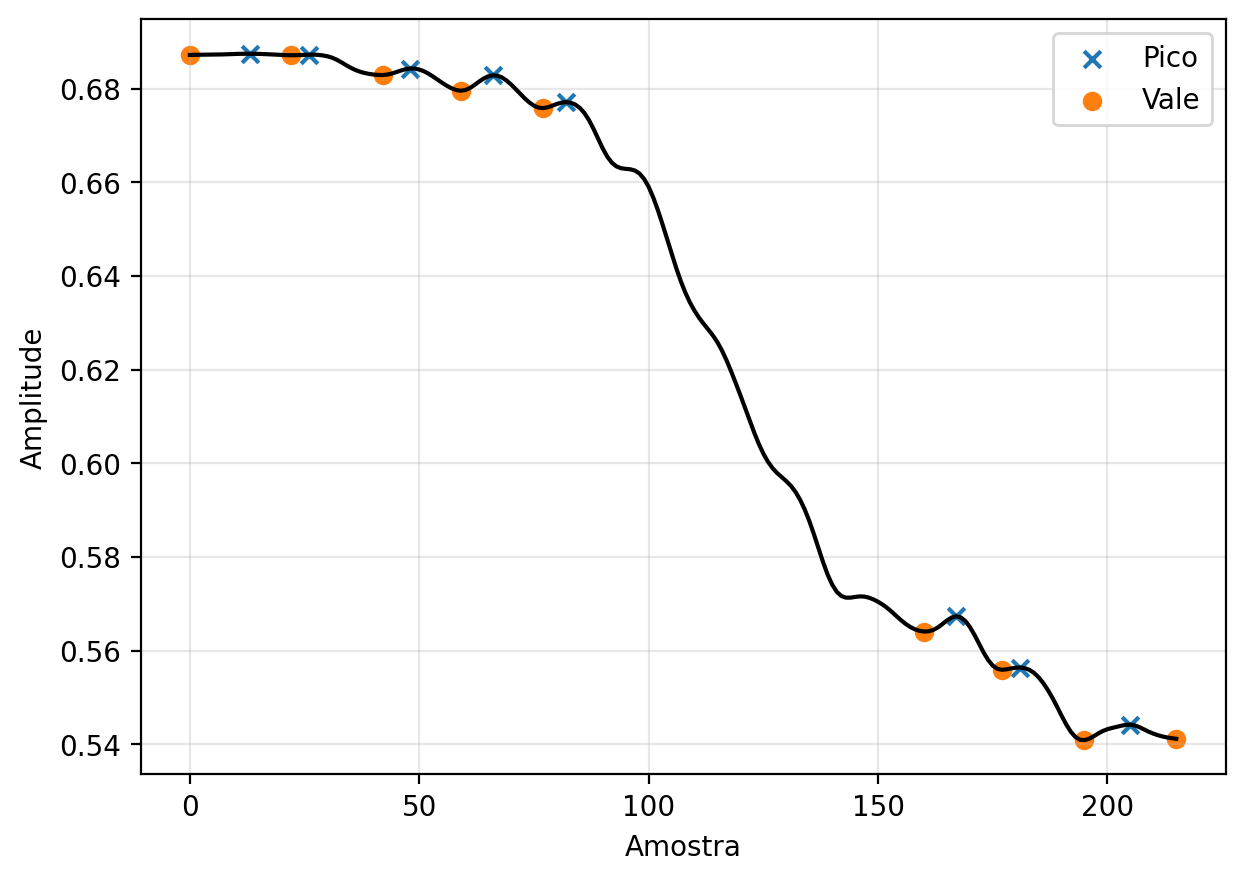

0.020464356696296426
[-0.00018512 -0.00296479 -0.00146096 -0.00571648 -0.10977931 -0.01094852
 -0.01219532]
[-5.80191692e-05 -4.22711141e-03 -3.35287908e-03 -3.71166073e-03
 -1.11755274e-01 -8.16759050e-03 -1.50173086e-02  2.81023031e-04]
n° de passos:  11
velocidade:  0.03359819756108368
velocidade (passos):  1.6417910447761193
foot off:  100.0


In [152]:
from findpeaks import findpeaks
fp = findpeaks(method='peakdetect', lookahead=5)

def plot_pv(results):
    #retorna os picos e vales apenas
    peak   = results['df'][results['df']['peak'] == True]
    valley = results['df'][results['df']['valley'] == True]

    #Mostra o gráfico
    plt.figure(dpi=200, figsize=(7,5))
    plt.grid(alpha=0.3)
    plt.plot(results['df']['x'], results['df']['y'], color='k')
    plt.scatter(peak['x'], peak['y'], label='Pico', marker='x')
    plt.scatter(valley['x'], valley['y'], label='Vale', marker='o')
    plt.xlabel('Amostra')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    return peak, valley

results1 = fp.fit(filteredy)
peak, valley = plot_pv(results1)

dist_peaks  = np.diff(peak['y'])
dist_valley = np.diff(valley['y'])

step_lenght = abs(np.average(dist_peaks))

print(step_lenght)
print(dist_peaks)
print(dist_valley)

n_passos = len(valley) +2
velocidade_m = (n_passos * step_lenght)/tx[-1]
velocidade_p = (n_passos)/tx[-1]
print("n° de passos: ", n_passos)
print("velocidade: ", velocidade_m)
print("velocidade (passos): ", velocidade_p)
picos = peak.y
amostra = peak.x
#step_lenght = (picos[-1] - picos[0])/len(picos)

def countX(lst, x): 
    count = 0
    for ele in lst: 
        if (ele == x): 
            count = count + 1
    return count 

foot29r = np.round(foot29_x-0.0005, 3)
nfoot_on = 0

for pico in picos:
    nfoot_on += countX(foot29r, round(pico-0.0005, 3))
    #foot_on += foot29_x
    nfoot_on += countX(foot29r, round(pico-0.0004, 3))
    #print(round(pico-0.0005, 3))
    
#print(nfoot_on)
#print(foot_on)
foot_off = ((len(foot29_x) - nfoot_on)/len(foot29_x)) *100
#print(len(foot29_x))
print("foot off: ", foot_off)

Obtenção do Centroide do Paralelogramo (Média entre as coordenadas dos vértices opostos)
(31x+30x/2,31y+30y/2)

In [153]:
centroidex = (foot32_x + foot29_x + foot30_x)/3
centroidey = (foot32_y + foot29_y + foot30_y)/3
centroide = (foot31_x + foot30_x)/2, (foot31_y + foot30_y)/2
print(centroidex)
print(centroidey)
transposta = list(map(lambda *i: [j for j in i], *centroide))
#print(transposta)


#centroidex = transposta[:, 0]
#centroidey = transposta[:, 1]

[0.48695195 0.48694946 0.48696766 0.48669046 0.48625815 0.48512741
 0.48412102 0.48358865 0.48301475 0.48271249 0.4825342  0.48256474
 0.4827792  0.48304429 0.48312727 0.48332246 0.48326795 0.48309246
 0.48290626 0.48289953 0.48280593 0.48266409 0.4826514  0.48273896
 0.48330517 0.48421112 0.48537902 0.48722675 0.48875601 0.48973043
 0.48995694 0.48971967 0.48940297 0.48841186 0.48676855 0.48541783
 0.48485504 0.48483175 0.48493674 0.48536761 0.48557887 0.48524739
 0.48464584 0.48400404 0.48380854 0.4834873  0.48341448 0.48318937
 0.48365016 0.48460697 0.48586712 0.48700977 0.48802059 0.48850845
 0.48843903 0.48834681 0.48869326 0.48881804 0.48942889 0.49000913
 0.49072634 0.49227515 0.49285756 0.49311554 0.49262963 0.49219862
 0.49167138 0.49143242 0.49095217 0.49050969 0.49056482 0.4915978
 0.49227925 0.49291285 0.49342604 0.49420413 0.49460219 0.49481599
 0.49529054 0.49559221 0.49540845 0.49565817 0.49593958 0.49612636
 0.49638663 0.4976948  0.49817428 0.49839678 0.49870066 0.49873

Distância do CoG ao Centroide

distância média:  0.08809874145538128
0.04008908835739488,0.03947333474148698,0.03795238952513781,0.03826645608759567,0.03910753145114428,0.03876224928126732,0.03802465491020166,0.038103759850844965,0.03815410413520441,0.03837835410676911,0.03855781152318209,0.03877595567188783,0.03872007841701161,0.03906779321965386,0.03916896931977828,0.03935537400322834,0.038877010182155,0.038256426754843705,0.03809549112277926,0.03890589155028219,0.03989164768817004,0.0417973283018309,0.04334587387226792,0.044926896698182714,0.043666433863832836,0.04187795820851446,0.041016551678387206,0.040383586352099175,0.040206464340213195,0.04117721100659641,0.04407216060492848,0.04735395902703719,0.05033476692447274,0.05191304524043654,0.053767217516410074,0.05435202148215809,0.05491189627082221,0.0544029859557298,0.05370062327665947,0.052170824372414874,0.04891265258227396,0.04767061468976123,0.047099136677588985,0.047493642857750824,0.04826096598968282,0.050479021530007946,0.052267087662109336,0.05503265136

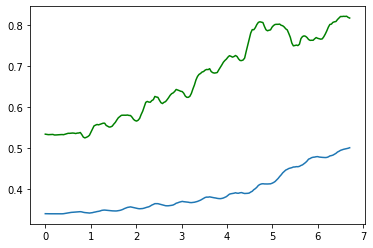

In [154]:
#Distância entre dois pontos
distancia_cog = np.sqrt((body_com_X-centroidex)**2) + ((body_com_Y-centroidey)**2)
#print(body_com_X)
#print(body_com_Y)
#print(distancia_cog)
print("distância média: ", np.average(distancia_cog))

for i in (distancia_cog):
    if(i != (len(distancia_cog)-1)):
        print(i, end=",")
    else: 
        print(i)

plt.plot(tx, centroidey, 'g')
plt.plot(tx, body_com_Y)

Distância do CoG a borda da BoS

In [128]:
#Distância do ponto às 4 retas (usar o menor valor como distância)
from itertools import chain

norm = np.linalg.norm

# Creating points
p1 = np.array([foot31]) #ponta esquerda
p2 = np.array([foot29]) #calcanhar esquerdo
p3 = np.array([foot32]) #ponta direita
p4 = np.array([foot30]) #calcanhar direito
p5 = np.array([body_com]) #cog
'''
p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
p5 = np.delete(body_com, 1, 1) #cog
'''
# Finding distance of p3 from a 
# line connecting p1 and p2

dis12 = np.abs((np.cross(p2-p1, p1-p5))/norm(p2-p1))
dis13 = np.abs((np.cross(p3-p1, p1-p5))/norm(p3-p1))
dis24 = np.abs((np.cross(p2-p4, p4-p5))/norm(p2-p4))
dis34 = np.abs((np.cross(p3-p4, p4-p5))/norm(p3-p4))

#print(dis12)

#print(pp)

dis12x = dis12[:, :, 0]
dis13x = dis13[:, :, 0]
dis24x = dis24[:, :, 0]
dis34x = dis34[:, :, 0]

dis12y = dis12[:, :, 1]
dis13y = dis13[:, :, 1]
dis24y = dis24[:, :, 1]
dis34y = dis34[:, :, 1]

menor1x = np.minimum(dis12x, dis13x)
menor2x = np.minimum(dis24x, dis34x)
distanciax = np.minimum(menor1x, menor2x)
#print(distanciax)

menor1y = np.minimum(dis12y, dis13y)
menor2y = np.minimum(dis24y, dis34y)
distanciay = np.minimum(menor1y, menor2y)
#print(distanciay)

distancia_borda = np.minimum(distanciax, distanciay)
print(distancia_borda)
distanciab_avg = np.average(distancia_borda)
distanciab_var = np.var(distancia_borda)
distanciab_desvio = np.std(distancia_borda)
print(distanciab_avg, distanciab_var, distanciab_desvio)

'''
menor1 = np.minimum(dis12, dis13)
menor2 = np.minimum(dis24, dis34)
distanciab = np.minimum(menor1, menor2)

distanciab_avg = np.average(distanciab)
distanciab_var = np.var(distanciab)
distanciab_desvio = np.std(distanciab)
print(distanciab_avg, distanciab_var, distanciab_desvio)
'''

[[4.77630016e-04 3.85669830e-04 2.80309718e-04 4.16032389e-04
  2.99845808e-04 8.65728673e-05 1.70699053e-04 1.76513022e-04
  4.18693662e-05 5.40311260e-06 1.76199736e-05 2.65507773e-05
  1.00786396e-04 1.52738453e-04 3.81053889e-04 3.58688829e-04
  4.85314669e-04 3.33619362e-04 1.03809197e-05 5.17562599e-05
  5.29173444e-04 6.65948571e-04 4.82424083e-04 5.73526327e-04
  5.19932095e-04 4.52952639e-04 4.02634034e-04 3.61253524e-04
  3.28411891e-04 2.98812010e-04 2.56275536e-04 2.21463053e-04
  1.90606263e-04 1.63451460e-04 2.14388301e-04 2.27858718e-04
  2.43054199e-04 2.57845694e-04 3.17106564e-04 3.73239844e-04
  4.26107813e-04 4.96228597e-04 5.35015802e-04 6.51012007e-04
  6.39178984e-04 5.86167401e-04 6.88952594e-04 1.03610832e-03
  1.32466120e-03 1.60659041e-03 1.54989708e-03 3.82606441e-05
  1.27938327e-03 1.21355014e-03 1.19832819e-03 1.18559722e-03
  1.18191507e-03 1.14413814e-03 1.33129833e-03 1.54073948e-03
  1.42902865e-03 1.29957657e-03 1.23127435e-03 1.21140981e-03
  9.6254

'\nmenor1 = np.minimum(dis12, dis13)\nmenor2 = np.minimum(dis24, dis34)\ndistanciab = np.minimum(menor1, menor2)\n\ndistanciab_avg = np.average(distanciab)\ndistanciab_var = np.var(distanciab)\ndistanciab_desvio = np.std(distanciab)\nprint(distanciab_avg, distanciab_var, distanciab_desvio)\n'

In [64]:
#Distância do ponto às 4 retas (usar o menor valor como distância)
from itertools import chain

norm = np.linalg.norm

# Creating points
p1 = np.array([foot31]) #ponta esquerda
p2 = np.array([foot29]) #calcanhar esquerdo
p3 = np.array([foot32]) #ponta direita
p4 = np.array([foot30]) #calcanhar direito
p5 = np.array([body_com]) #cog
'''
p1 = np.delete(foot31, 1, 1)
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
p5 = np.delete(body_com, 1, 1) #cog
'''
# Finding distance of p3 from a 
# line connecting p1 and p2

dis23 = np.abs((np.cross(p3-p2, p2-p5))/norm(p3-p2))
dis24 = np.abs((np.cross(p2-p4, p4-p5))/norm(p2-p4))
dis34 = np.abs((np.cross(p3-p4, p4-p5))/norm(p3-p4))

#print(dis12)

#print(pp)

#dis12x = dis12[:, :, 0]
dis23x = dis23[:, :, 0]
dis24x = dis24[:, :, 0]
dis34x = dis34[:, :, 0]

#dis12y = dis12[:, :, 1]
dis23y = dis23[:, :, 1]
dis24y = dis24[:, :, 1]
dis34y = dis34[:, :, 1]

menor1x = np.minimum(dis23x, dis24x)
menor2x = np.minimum(menor1x, dis34x)
distanciax = np.minimum(menor1x, menor2x)
#print(distanciax)

menor1y = np.minimum(dis23y, dis24y)
menor2y = np.minimum(menor1y, dis34y)
distanciay = np.minimum(menor1y, menor2y)
#print(distanciay)

distancia_borda = np.minimum(distanciax, distanciay)
print(distancia_borda)
distanciab_avg = np.average(distancia_borda)
distanciab_var = np.var(distancia_borda)
distanciab_desvio = np.std(distancia_borda)
print(distanciab_avg, distanciab_var, distanciab_desvio)

'''
menor1 = np.minimum(dis12, dis13)
menor2 = np.minimum(dis24, dis34)
distanciab = np.minimum(menor1, menor2)

distanciab_avg = np.average(distanciab)
distanciab_var = np.var(distanciab)
distanciab_desvio = np.std(distanciab)
print(distanciab_avg, distanciab_var, distanciab_desvio)
'''

[[7.49010169e-05 4.00459382e-04 4.01525839e-04 4.63804098e-04
  4.77126463e-04 4.65985617e-04 2.55544949e-04 2.73645178e-04
  3.46625896e-04 4.89742626e-04 4.71170437e-04 4.32290081e-04
  4.56812524e-04 3.81513367e-04 4.18512171e-04 4.52029345e-04
  4.72023575e-04 4.16451041e-04 3.95503172e-04 3.86767898e-04
  3.68969349e-04 3.50398092e-04 3.46001998e-04 3.80205812e-04
  4.10062944e-04 4.49360150e-04 3.87860668e-04 3.97619473e-04
  4.02443101e-04 4.85400094e-04 5.34041151e-04 5.62261400e-04
  5.80291500e-04 5.79267483e-04 6.26328284e-04 7.55401282e-04
  7.60753612e-04 7.65793814e-04 7.40766821e-04 7.12969365e-04
  5.90235834e-04 5.39001208e-04 4.71232619e-04 6.49637465e-05
  5.00593601e-04 6.10654716e-04 4.63594340e-04 3.44980105e-04
  3.64362317e-04 3.15091803e-04 3.87142697e-04 4.24482150e-04
  4.66526712e-04 4.94736772e-04 5.10372559e-04 4.83825395e-04
  6.19407234e-04 6.12913904e-04 6.40495173e-04 6.06651779e-04
  6.05217791e-04 6.13746431e-04 9.09627904e-04 1.05560664e-03
  1.0572

'\nmenor1 = np.minimum(dis12, dis13)\nmenor2 = np.minimum(dis24, dis34)\ndistanciab = np.minimum(menor1, menor2)\n\ndistanciab_avg = np.average(distanciab)\ndistanciab_var = np.var(distanciab)\ndistanciab_desvio = np.std(distanciab)\nprint(distanciab_avg, distanciab_var, distanciab_desvio)\n'

In [33]:
import math
#foot29 foot30 foot31 foot32
lado_direito = foot31_y - foot29_y
lado_esquerdo = foot32_y - foot30_y
diagonal_b = np.sqrt((foot29_x-foot30_x)**2) + ((foot29_y-foot30_y)**2)
diagonal_c = np.sqrt((foot31_x-foot32_x)**2) + ((foot31_y-foot32_y)**2)
print(diagonal_b)
print(diagonal_c)
centroide = [(diagonal_b+diagonal_c)/2, (lado_direito)]
h = foot29_x - foot30_x

[0.02928468 0.02973732 0.03008644 0.03053169 0.03086358 0.03118624
 0.0316595  0.03184461 0.03198234 0.03206007 0.0321515  0.03218865
 0.03218478 0.03220224 0.03221501 0.03237156 0.03232268 0.03217256
 0.03207697 0.03200326 0.03141661 0.03085691 0.03037829 0.03019717
 0.02968608 0.02831033 0.02695589 0.02617988 0.02557789 0.02552814
 0.02564109 0.02659128 0.02741609 0.02832401 0.02916534 0.02988719
 0.03021435 0.03027332 0.03065184 0.03090398 0.03131108 0.03290796
 0.03401577 0.03545631 0.0363377  0.03690896 0.03779829 0.03842249
 0.03729733 0.03567684 0.03342622 0.03080117 0.0286695  0.02767521
 0.02723769 0.02854251 0.03110677 0.03193204 0.03350367 0.0342731
 0.03573105 0.03693052 0.038263   0.04168092 0.04029261 0.03878929
 0.0353812  0.03177254 0.02983772 0.03034544 0.03228508 0.03780296
 0.04385128 0.05416884 0.06109076 0.06124882 0.05871147 0.05725496
 0.0595415  0.06258116 0.05847007 0.05277979 0.04818982 0.04491717
 0.03920044 0.03729244 0.03686567 0.03604934 0.03457116 0.03128

In [73]:
def calculate_area(c):

    '''
    Calculates the area of any quadrivaletral
    from a list of x,y coordinates in the following format:

    [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    '''

    first = c[0][0]*c[1][1] + c[1][0]*c[2][1] + c[2][0]*c[3][1] + c[3][0]*c[0][1]

    second = c[1][0]*c[0][1] + c[2][0]*c[1][1] + c[3][0]*c[2][1] + c[0][0]*c[3][1]

    area = 0.5*(first - second)

    return area

p1 = np.delete(foot31, 1, 1) #ponta esquerda
p2 = np.delete(foot29, 1, 1) #calcanhar esquerdo
p3 = np.delete(foot32, 1, 1) #ponta direita
p4 = np.delete(foot30, 1, 1) #calcanhar direito
c = np.concatenate((p1,p2,p3,p4), axis = 1)
area = calculate_area(c)

Areat = abs((0.5)*(foot30_x*(foot32_y-foot29_y)+foot32_x*(foot29_y-foot30_y)+foot29_x*(foot30_y-foot32_y)))


#print(Areat)
media_area = np.average(Areat)
print(media_area)
pe = np.average(foot31_y - foot29_y)
print(pe)

0.0005917212606301651
0.03878937381686586


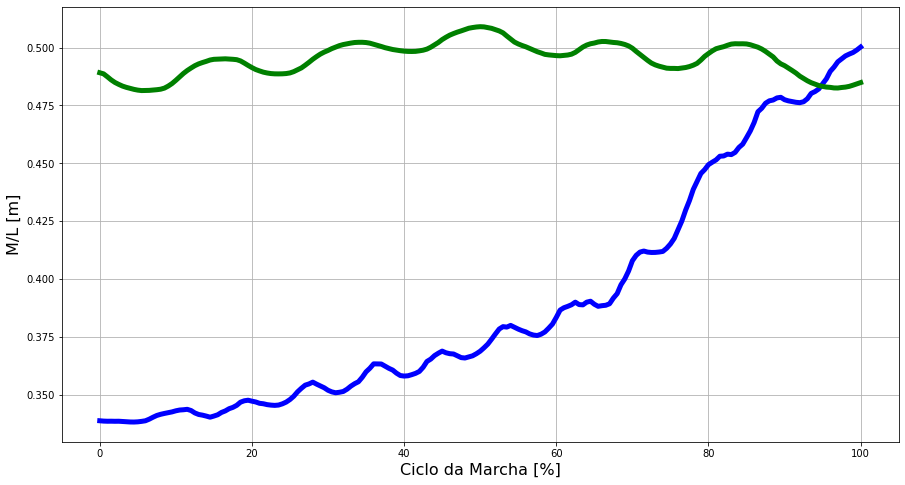

In [132]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_Y, color = 'b', linewidth = 5)
plt.plot(GaitCycle, body_com_X, color = 'g', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(ty, foot29_y, 'go')
#plt.plot(ty, foot30_y, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

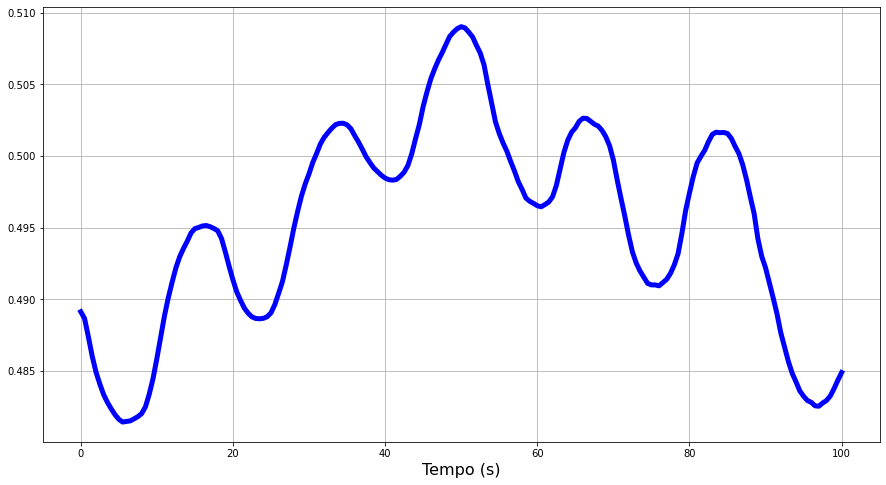

In [133]:
plt.figure(figsize=[15,8])
plt.plot(GaitCycle, body_com_X, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

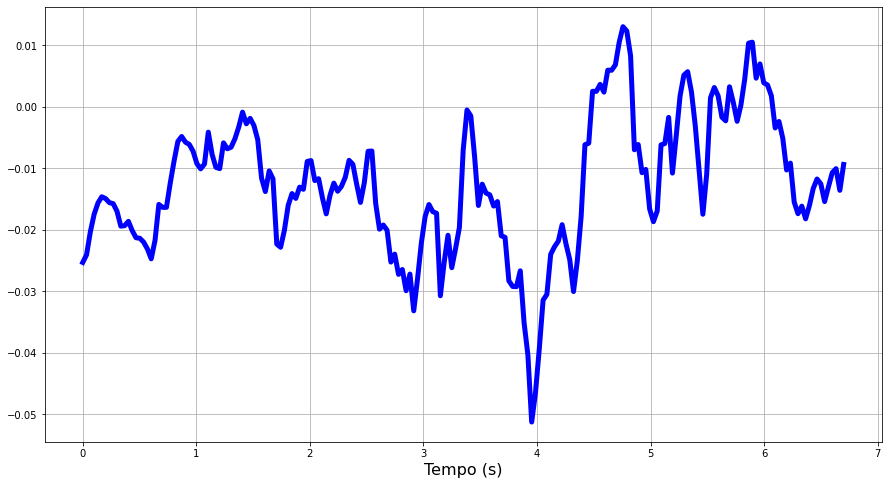

In [134]:

plt.figure(figsize=[15,8])
plt.plot(tz, body_com_Z, color = 'b', linewidth = 5)
#plt.plot(tx, foot_com_X1, color = 'b', linewidth = 5)
#plt.plot(foot_com_X1, foot_com_Y1, color = 'y', linewidth = 5)
#plt.ylabel('A/P', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=16)
#plt.title('Excursão vertical do CoM na marcha', fontsize=16)
#plt.plot(ty1, foot_y12, 'go')
#plt.plot(tx1, foot_x12, 'ro')
#plt.plot(foot_xj2, foot_yj2, 'g')
#plt.plot(foot_xi2, foot_yi2, 'r')
#plt.plot(tx, foot29_x, 'go')
#plt.plot(tx, foot30_x, 'ro')
#plt.plot(foot_x12, foot_y12, 'ro')
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


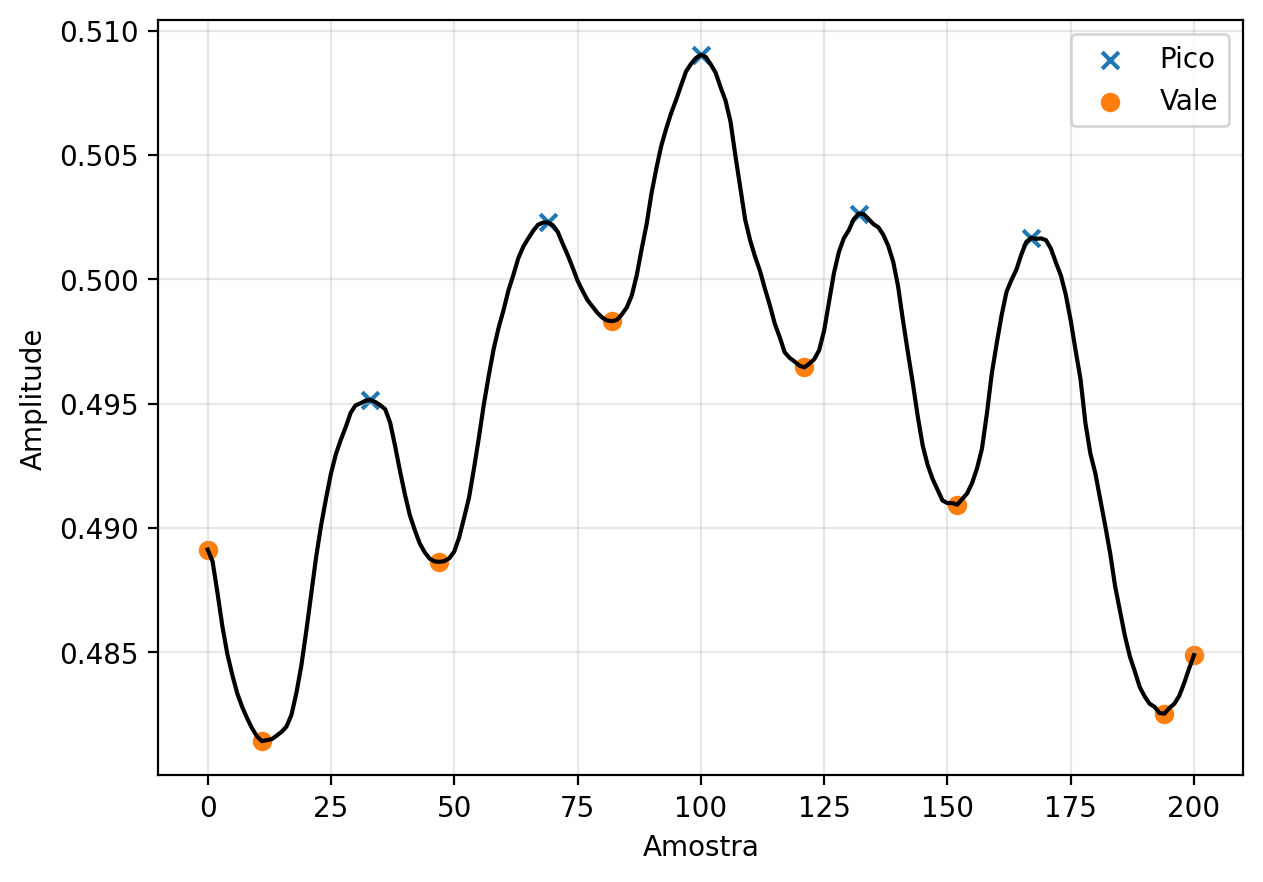

[36 31 32 35]
[11 36 35 39 31 42  6]


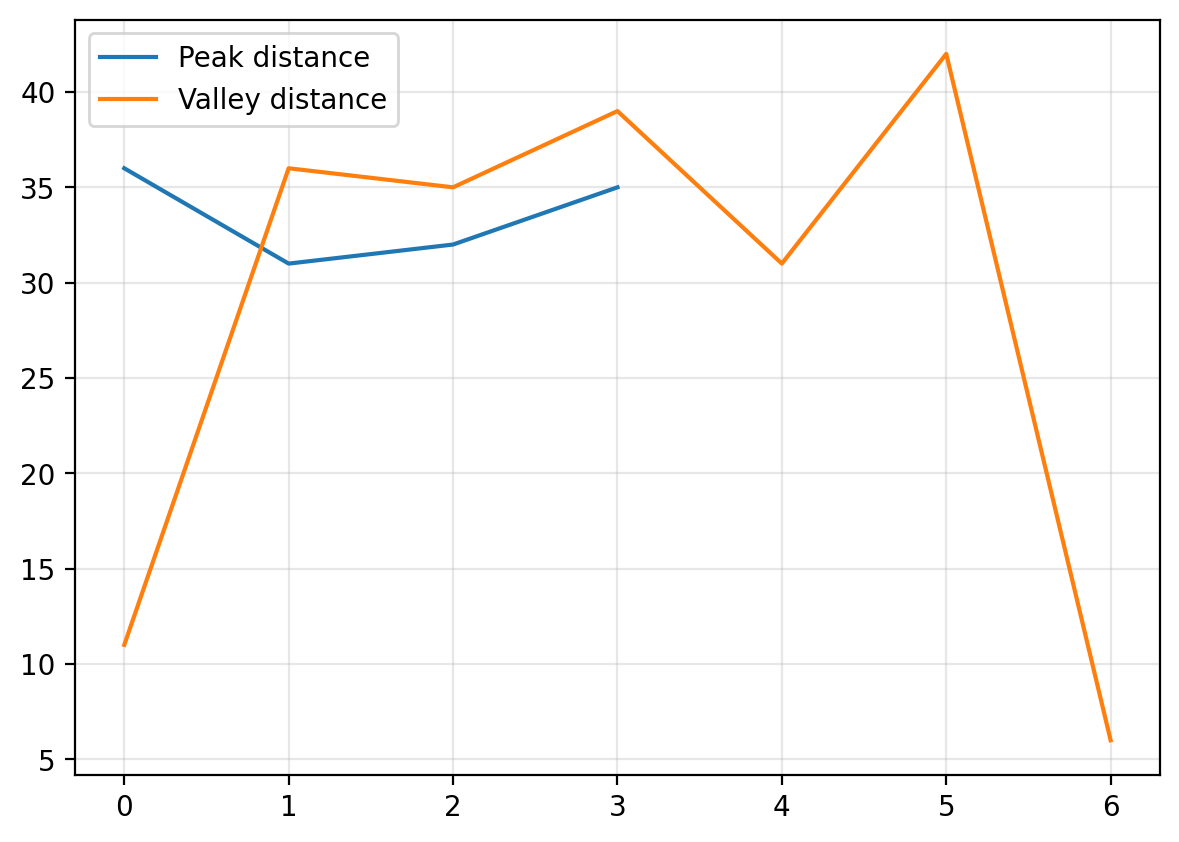

8


In [135]:


#Chama a função com os resultados obtidos anteriormente
#matriz = np.concatenate((tx, filteredx))
results = fp.fit(body_com_X)
peak, valley = plot_pv(results)

dist_peaks  = np.diff(peak['x'])
dist_valley = np.diff(valley['x'])

print(dist_peaks)
print(dist_valley)

plt.figure(dpi=200, figsize=(7,5))
plt.grid(alpha=0.3)
plt.plot(dist_peaks, label='Peak distance')
plt.plot(dist_valley, label='Valley distance')
plt.legend()
plt.show()

print(len(valley))

In [136]:
#print(2*filteredx[45]-filteredx[0])

# Filtragem

In [101]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

In [102]:
# apply a 2-pole lowpass filter at 0.15x Nyquist frequency (15 hz is half the max frequency of the video (30Hz))
bx, ax = scipy.signal.butter(2, 0.2)
filteredx = scipy.signal.filtfilt(bx, ax, body_com_X, axis=0)

by, ay = scipy.signal.butter(2, 0.2)
filteredy = scipy.signal.filtfilt(by, ay, body_com_Y, axis=0)

bz, az = scipy.signal.butter(2, 0.2)
filteredz = scipy.signal.filtfilt(bz, az, body_com_Z, axis=0)

b30z, a30z = scipy.signal.butter(2, 0.2)
filtered30z = scipy.signal.filtfilt(b30z, a30z, foot30_z, axis=0)

b29z, a29z = scipy.signal.butter(2, 0.2)
filtered29z = scipy.signal.filtfilt(b29z, a29z, foot29_z, axis=0)

b30y, a30y = scipy.signal.butter(2, 0.2)
filtered30y = scipy.signal.filtfilt(b30y, a30y, foot30_y, axis=0)

b29y, a29y = scipy.signal.butter(2, 0.2)
filtered29y = scipy.signal.filtfilt(b29y, a29y, foot29_y, axis=0)

b30x, a30x = scipy.signal.butter(2, 0.2)
filtered30x = scipy.signal.filtfilt(b30x, a30x, foot30_x, axis=0)

b29x, a29x = scipy.signal.butter(2, 0.2)
filtered29x = scipy.signal.filtfilt(b29x, a29x, foot29_x, axis=0)


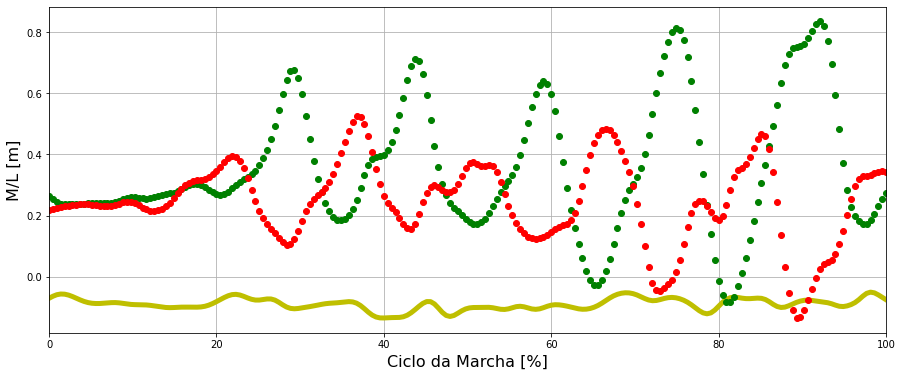

In [103]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredz, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30z, 'go')
plt.plot(GaitCycle, filtered29z, 'ro')
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.xlim(0, 100)
#plt.ylim(0.03, 0.07)
plt.grid()
plt.show()

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


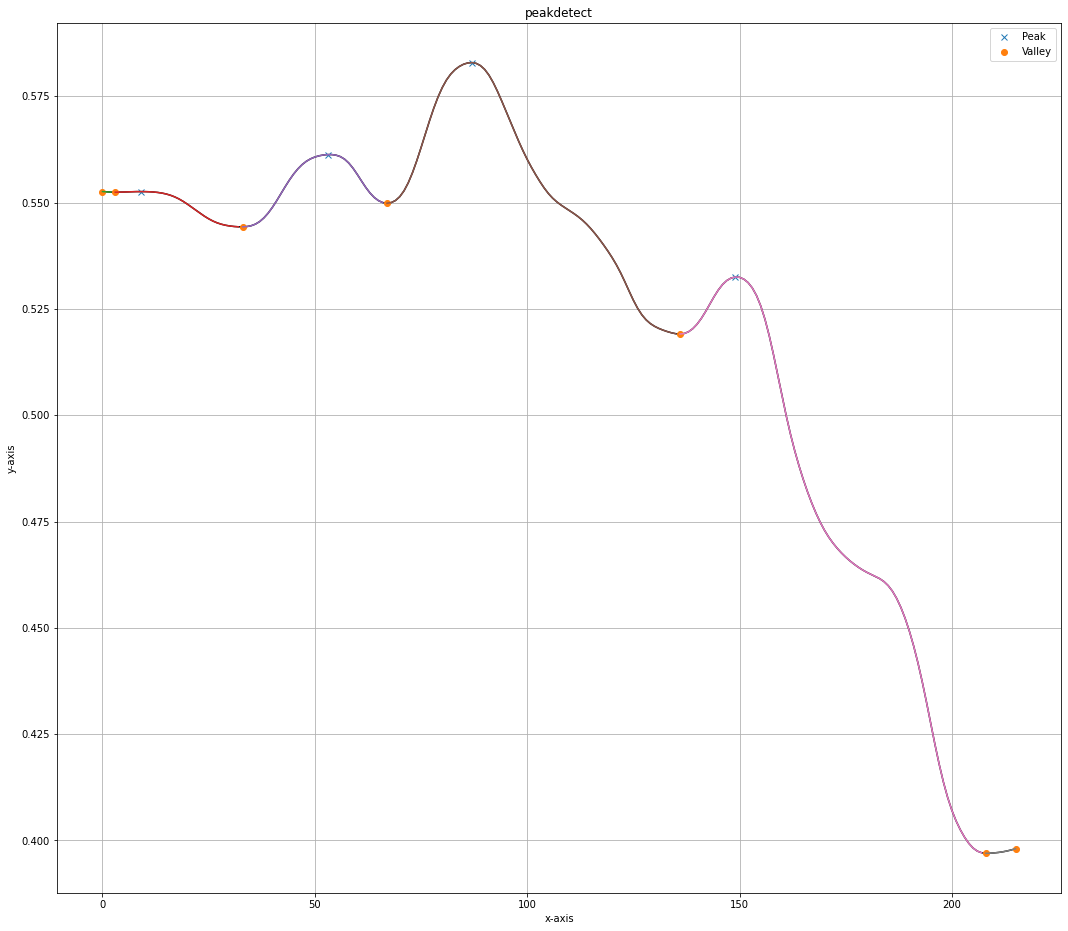

(None,
 <AxesSubplot:title={'center':'peakdetect'}, xlabel='x-axis', ylabel='y-axis'>)

In [104]:

results = fp.fit(filteredx)
fp.plot(figsize=(18,16))


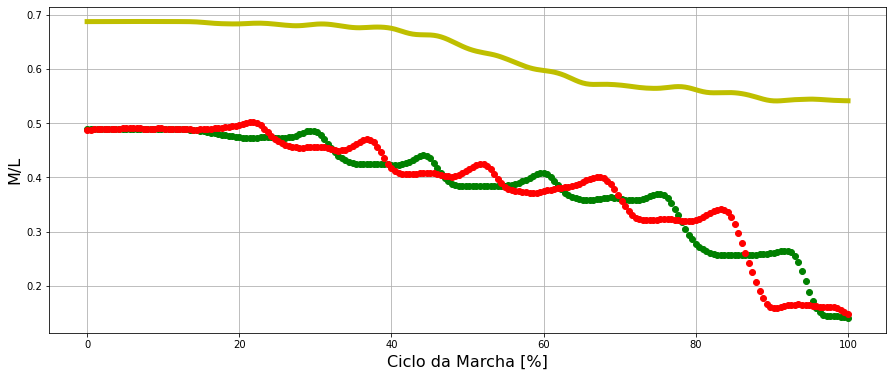

In [105]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredy, color = 'y', linewidth = 5)
plt.ylabel('M/L', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30y, 'go')
plt.plot(GaitCycle, filtered29y, 'ro')
#plt.ylim(0.6, 0.9)
#plt.title('', fontsize=16)
plt.grid()
plt.show()

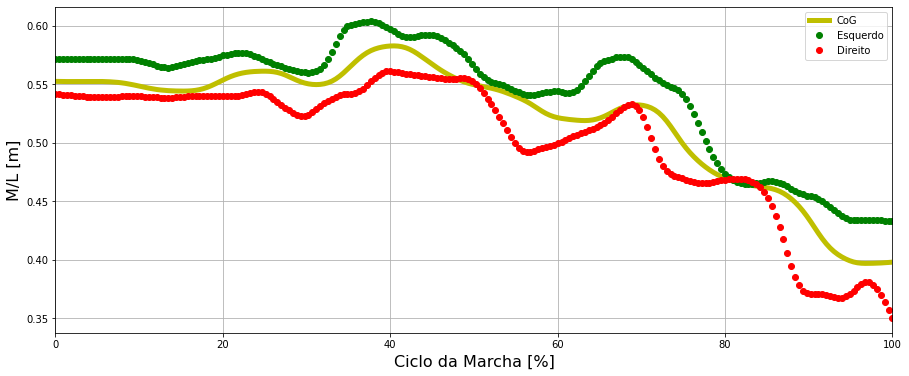

In [106]:
plt.figure(figsize=[15, 6])
plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
plt.plot(GaitCycle, filtered30x, 'go')
plt.plot(GaitCycle, filtered29x, 'ro')
plt.xlim(0, 100)
plt.legend(['CoG', 'Esquerdo', 'Direito'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

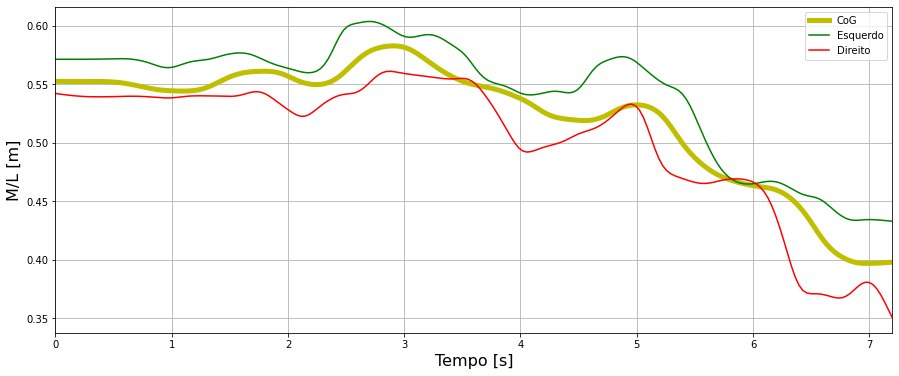

In [107]:
plt.figure(figsize=[15, 6])
plt.plot(tx, filteredx, color = 'y', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Tempo [s]', fontsize=16)
plt.plot(tx, filtered30x, 'g') # esquerdo
plt.plot(tx, filtered29x, 'r') # direito
plt.xlim(0, tx[-1])
plt.legend(['CoG', 'Esquerdo', 'Direito'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

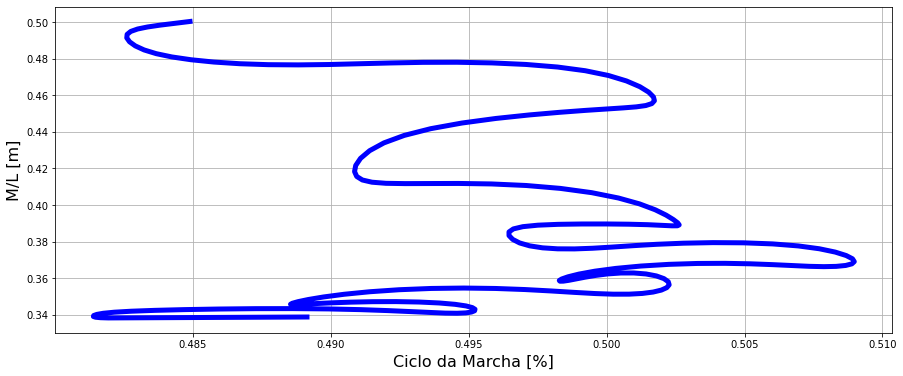

In [144]:
plt.figure(figsize=[15, 6])
#plt.plot(GaitCycle, filteredx, color = 'y', linewidth = 5)
plt.plot(filteredx, filteredy, color = 'b', linewidth = 5)
plt.ylabel('M/L [m]', fontsize=16)
plt.xlabel('Ciclo da Marcha [%]', fontsize=16)
#plt.plot(GaitCycle, filtered30x, 'go')
#plt.plot(GaitCycle, filtered29x, 'ro')
#plt.xlim(0, 100)
#plt.legend(['CoG', 'Direito', 'Esquerdo'])
#plt.title('Excursão vertical com filtro Butterworth', fontsize=16)
plt.grid()
plt.show()

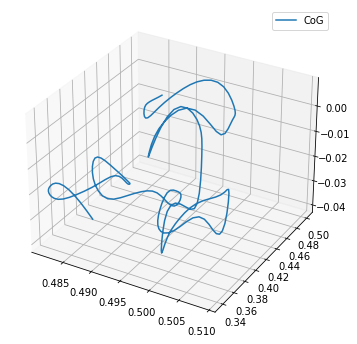

In [145]:
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure(figsize=[15, 6]).add_subplot(projection='3d')

ax.plot(filteredx, filteredy, filteredz, label='CoG')
ax.legend()
plt.show()

ICC

In [155]:
#d1 = [0.037731164232567886,0.04423855859667543,0.046157942436577684,0.04592508559286352,0.04645052901371584,0.046472311165270806,0.0466647561990212,0.04704807737153798,0.04704980978232894,0.046833439904946955,0.04653120041886136,0.046275611595925914,0.045787632956275824,0.04550988419968765,0.0450209671088554,0.044343401668904915,0.04401996270886411,0.04332010104840145,0.043149949173417614,0.04292751648555337,0.04294790176084993,0.04318796876676594,0.04329292811572977,0.0446389024997068,0.04584921555251273,0.046786824078323255,0.048454588805568376,0.04956134992056463,0.04921955909913717,0.04810589587906266,0.047092111091117286,0.04658477072193776,0.04647037258267426,0.04691405421836911,0.0475973606172968,0.04762586121960535,0.04745369039538905,0.048014088384422275,0.04883440692323155,0.05116947502071224,0.05603843946601557,0.06001786924791619,0.06462660932127602,0.06688028781563306,0.06740053042645616,0.06618246648147366,0.06471115784756368,0.06436234025351784,0.06475765291212579,0.06432466199168957,0.06288661227656524,0.061439335512428056,0.06058801728343724,0.06053099845644825,0.061052622347585836,0.0620284759488141,0.0655050050947991,0.06844857074399861,0.07090273568179002,0.07370906317190204,0.0743005021708732,0.0739666821573111,0.07292723607525559,0.07251672981136179,0.0722221192143144,0.07142598760726514,0.0716576561181349,0.07127284418355419,0.07183008088042736,0.07235079162285307,0.07426242344420607,0.07864084640254959,0.08623647068385772,0.09364914854419604,0.10055311480585523,0.10335809220322911,0.10589096315344348,0.10568020730016431,0.10505773753521219,0.10567488389785405,0.10538858850517922,0.10417910245998657,0.10214675357279376,0.10076136317570426,0.09828944186310613,0.098273573934452,0.09751986158491645,0.10155463484736853,0.1077579292113445,0.11281130445512312,0.1175840914169612,0.1197963367634014,0.12089051451380173,0.12007243194771393,0.12050489178686291,0.12156043245104951,0.12039939037795286,0.11846604861062636,0.11912902380953617,0.12027531086420724,0.12066371287662005,0.12262779943745648,0.1280977456165816,0.13687964986555995,0.1482675708513412,0.15918817722784617,0.16735813771604133,0.17335894268402938,0.1742430693310297,0.17220382993979594,0.17031469039591882,0.1691863090566285,0.16872397154983113,0.1649836855891606,0.16119524411038133,0.15716199741763492,0.15412402306528247,0.15505452463463185,0.1560718078936952,0.1537196758614787,0.15383174063328786,0.1581086250819647,0.1597070798735356,0.15346097050878346,0.15033581846698207,0.14555735652578197,0.13889233583252628,0.13303617417389538,0.1323327340584716,0.13038277130825324,0.1269098341239896,0.1240935211022855,0.12116769432785315,0.11834215255163014,0.11755574105519698,0.1162009432582088,0.11898451245143477,0.12997724019827533,0.14002458298745468,0.14409804766778808,0.14699047631325857,0.1442056063629301,0.13842795120915177,0.13282955114997985,0.12840955516731367,0.12259667107514742,0.12027714043990377,0.11934725193447479,0.11531502270768229,0.11467650661164074,0.10914655426286805,0.10794610898728102,0.11233074373187456,0.11950050852961887,0.12609577453322757,0.13149804661624317,0.13688440265741553,0.1420492901163896,0.14527534191722255,0.14726719866467367,0.14700663413423976,0.14722607379806443,0.14731329481713418,0.14660414917187,0.14548044190604065]

#d2 = [0.05410175622130326,0.05325171788695745,0.05294174935555381,0.05265602925994427,0.05254134251040962,0.05231694194097757,0.05210469890203248,0.05200653809356714,0.05197969682347797,0.05198301063786441,0.052097629282497046,0.052141887880997974,0.052206471428809506,0.052349800884878166,0.05260450021451344,0.05293096619862211,0.05331778057238737,0.05368916792092612,0.0540525955463155,0.05462473299748901,0.0551671310388321,0.05562795771479225,0.05603697346321026,0.05658582444361705,0.056969104641817855,0.0571276384203265,0.05742533995794507,0.05764576051893239,0.057471269357381026,0.05771042715265189,0.0587319231768808,0.06001413695177818,0.06099827610989791,0.06154083080399795,0.061846371947796415,0.0622791161449884,0.06210720617089777,0.061399276344474854,0.06081301924705108,0.059720840329532184,0.05874025118652748,0.05787416453277165,0.056751154733578106,0.055655997773144755,0.05468385160602412,0.05315052151453922,0.05164274694402499,0.050627113547767943,0.05008044827283995,0.05038551188577509,0.0517004005165275,0.052337992200313814,0.05249657264220248,0.053105508985121695,0.05282266865677989,0.05127459913784342,0.050445270628038275,0.04888730694599603,0.04921099204452517,0.04987987684395207,0.05053496090401259,0.05053952910508225,0.05082278157540815,0.04995334292500943,0.051005357349875755,0.05148998917418371,0.05515183864644575,0.0602110397715527,0.0646940046581814,0.06954684824218363,0.07227678822701926,0.07530253043342192,0.07812526339594475,0.08209796038718079,0.08482356231722371,0.08241531026574377,0.07776159929364482,0.07428666167423964,0.07185941379683936,0.06990990916452736,0.06972775038553691,0.07033617387034471,0.07199983830696045,0.07401385966655019,0.07696259761023473,0.07904524050553159,0.07872786182341554,0.07869089222709812,0.07702135959398426,0.07403107882552486,0.07282234313451022,0.07251763579989082,0.07446625294058773,0.07456972978570969,0.07523906597885202,0.07701984319093358,0.07960767443565077,0.0818223042679847,0.08618605859945083,0.09185867033021052,0.09557694437927454,0.09812364579130187,0.095316845985464,0.09277676264305516,0.0880711836272593,0.08533327105125309,0.08222954870208324,0.07764922953850839,0.07068668949012662,0.06914032629836506,0.06586760487458965,0.06321078337341401,0.05788237510779069,0.058903170531708945,0.060657131329017414,0.06332456919212624,0.06487581418258995,0.06523697794980937,0.0667979003234139,0.06786240963478815,0.06614573045599412,0.06188769221691693,0.057777327296687706,0.05332336503660929,0.052720727266733575,0.05453568187883627,0.05553474482660609,0.05474354808804329,0.05406228290437,0.05561835194540596,0.05657997825602715,0.05931498009380621,0.06284367871237373,0.06585344271382013,0.06778310200817034,0.06922145939801588,0.0710193121739291,0.07470769622891871,0.07624024736391151,0.07538140385967566,0.07529657400583421,0.0731875005702727,0.07093034300623632,0.07119801121103625,0.07011959682498937,0.06954555196031038,0.06976144840702324,0.06938927006557777,0.06985132184040094,0.06991653687345893,0.07025046976069943,0.07000261908076179,0.07039948874486895,0.06663742681347398,0.06426935157678346,0.06293423289800157,0.06209542745695846,0.06416634111268332,0.06749865140663604,0.07075768149251642,0.07612088857002375,0.07778826705706474,0.07818060048260356,0.07665172977446039,0.07570842883256937,0.07511697007573755,0.07822663512334507,0.08164016334446819,0.08493997732120194,0.08414077155470377,0.08376735059907481,0.0813384063823062,0.08158102517434301,0.08315090080126909,0.08326640160531745,0.08390454065326812,0.08520035007317331,0.08745562635142665,0.09002692150818188,0.09008440179339092,0.0892055925536184,0.08959174247875916,0.08974507285856516,0.0911496215911653,0.09363562098239234,0.09565997050480694,0.09845197664476091,0.09933783143195422,0.10002957717145432,0.10473561912860378,0.10927486085565902,0.11265405260966324,0.11555231894556743,0.11085260325025365,0.11090552970370267,0.11544942325089437,0.12050108938490442,0.1255039754233792,0.12664431756895272,0.13055182776128418,0.13337319173565196,0.13655871513457832,0.14587541831414086,0.16039228880622072,0.17207215711664897,0.1856222487467552,0.18993360041459556,0.1924251695275944,0.19056570482680274,0.19014507692526642,0.18977315194542002,0.1895263750998816,0.1860455991131828,0.18530271930675007,0.1845552908803776,0.18372474925479962]

d1 = [0.05133799825048269,0.049300730820028275,0.04797456050663363,0.04683613284800186,0.046096290337981446,0.04515361895293028,0.044346137598844496,0.04312489385847907,0.043040426566603666,0.04226401257515509,0.04158805267812778,0.04121848375934626,0.04106436637461387,0.04114739242265292,0.041327172174404396,0.04114668942023354,0.0413432629310344,0.04181447505445684,0.041583231730305426,0.04140866940258124,0.041649295833750356,0.041702857483062246,0.04225640189744912,0.0431675250341043,0.04519669854122377,0.04706685605098317,0.04644864852252685,0.04638070053361658,0.045595519035267304,0.0454714995324317,0.04637659495960922,0.048003022962838315,0.05026477955383483,0.0527876370479075,0.05468526260826366,0.05598561843375139,0.05703774291349838,0.05760662091442849,0.056697436807461324,0.05683263255478367,0.05746819970777734,0.05720925105321193,0.05586491235888525,0.05579205660357045,0.0548289705830426,0.05221656470479393,0.04951128412844356,0.0495060887012783,0.051404973740352494,0.053296022077434606,0.05772960424185592,0.059307899862732855,0.060903410263054486,0.06216984396737493,0.06407901681383028,0.06428862664281804,0.06418389922166753,0.06362719817549053,0.06207831981238644,0.06105614738806594,0.06088977971448904,0.05964356663656459,0.05703477612492612,0.056729024459970814,0.05663541633307286,0.05767184454142555,0.05991371701178226,0.06436576720913628,0.06993869097361152,0.07651048696514733,0.08113046556610384,0.08422026218995658,0.08639598725503156,0.08757084075950214,0.08763061293207416,0.08825612485298535,0.08719744973153894,0.08617044544781224,0.0850105986674475,0.08077471554136804,0.07941417407844982,0.07907175489606222,0.07998899858836658,0.081386854200614,0.0833966928126426,0.08754403018340742,0.09170065250990614,0.09484353247258638,0.09596296187278283,0.09611341771066721,0.09786721940614646,0.09613438693873123,0.09667134862227449,0.09693386648008966,0.09670184914262477,0.09723348718366272,0.09081853440944124,0.08898929075541943,0.08952791745496254,0.09160617496883099,0.0952203492600502,0.10147385080597517,0.11329588754434286,0.12397734562851077,0.13323784204262315,0.13888579635123507,0.13997156455749563,0.1433277277571775,0.14270295569215624,0.14318372872296797,0.1408959431481811,0.14102001345185503,0.14031515707176093,0.13998281515193264,0.13344975282372173,0.12795059408750153,0.12626489417145176,0.1253134236252766,0.12429625478391014,0.12729208895032096,0.13170066272907277,0.1338240590578766,0.13162629607237375,0.12902266039113228,0.12832510626863813,0.12562003438315034,0.1198152828439815,0.11461254246319805,0.10565670748189876,0.10187761155896649,0.09634701387485135,0.09073116554024321,0.08565168207586465,0.08311932937415391,0.08369585168995396,0.08438771987261917,0.08521849236157585,0.08831318646846927,0.09377689269229678,0.09552346807535776,0.09495302209411496,0.09619840369739349,0.09469649629366436,0.08957392390756347,0.08373748052995886,0.08224708777878006,0.07967891856518791,0.07699801828677147,0.07525897705371948,0.07079089075915362,0.07049010498105063,0.07008026374473486,0.0714019462381457,0.07370193657074832,0.07801008549226432,0.08256452530378175,0.08716492244266946,0.08900990956745866,0.09208626191807025,0.09189456039624899,0.09211993017848927,0.0912120427846492,0.09175013385573536,0.09224559512574239,0.091317906798827,0.0904018485912681,0.0895717406950867,0.09097278326535167,0.09210206361681808,0.09436955737647822,0.10015872023282486,0.11184231875325372,0.12373548748551162,0.13591758823309522,0.14689527329644175,0.15566395806777653,0.1613895169864452,0.16103225778600308,0.16038791081169626,0.15726441427219362,0.15646482961079133,0.1550544921201479,0.15258892571521646,0.15200695068523226,0.1517906045326808,0.15198831682506436,0.15267338275949016,0.15488743569454713,0.15891936983255506,0.1598550412353601,0.1611287474617388,0.16172812572926465,0.16108812519262475,0.1611758498457621,0.1618197648869227,0.16251618861595313,0.16255107032601177,0.16290340266404224,0.1631695015041547,0.16376025295910732,0.16355399216747532,0.1633469816615686,0.1629489273449458]

d2 = [0.04008908835739488,0.03947333474148698,0.03795238952513781,0.03826645608759567,0.03910753145114428,0.03876224928126732,0.03802465491020166,0.038103759850844965,0.03815410413520441,0.03837835410676911,0.03855781152318209,0.03877595567188783,0.03872007841701161,0.03906779321965386,0.03916896931977828,0.03935537400322834,0.038877010182155,0.038256426754843705,0.03809549112277926,0.03890589155028219,0.03989164768817004,0.0417973283018309,0.04334587387226792,0.044926896698182714,0.043666433863832836,0.04187795820851446,0.041016551678387206,0.040383586352099175,0.040206464340213195,0.04117721100659641,0.04407216060492848,0.04735395902703719,0.05033476692447274,0.05191304524043654,0.053767217516410074,0.05435202148215809,0.05491189627082221,0.0544029859557298,0.05370062327665947,0.052170824372414874,0.04891265258227396,0.04767061468976123,0.047099136677588985,0.047493642857750824,0.04826096598968282,0.050479021530007946,0.052267087662109336,0.05503265136104308,0.05679711102875607,0.05693764454001624,0.056854284341655244,0.055763479581694204,0.054628760961985205,0.054267701848852976,0.055099737525525355,0.05573558281444522,0.056298152540495694,0.055922630236787126,0.05437421895762128,0.05374740939182025,0.05364657662173016,0.05409943968082582,0.05627798544993292,0.060893930858348405,0.06540541987673971,0.07085519292157834,0.07661506848780458,0.07775531330185123,0.07707339232587736,0.07633077912394523,0.07704010012463296,0.0760792955120477,0.07804559196177906,0.07625242835575098,0.07483075229510505,0.07041774270983327,0.06700838415164165,0.06575473281264768,0.06718030271429622,0.06798736210907083,0.07039852458000612,0.0726342825339525,0.07516767861682075,0.07691899512148713,0.07750190448755628,0.07741198437056653,0.07875772054093955,0.07808764754684264,0.07715828364231346,0.07666990201451046,0.07659113928741046,0.07501715554905795,0.07221293235690428,0.07121720495049219,0.07172447424106584,0.0734716284641803,0.07684017239502304,0.0831758556183798,0.08899779831348381,0.09628393569589067,0.10160693835939878,0.10632891512712836,0.11018663371542095,0.11229269320132786,0.11276060780580976,0.11222805045838455,0.11118682578056605,0.10850617677452302,0.10746786007187997,0.10162252490352416,0.09930918765432581,0.09871993911108583,0.09890568387323956,0.09959751507577626,0.10390685235137585,0.10780391180104784,0.11131523786327888,0.1148286884144549,0.11614623307712674,0.11696217535810474,0.11800693062486259,0.1180773955632303,0.11659320040519616,0.11501156116147886,0.11595674308619201,0.11769924442168504,0.11775209224382502,0.1144032117406002,0.11175718862090651,0.11271353478886817,0.11567774152083479,0.1204427202841566,0.13213643671633135,0.1441185038714334,0.1560107524383651,0.16764699423485144,0.17567015942916994,0.17496348414601423,0.17823542364646014,0.1804330147278187,0.17955033249098007,0.1766315864443665,0.17235347563458617,0.16977802848495935,0.16066289676899947,0.15360994391147878,0.15138003518789708,0.151755702852496,0.15133289991796978,0.15478574164348205,0.1560406129551138,0.15591809791653663,0.15313397292852757,0.14983165045287272,0.14564765513167313,0.1385933957498904,0.13331042407000196,0.12942537601535034,0.12504787765002254,0.12302865540843957,0.11676204371315324,0.11071145686768029,0.10148343795614016,0.09587826027463697,0.09580393204969478,0.09530861322573668,0.0946869577338651,0.09623304867667527,0.1042413741194354,0.10672887584811243,0.10698262070928999,0.10627971792507852,0.10301303499876355,0.09772287686738876,0.09498030195670915,0.09321757998194367,0.09149817419487381,0.092321302373252,0.09173942731962774,0.08932537153091036,0.08866748261367133,0.08767338959069404,0.08730984437744521,0.08976375009534081,0.0931656105489509,0.09759302470169307,0.10112839836212735,0.10386321593753839,0.10407542939411711,0.10575987597791513,0.10545407923553314,0.10456272419010519,0.1052680060359417,0.106528106966649,0.10813948196878309,0.1074222024612514,0.10719813933215085,0.10690434048339818,0.10722184688193558,0.10532782863797241,0.10430082461454071]

In [156]:
freq_amostragem = 30 # frames por segundo

td = np.linspace(0, len(d1) / freq_amostragem, len(d1))

In [157]:
tam1 = np.size(d1)
tam2 = np.size(d2)
#tam3 = np.size(filtered3)
#print(np.concatenate((t1, t2, t3), axis=None))
#print(np.ones(tam1)*2)
nteste = np.concatenate(((np.ones(tam1), (np.ones(tam2)*2))))
ndeslocamento = np.concatenate((d1, d2), axis=None)
ntempo = np.concatenate((td, td), axis=None)
nj = np.ones(np.size(nteste))
mm = np.concatenate((list(range(tam1)), list(range(tam2))), axis=None)

print(np.size(nteste))
print(np.size(ndeslocamento))
print(np.size(mm))
print(np.size(ntempo))
#print(mm)

404
404
404
406


In [158]:
import pandas as pd
df = pd.DataFrame({'teste': mm, 'video': nteste, 'deslocamento': ndeslocamento, 'tempo': nteste})
df.head()

,teste,video,deslocamento,tempo
0,0,1.0,0.051338,1.0
1,1,1.0,0.049301,1.0
2,2,1.0,0.047975,1.0
3,3,1.0,0.046836,1.0
4,4,1.0,0.046096,1.0


In [159]:
import pingouin as pg

icc = pg.intraclass_corr(data=df, targets='teste', raters='video', ratings='tempo', nan_policy='omit')

icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,-1.0,0.0,200,201,1.0,"[-1.0, -1.0]"
ICC2,Single random raters,0.0,NaN,200,200,NaN,"[nan, nan]"
ICC3,Single fixed raters,NaN,NaN,200,200,NaN,"[nan, nan]"
ICC1k,Average raters absolute,-inf,0.0,200,201,1.0,"[-inf, -inf]"
ICC2k,Average random raters,0.0,NaN,200,200,NaN,"[nan, nan]"
ICC3k,Average fixed raters,NaN,NaN,200,200,NaN,"[nan, nan]"


In [160]:
icc = pg.intraclass_corr(data=df, targets='teste', raters='video', ratings='deslocamento', nan_policy='omit')

icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.517208,3.142575,200,201,1.459321e-15,"[0.41, 0.61]"
ICC2,Single random raters,0.517419,3.148255,200,200,1.478589e-15,"[0.41, 0.61]"
ICC3,Single fixed raters,0.517870,3.148255,200,200,1.478589e-15,"[0.41, 0.61]"
ICC1k,Average raters absolute,0.681790,3.142575,200,201,1.459321e-15,"[0.58, 0.76]"
ICC2k,Average random raters,0.681972,3.148255,200,200,1.478589e-15,"[0.58, 0.76]"
ICC3k,Average fixed raters,0.682364,3.148255,200,200,1.478589e-15,"[0.58, 0.76]"
